# Exploratory Data Analysis (EDA) & Initial ML Modelling with weatherAUS dataset

## Executive Summary

Expect rain. Only two simple words, yet the stakes sometimes could be much higher than grabbing an umbrella before leaving the house tomorrow. Rain could ruin picnic plans or bring tremendous joy to farmers who are desperate to save their drought-stricken crops. 

Although rain forecast is so ubiquitous nowadays that it is easy to take it for granted, learning how to predict next-day rain is a simple and practical way to explore Machine Learning concepts with Python. That is also the motivation for this personal project: Predict next-day rain in Australia 

This notebook illustrates both Exploratory Data Analysis (EDA) and initial experiment with several ML models to establish baseline and basic understanding about prediction performance. Below are the goals that I want to achieve through this notebook. 
- To understand the characteristics (e.g. data types, cardinality, descriptive statistics, skewness, etc.) and relationship between existing features and target labels (RainTomorrow)
- To shortlist relevant features with predictive power
- To determine the most optimal approach to address data quality issues (e.g. missing values, outliers) and preprocess numerical and categorical features, ready for ML model training
- To experiment with several ML models for baseline performance
- To determine the next steps for this project 

Based on the analysis and experiment results from this notebook, here are the next steps for this project (which would be illustrated in another notebook for ease of reference). 

**Step 1. Set up Jupyter Lab on GCP AI Platform**

**Step 2. Perform data preprocessing** 
1. Convert Date column from string to datetime & create Year & Month features
2. Handle missing values for numerical features: forward fill method
3. Remove records with missing labels (i.e. RainTomorrow is null)
4. Split data into a training set and a test set: remove Date feature due to high cardinality
5. Handle missing values and encoding categorical features with one-hot encoding and binary encoding
6. Feature scaling: standard scaler for simplicity
7. Correct imbalanced dataset with SMOTE (Synthetic Minority Oversampling Technique)

**Step 3. Fine-tune Random Forest Classifier using RandomizedSearchCV and GridSearchCV**

Note: Based on earlier experiment with GCP AI Platform, RandomizedSearchCV might take too long to fit if I use the full dataset. To speed up the process, I would perform fine-tuning with 25% of the randomly sampled records.  

## 1. Background Understanding

Australians are known for loving the outdoors. However, while sunny weather is common in Australia, there are also many rainy days. To plan for outdoor activities, work or travel that depends on the weather, being able to predict whether it will rain tomorrow is vital. In this notebook, we will perform Exploratory Data Analysis on the weatherAUS dataset in order to understand whether it is feasible to predict next-day rain based on today's weather readings. 

## 2. Data Understanding

For this project, I am using the 10 years of daily weather observations from many location across Australia obtained from [Kaggle](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package)

In [1]:
import os
import pandas as pd
import numpy as np
from numpy import asarray
from datetime import datetime
from random import randint


# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

# EDA

# Chi-square test and t-test for EDA
from scipy.stats import chi2_contingency
from scipy import stats

# Logistic correlation for EDA
import statsmodels.api as sm

# Data Visualisation for EDA
import matplotlib.pyplot as plt
import seaborn as sns

# Set up matplotlib so it uses Jupyter's graphical backend when plotting the charts
%matplotlib inline 

# Data preparation
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# ML model training
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier

# Model evaluation & selection
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Fine-tune model performance
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [2]:
# Display all columns without truncation in dataframes
pd.set_option('display.max_columns', 500)

### 2.1. Load the data & describe it

In [3]:
# Load daily weather dataset
cwd = os.getcwd()
weather_file = cwd + '/input/weatherAUS.csv'
weather_df = pd.read_csv(weather_file)
weather_df.head(10)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
5,2008-12-06,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,W,19.0,24.0,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,No
6,2008-12-07,Albury,14.3,25.0,0.0,NaN,NaN,W,50.0,SW,W,20.0,24.0,49.0,19.0,1009.6,1008.2,1.0,NaN,18.1,24.6,No,No
7,2008-12-08,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,W,6.0,17.0,48.0,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No,No
8,2008-12-09,Albury,9.7,31.9,0.0,NaN,NaN,NNW,80.0,SE,NW,7.0,28.0,42.0,9.0,1008.9,1003.6,NaN,NaN,18.3,30.2,No,Yes
9,2008-12-10,Albury,13.1,30.1,1.4,NaN,NaN,W,28.0,S,SSE,15.0,11.0,58.0,27.0,1007.0,1005.7,NaN,NaN,20.1,28.2,Yes,No


In [4]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [5]:
# Check for missing values
weather_df.isnull().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

**Key Takeaway**
1. The dataset includes 145460 instances with 23 columns. 
2. RainTomorrow is the label while the other columns are potential features. They include 16 numerical features and 6 categorical features. 
3. ***(Action Required)*** There are some missing values across most columns. However, the amount of missing values is not too significant for any features to be discarded at this stage. Therefore, I aim to retain all features and find appropriate ways to impute missing values at a later stage. 
4. ***(Action Required)*** Date column is currently stored as string. We will have to convert it into datetime format for subsequent analysis

In [6]:
# Show the descriptive statistics for numerical values
weather_df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


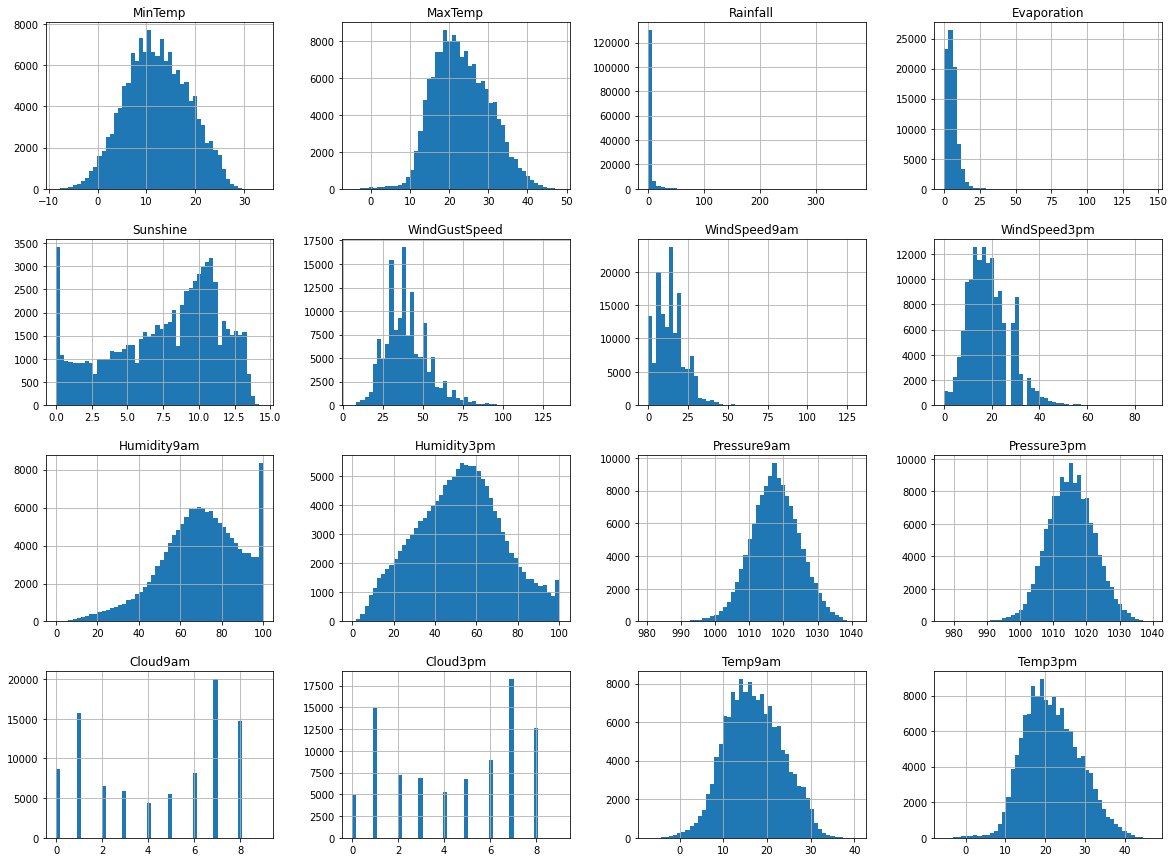

In [7]:
# Plot a histogram for each numerical attribute
weather_df.hist(bins = 50, figsize = (20,15))
plt.show()

**Key Takeaways**
1. Cloud9am and Cloud3pm represents cloud cover from 0 to 9. [Cloud cover](https://www.metoffice.gov.uk/weather/guides/observations/how-we-measure-cloud) is estimated in terms of how many eights of the sky are covered in cloud, ranging from 0 oktas (completely clear sky) through to 8 oktas (completely overcast). In addition, in the SYNOP code there is an extra cloud cover indicator '9' indicating that the sky is totally obscured (i.e. hidden from view), usually due to dense fog or heavy snow. 
2. ***(Action Required)*** A few histograms are tail-heavy: they extend much farther to the right of the median than to the left (e.g. Rainfall, Evaporation, WindSpeed9am, WindSpeed3pm and so on). This may make it a bit harder for some ML algorithms to detect patterns. Hence, we will try transforming these attributes later on to have a more bell-shaped distributions. 

### 2.2. Examine how the data are obtained, how they are processed and what each column means

#### Data Definition

- Date: the date of observation
- Location: common name of the location of the weather station
- MinTemp: minimum temperature in the 24 hours to 9am (in degrees Celsius)
- MaxTemp: maximum temperature in the 24 hours from 9am (in degrees Celsius)
- Rainfall: the amount of rainfall recorded for the day (in mm)
- Evaporation: the so-called Class A pan evaporation in the 24 hours in 9am (in mm)
- Sunshine: the number of hours of bright sunshine in the day (in hours)
- WindGustDir: the direction of the strongest wind gust in the 24 hours to midnight (based on 16 compass points)
- WindGustSpeed: the speed (in km/h) of the strongest wind gust in the 24 hours to midnight (in kilometres per hour)
- WindDir9am: direction of the wind at 9am (based on 16 compass points)
- WindDir3pm: direction of the wind at 3pm (based on 16 compass points)
- WindSpeed9am: wind direction averaged over 10 minutes prior to 9 am (in kilometres per hour)
- WindSpeed3pm: Wind direction averaged over 10 minutes prior to 3 pm (in kilometres per hour)
- Humidity9am: relative humidity at 9am (in percent)
- Humidity3pm: relative humidity at 3pm (in percent)
- Pressure9am: atmospheric pressure reduced to mean sea level at 9am (in hectopascals)
- Pressure3pm: atmospheric pressure reduced to mean sea level at 3pm (in hectopascals)
- Cloud9am: fraction of sky obscured by cloud at 9am (in oktas)
- Cloud3pm: fraction of sky obscured by cloud at 3pm (in oktas)
- Temp9am: temperature at 9am (in degrees Celsius)
- Temp3pm: temperature at 9am (in degrees Celsius)
- RainToday: whether it has rained today (Yes if the rain for that day was 1mm or more)
- RainTomorrow: whether it has rained the day after today (Yes if the rain for that day was 1mm or more)

#### Notes about Data Collection & Processing

The following notes have been collected from [Australian Government's Bureau of Meteorology](http://www.bom.gov.au/climate/dwo/IDCJDW0000.shtml)

1. These observations have been taken from the Bureau of Meteorology's "real time" system. Most of the data are generated and handled automatically. Some quality checking has been performed, but it is still possible for erroneous values to appear.
2. From time to time, observations will not be available, for a variety of reasons. Sometimes when the daily maximum and minimum temperatures, rainfall or evaporation are missing, the next value given has been accumulated over several days rather than the normal one day. It is very difficult for an automatic system to detect this reliably, so caution is advised.

## 3. Exploratory Data Analysis

### 3.1. Categorical variables

#### Date

As mentioned earlier, Date is being stored with an inappropriate data type (string instead of datetime). Therefore, I will convert Date column into datetime format. There is no missing value for Date. 

Also, I will create 3 additional features Month, Year and Season from Date column to explore potential correlation with RainTomorrow. 

In [8]:
# Convert Date column to the correct data type
weather_df['Date'] = pd.to_datetime(weather_df['Date'])

# Extract Month & Year from Date column
weather_df['Month'] = pd.DatetimeIndex(weather_df['Date']).month
weather_df['Year'] = pd.DatetimeIndex(weather_df['Date']).year

Australia's seasons are at opposite times to those in the northern hemisphere. December to February is summer; March to May is autumn; June to August is winter; and September to November is spring.

In [9]:
# Indicate seasons in Australia based on months
conditions = [
    (weather_df['Month'] >= 9) & (weather_df['Month'] <= 11),
    (weather_df['Month'] == 12) | (weather_df['Month'] <= 2), 
    (weather_df['Month'] >= 3) & (weather_df['Month'] <= 5),
    (weather_df['Month'] >= 6) | (weather_df['Month'] <= 8) 
]

values = ['Spring', 'Summer', 'Autumn', 'Winter']

weather_df['Season'] = np.select(conditions, values)
weather_df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,12,2008,Summer
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,12,2008,Summer
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,12,2008,Summer
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,12,2008,Summer
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,12,2008,Summer


In [10]:
# Check correlation between Year and RainTomorrow with contingency table
year_rain_cont_pct = pd.crosstab(weather_df['Year'], weather_df['RainTomorrow'], normalize = 'index')
year_rain_cont_pct

RainTomorrow,No,Yes
Year,,
2007,0.688525,0.311475
2008,0.772484,0.227516
2009,0.782645,0.217355
2010,0.756563,0.243437
2011,0.752876,0.247124
2012,0.774727,0.225273
2013,0.784742,0.215258
2014,0.795575,0.204425
2015,0.788289,0.211711


Based on the detailed displayed in the contingency table, the proportions between Yes and No for RainTomorrow did vary across different years. I will use Chi-Squared test to check for dependence.

In [11]:
# Define a function for Chi Square Test to assess correlation between a categorical feature and a categorical label
def chi_square_test(predictor, label):
    print("Predictor:", predictor.name)
    contingency_table = pd.crosstab(predictor, label)
    c, p, dof, expected = chi2_contingency(contingency_table)
    print("p-value", p)
    if p <= 0.05:
        print("Chi-square test indicates correlation with", label.name)
    else: 
        print("Chi-square test does not indicate correlation")
    return None

chi_square_test(weather_df['Year'], weather_df['RainTomorrow'])

Predictor: Year
p-value 3.1436868269531674e-34
Chi-square test indicates correlation with RainTomorrow


In [12]:
# Check correlation between Year and RainTomorrow with chi-square tests
chi_square_test(weather_df['Year'], weather_df['RainTomorrow'])

Predictor: Year
p-value 3.1436868269531674e-34
Chi-square test indicates correlation with RainTomorrow


In [13]:
# Check correlation between Season and RainTomorrow with contingency table
season_rain_cont_pct = pd.crosstab(weather_df['Season'], weather_df['RainTomorrow'], normalize = 'index')
season_rain_cont_pct

RainTomorrow,No,Yes
Season,,
Autumn,0.781132,0.218868
Spring,0.787576,0.212424
Summer,0.796970,0.203030
Winter,0.738798,0.261202


There appears to be some relationship between Season and RainTomorrow since the proportion of Yes in Winter is higher than that in Spring, Summer and Autumn. But I do not have an assessment of the statistical significance yet. Therefore, I will use Chi-Squared test to check for dependence. 

In [14]:
# Check correlation between Season and RainTomorrow with chi-square tests
chi_square_test(weather_df['Season'], weather_df['RainTomorrow'])

Predictor: Season
p-value 1.9924173993476107e-87
Chi-square test indicates correlation with RainTomorrow


The p-value (which is close to 0) means we rejects the null hypothesis at 95% level of confidence. Therefore, Season is strongly correlated with RainTomorrow. 

In [15]:
# Check correlation between Month and RainTomorrow with contingency table
month_rain_cont_pct = pd.crosstab(weather_df['Month'], weather_df['RainTomorrow'], normalize = 'index')
month_rain_cont_pct

RainTomorrow,No,Yes
Month,,
1,0.806671,0.193329
2,0.790309,0.209691
3,0.786668,0.213332
4,0.782151,0.217849
5,0.774722,0.225278
6,0.738155,0.261845
7,0.730792,0.269208
8,0.747492,0.252508
9,0.770295,0.229705


In [16]:
# Check correlation between Month and RainTomorrow with chi-square tests
chi_square_test(weather_df['Month'], weather_df['RainTomorrow'])

Predictor: Month
p-value 1.0009966379521517e-93
Chi-square test indicates correlation with RainTomorrow


The p-value (which is close to 0) means we rejects the null hypothesis at 95% level of confidence. Therefore, Month is strongly correlated with RainTomorrow. 

According to [background research](http://www.bom.gov.au/climate/enso/history/ln-2010-12/three-phases-of-ENSO.shtml), the three phases of El Nino-Southern Oscillation (neutral phase, El Nino and La Nina events) influence the climate of Australia. El Nino events are often associated with drier than normal conditions across eastern and northern Australia, while La Nina events are associated with wetter than normal conditions across eastern and northern Australia. Therefore, another feature might be created to improve the model performance at a later stage. 

#### Location

In [17]:
# Check correlation between Location and RainTomorrow with contingency table
location_rain_cont_pct = pd.crosstab(weather_df['Location'], weather_df['RainTomorrow'], normalize = 'index')
location_rain_cont_pct

RainTomorrow,No,Yes
Location,,
Adelaide,0.777346,0.222654
Albany,0.700928,0.299072
Albury,0.794753,0.205247
AliceSprings,0.919499,0.080501
BadgerysCreek,0.800888,0.199112
Ballarat,0.742074,0.257926
Bendigo,0.814766,0.185234
Brisbane,0.775704,0.224296
Cairns,0.682062,0.317938


In [18]:
# Check correlation between Location and RainTomorrow with chi-square tests
chi_square_test(weather_df['Location'], weather_df['RainTomorrow'])

Predictor: Location
p-value 0.0
Chi-square test indicates correlation with RainTomorrow


Additionally, [background research](https://www.ga.gov.au/scientific-topics/national-location-information/dimensions/climatic-extremes) also indicated that rainfall in Australia is highly variable based on the regions. For example, the rainfall pattern is concentric around the extensive arid core of the continent, which in the west and along parts of the Great Australian Bight extends to the coast. The wettest regions are around Cairns in far north Queensland and the west coast of Tasmania around Strahan, about 1600 kilometres to the south. The effects of this widely varied rainfall pattern and Australia's drainage system can lead to parts of the continent being in drought, but inundated by waters from rainfall thousands of kilometres away. Therefore,addtional features related to location could include state, region as well as latitude and longitude. 

#### WindGustDir

In [19]:
# Check for missing values
null_windgustdir = weather_df[weather_df['WindGustDir'].isnull()]
null_windgustdir_freq = pd.crosstab(null_windgustdir['Year'], [null_windgustdir['Location']])
null_windgustdir_freq

Location,Adelaide,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,MountGinini,Newcastle,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,PerthAirport,Portland,Richmond,Sale,SalmonGums,Sydney,SydneyAirport,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008,4,31,1,0,0,0,1,1,1,3,0,0,0,4,1,6,0,0,0,0,0,0,0,31,31,0,0,0,0,0,1,0,0,0,0,0,0,335,0,0,0,0,0,0,0,0,0,2,0
2009,4,365,3,4,2,5,9,3,1,153,4,25,63,2,2,2,0,8,3,3,0,1,2,163,365,0,18,3,6,21,7,0,4,11,2,3,3,365,19,0,2,0,8,15,2,23,6,2,6
2010,3,365,8,13,31,1,6,3,2,64,3,4,0,1,1,1,0,0,1,1,1,13,1,87,365,0,16,0,6,19,39,0,9,5,22,9,67,279,10,3,19,0,1,2,4,20,4,34,3
2011,3,335,9,20,5,16,9,4,1,57,10,2,1,3,2,3,0,3,5,5,1,4,2,9,335,0,3,4,13,37,9,2,9,8,0,5,0,8,11,3,0,0,7,13,1,24,2,0,25
2012,2,335,3,5,2,3,6,3,0,7,3,3,2,0,0,0,0,2,1,1,1,12,5,19,335,0,1,8,4,28,2,1,9,2,16,2,4,7,10,1,1,0,8,7,0,11,2,3,0
2013,0,337,3,1,0,0,0,2,0,22,1,3,1,10,0,0,2,9,0,0,0,10,2,3,337,0,5,10,3,17,0,0,3,2,6,4,1,11,0,0,1,1,0,33,0,11,0,0,1
2014,0,365,5,0,5,2,0,4,2,8,14,246,1,13,27,1,7,3,3,3,0,3,19,5,365,8,7,0,0,7,2,0,2,2,5,2,2,4,0,2,5,17,3,9,2,5,3,2,1
2015,5,365,0,0,10,1,3,8,6,12,1,57,0,11,48,4,8,3,0,0,1,6,0,0,365,1,3,7,15,4,0,0,7,1,1,22,2,11,0,2,4,3,0,11,4,3,7,2,1
2016,0,366,0,4,19,2,1,9,4,10,0,17,0,1,33,4,8,2,0,0,0,29,10,1,366,1,1,10,1,6,5,1,3,3,4,29,2,17,1,9,8,30,1,24,11,30,10,2,1


WindGustDir at Albany and Newcastle are completely missing across the year. The same feature at Sydney have a lot of missing values betweem 2008 and 2010. Other locations seems to have missing values randomly. 

Since I do not have any evidence proving that missing values occur randomly, to be on a safer and more conservative side, I will assume WindGustDir values are missing systematically. Therefore, I would treat missing values as just another categorical value.

In [20]:
# Check correlation between WindGustDir and RainTomorrow with contingency table
windgustdir_rain_cont_pct = pd.crosstab(weather_df['WindGustDir'], weather_df['RainTomorrow'], normalize = 'index')

windgustdir_rain_cont_pct

RainTomorrow,No,Yes
WindGustDir,,
E,0.851174,0.148826
ENE,0.838839,0.161161
ESE,0.835729,0.164271
N,0.728551,0.271449
NE,0.813173,0.186827
NNE,0.769781,0.230219
NNW,0.716049,0.283951
NW,0.714607,0.285393
S,0.774612,0.225388


In [21]:
# Check correlation between WindGustDir and RainTomorrow with chi-square tests
chi_square_test(weather_df['WindGustDir'], weather_df['RainTomorrow'])

Predictor: WindGustDir
p-value 0.0
Chi-square test indicates correlation with RainTomorrow


The p-value 0 means we rejects the null hypothesis at 95% level of confidence. Therefore, WindGustDir is strongly correlated with RainTomorrow. 

#### WindDir9am

In [22]:
# Check for null values
null_winddir9am = weather_df[weather_df['WindDir9am'].isnull()]
null_winddir9am

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season
15,2008-12-16,Albury,9.8,27.7,NaN,NaN,NaN,WNW,50.0,NaN,WNW,NaN,22.0,50.0,28.0,1013.4,1010.3,0.0,NaN,17.3,26.2,NaN,No,12,2008,Summer
26,2008-12-27,Albury,16.9,33.0,0.0,NaN,NaN,WSW,57.0,NaN,W,0.0,26.0,41.0,28.0,1006.8,1003.6,NaN,1.0,26.6,31.2,No,No,12,2008,Summer
65,2009-02-04,Albury,21.7,36.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,11.0,11.0,53.0,26.0,1008.8,1004.7,NaN,NaN,25.5,35.2,No,No,2,2009,Summer
86,2009-02-25,Albury,8.9,31.9,0.0,NaN,NaN,WNW,43.0,NaN,WSW,0.0,17.0,49.0,16.0,1016.6,1013.4,7.0,7.0,15.0,29.3,No,No,2,2009,Summer
88,2009-02-27,Albury,15.4,32.6,0.0,NaN,NaN,W,24.0,NaN,S,0.0,6.0,53.0,25.0,1016.2,1012.6,NaN,NaN,20.0,30.8,No,No,2,2009,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145130,2016-07-31,Uluru,5.6,28.7,0.0,NaN,NaN,WNW,39.0,NaN,WNW,0.0,17.0,45.0,12.0,1018.7,1014.1,NaN,NaN,13.6,27.9,No,No,7,2016,Winter
145169,2016-09-08,Uluru,15.1,31.1,0.0,NaN,NaN,WSW,48.0,NaN,W,0.0,28.0,63.0,24.0,1015.8,1012.8,8.0,NaN,21.0,30.3,No,No,9,2016,Spring
145323,2017-02-09,Uluru,25.6,40.6,0.2,NaN,NaN,ENE,56.0,NaN,N,0.0,11.0,47.0,27.0,1007.3,1003.2,NaN,1.0,32.0,38.6,No,No,2,2017,Summer
145422,2017-05-19,Uluru,4.3,22.4,0.0,NaN,NaN,ENE,26.0,NaN,N,0.0,7.0,71.0,33.0,1020.1,1014.8,NaN,NaN,10.9,21.3,No,No,5,2017,Autumn


In [23]:
null_winddir9am.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Month,Year
count,9843.000000,10105.000000,9789.000000,3632.000000,2774.000000,7664.000000,8799.000000,8967.000000,9508.000000,9520.000000,7212.000000,7336.000000,4191.000000,3867.000000,9667.000000,9645.000000,10566.000000,10566.000000
mean,8.801819,21.270520,1.745929,3.852919,6.740195,29.095251,0.085805,12.290510,81.812474,54.499370,1021.399681,1018.510469,4.685278,4.558314,13.564508,19.966667,5.982680,2012.586409
std,6.672839,6.550088,6.679097,4.207993,3.692451,11.299215,1.316576,7.466351,16.278458,19.011997,7.097607,7.173878,3.004924,2.744585,6.418360,6.341887,2.783765,2.512978
min,-8.000000,-2.700000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,1.000000,1.000000,992.100000,990.000000,0.000000,0.000000,-4.800000,-3.500000,1.000000,2008.000000
25%,3.700000,16.500000,0.000000,1.400000,3.900000,20.000000,0.000000,7.000000,73.000000,42.000000,1016.900000,1013.800000,1.000000,2.000000,8.900000,15.300000,4.000000,2010.000000
50%,8.400000,20.500000,0.000000,3.000000,7.500000,28.000000,0.000000,11.000000,85.000000,54.000000,1021.600000,1018.700000,6.000000,5.000000,13.100000,19.200000,6.000000,2013.000000
75%,13.700000,25.800000,0.400000,5.200000,9.900000,35.000000,0.000000,17.000000,96.000000,67.000000,1026.300000,1023.500000,7.000000,7.000000,18.300000,24.300000,8.000000,2015.000000
max,28.500000,44.200000,147.200000,145.000000,14.000000,107.000000,43.000000,78.000000,100.000000,100.000000,1040.600000,1038.400000,8.000000,8.000000,32.500000,43.500000,12.000000,2017.000000


Observing the above data, there seems to be some relationship between WindDir9am and WindSpeed9am. When WindSpeed9am = 0.0, WindDir9am is captured as NaN. This makes sense in real-life because when the wind is calm (i.e. no wind) at 9am, WindDir9am should be captured as NaN. Therefore, WindDir9am has missing value systematically. 

I would treat missing values as just another categorical values.

In [24]:
# Check correlation between WindDir9am and RainTomorrow with contingency table
winddir9am_rain_cont_pct = pd.crosstab(weather_df['WindDir9am'], weather_df['RainTomorrow'], normalize = 'index')

winddir9am_rain_cont_pct

RainTomorrow,No,Yes
WindDir9am,,
E,0.854277,0.145723
ENE,0.823529,0.176471
ESE,0.852077,0.147923
N,0.691916,0.308084
NE,0.791683,0.208317
NNE,0.731127,0.268873
NNW,0.690051,0.309949
NW,0.720650,0.279350
S,0.802072,0.197928


In [25]:
# Check correlation between WindDir9am and RainTomorrow with chi-square tests
chi_square_test(weather_df['WindDir9am'], weather_df['RainTomorrow'])

Predictor: WindDir9am
p-value 0.0
Chi-square test indicates correlation with RainTomorrow


#### WindDir3pm

In [26]:
# Check for null values
null_winddir3pm = weather_df[weather_df['WindDir3pm'].isnull()]
null_winddir3pm

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season
64,2009-02-03,Albury,21.5,37.7,0.0,NaN,NaN,NaN,NaN,N,NaN,13.0,9.0,51.0,21.0,1009.2,1005.7,NaN,NaN,27.2,36.2,No,No,2,2009,Summer
65,2009-02-04,Albury,21.7,36.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,11.0,11.0,53.0,26.0,1008.8,1004.7,NaN,NaN,25.5,35.2,No,No,2,2009,Summer
75,2009-02-14,Albury,12.4,29.2,0.0,NaN,NaN,NE,39.0,S,NaN,7.0,0.0,37.0,18.0,1022.5,1016.4,NaN,NaN,18.3,28.5,No,No,2,2009,Summer
89,2009-02-28,Albury,16.0,34.5,0.0,NaN,NaN,WSW,44.0,E,NaN,6.0,NaN,44.0,14.0,1007.5,1004.6,NaN,NaN,22.2,33.6,No,No,2,2009,Summer
182,2009-06-01,Albury,8.0,14.3,1.2,NaN,NaN,SE,13.0,NaN,NaN,0.0,0.0,88.0,75.0,1031.9,1029.2,8.0,8.0,9.2,14.0,Yes,Yes,6,2009,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145088,2016-06-19,Uluru,3.4,18.3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.0,40.0,1020.3,1017.3,NaN,NaN,8.2,16.9,No,No,6,2016,Winter
145089,2016-06-20,Uluru,2.2,21.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,23.0,1017.4,1014.1,NaN,NaN,8.5,20.5,No,No,6,2016,Winter
145090,2016-06-21,Uluru,7.8,25.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0,25.0,1013.9,1011.5,5.0,8.0,12.3,24.9,No,No,6,2016,Winter
145091,2016-06-22,Uluru,12.3,19.1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.0,62.0,1016.8,1014.1,8.0,8.0,15.6,18.9,No,NaN,6,2016,Winter


In [27]:
null_winddir3pm.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Month,Year
count,3659.000000,3730.000000,3799.000000,1284.000000,757.000000,1016.000000,2994.000000,1166.000000,3614.000000,1922.000000,1827.000000,1672.000000,2393.000000,906.000000,3684.000000,1977.000000,4228.000000,4228.000000
mean,11.400492,21.193405,2.908450,4.787383,6.089036,29.428150,9.108216,0.847341,76.304372,60.462019,1019.359278,1017.332476,4.770999,5.272627,15.726873,19.255185,6.398534,2013.259461
std,6.183854,6.477359,9.988234,3.738860,4.211068,16.023651,10.419676,4.318920,16.513916,21.078072,7.539517,7.443566,2.897966,2.697996,6.093462,6.227888,3.251739,2.787412
min,-7.000000,-2.300000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,3.000000,4.000000,989.800000,991.400000,0.000000,0.000000,-5.300000,-3.500000,1.000000,2008.000000
25%,7.400000,17.300000,0.000000,2.200000,2.000000,17.000000,0.000000,0.000000,66.000000,46.000000,1014.150000,1012.275000,2.000000,3.000000,11.800000,15.300000,4.000000,2010.000000
50%,11.500000,20.800000,0.000000,4.000000,6.300000,26.000000,7.000000,0.000000,78.000000,62.000000,1019.500000,1017.500000,6.000000,6.000000,15.800000,18.800000,6.000000,2014.000000
75%,16.000000,25.000000,1.200000,6.400000,9.800000,39.000000,13.000000,0.000000,90.000000,75.000000,1024.800000,1022.800000,7.000000,8.000000,20.000000,22.800000,9.000000,2016.000000
max,28.500000,43.500000,240.000000,33.600000,13.800000,135.000000,130.000000,44.000000,100.000000,100.000000,1038.300000,1035.800000,8.000000,8.000000,35.500000,39.700000,12.000000,2017.000000


Similar to WindDir9am, there seems to be some relationship between WindDir3pm and WindSpeed3pm. When WindSpeed3pm = 0.0, WindDir3pm is captured as NaN. This makes sense in real-life because when the wind is calm (i.e. no wind) at 3pm, WindDir9am should be captured as NaN. Therefore, WindDir3pm has missing value systematically. 

I would treat missing values as just another categorical values.

In [28]:
# Check correlation between WindDir3pm and RainTomorrow with contingency table
winddir3pm_rain_cont_pct = pd.crosstab(weather_df['WindDir3pm'], weather_df['RainTomorrow'], normalize = 'index')
winddir3pm_rain_cont_pct

RainTomorrow,No,Yes
WindDir3pm,,
E,0.828698,0.171302
ENE,0.821077,0.178923
ESE,0.830470,0.169530
N,0.720665,0.279335
NE,0.811244,0.188756
NNE,0.755276,0.244724
NNW,0.717315,0.282685
NW,0.717407,0.282593
S,0.783809,0.216191


In [29]:
# Check correlation between WindDir3pm and RainTomorrow with chi-square tests
chi_square_test(weather_df['WindDir3pm'], weather_df['RainTomorrow'])

Predictor: WindDir3pm
p-value 5.645749267196633e-264
Chi-square test indicates correlation with RainTomorrow


The p-value (close to 0) means we rejects the null hypothesis at 95% level of confidence. Therefore, WindDir3pm is strongly correlated with RainTomorrow. 

#### RainToday

In [30]:
# Check for missing values
null_raintoday = weather_df[weather_df['RainToday'].isnull()]
null_raintoday

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season
15,2008-12-16,Albury,9.8,27.7,NaN,NaN,NaN,WNW,50.0,NaN,WNW,NaN,22.0,50.0,28.0,1013.4,1010.3,0.0,NaN,17.3,26.2,NaN,No,12,2008,Summer
284,2009-09-11,Albury,NaN,18.8,NaN,NaN,NaN,N,31.0,SE,NNE,7.0,19.0,83.0,46.0,1022.2,1018.2,NaN,NaN,8.7,18.1,NaN,No,9,2009,Spring
436,2010-02-10,Albury,21.7,35.6,NaN,NaN,NaN,SSW,46.0,NaN,S,NaN,15.0,64.0,28.0,1018.8,1014.7,NaN,4.0,25.2,32.9,NaN,No,2,2010,Summer
438,2010-02-12,Albury,22.5,29.1,NaN,NaN,NaN,SW,24.0,NaN,NNW,NaN,11.0,81.0,67.0,1008.5,1007.8,NaN,7.0,23.4,26.4,NaN,No,2,2010,Summer
444,2010-02-18,Albury,NaN,31.2,NaN,NaN,NaN,ESE,31.0,SSE,SSW,7.0,7.0,33.0,24.0,1020.4,1019.1,NaN,NaN,21.0,30.0,NaN,No,2,2010,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144951,2016-02-03,Uluru,20.6,32.6,NaN,NaN,NaN,S,39.0,SE,NE,24.0,13.0,50.0,32.0,1011.5,1008.7,NaN,NaN,22.6,30.0,NaN,No,2,2016,Summer
144956,2016-02-08,Uluru,23.8,38.3,NaN,NaN,NaN,NaN,NaN,ESE,ESE,17.0,26.0,27.0,16.0,1015.2,1010.8,NaN,NaN,30.6,36.1,NaN,No,2,2016,Summer
145092,2016-06-23,Uluru,14.2,18.7,NaN,NaN,NaN,NaN,NaN,W,NaN,9.0,NaN,81.0,67.0,1015.2,1014.6,8.0,8.0,16.6,17.5,NaN,NaN,6,2016,Winter
145093,2016-06-24,Uluru,3.2,17.9,NaN,NaN,NaN,E,44.0,SE,E,11.0,20.0,83.0,39.0,1022.4,1019.0,NaN,NaN,8.8,17.2,NaN,No,6,2016,Winter


In [31]:
null_raintoday.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Month,Year
count,2263.000000,2470.000000,0.0,959.000000,1246.000000,2663.000000,2585.000000,2846.000000,2161.000000,2384.000000,2136.000000,2226.000000,704.000000,777.000000,2179.000000,2398.000000,3261.000000,3261.000000
mean,12.660097,22.754291,NaN,5.013034,6.736035,42.563650,16.405803,19.948349,71.062471,54.926174,1017.489747,1015.201303,5.958807,5.321750,17.240844,21.349083,6.253297,2013.233364
std,5.999381,7.197762,NaN,3.506196,3.901530,14.302713,9.526509,9.058750,17.314955,19.885246,7.173228,7.146216,2.648117,2.801317,5.918354,6.808025,3.463959,2.327312
min,-8.000000,-2.700000,NaN,0.000000,0.000000,11.000000,0.000000,0.000000,10.000000,5.000000,985.100000,984.900000,0.000000,0.000000,-4.200000,-3.100000,1.000000,2008.000000
25%,8.700000,18.000000,NaN,2.400000,3.425000,33.000000,9.000000,13.000000,60.000000,41.000000,1012.700000,1010.300000,4.000000,3.000000,12.900000,16.700000,3.000000,2011.000000
50%,12.300000,22.100000,NaN,4.400000,6.900000,41.000000,15.000000,19.000000,72.000000,55.000000,1017.400000,1015.200000,7.000000,6.000000,16.500000,20.750000,6.000000,2014.000000
75%,17.100000,27.400000,NaN,6.800000,9.900000,50.000000,22.000000,26.000000,84.000000,68.000000,1022.300000,1020.000000,8.000000,8.000000,21.500000,25.600000,9.000000,2015.000000
max,29.200000,44.900000,NaN,32.400000,13.800000,135.000000,65.000000,65.000000,100.000000,100.000000,1038.300000,1036.200000,8.000000,8.000000,35.100000,44.200000,12.000000,2017.000000


Based on the descriptive statistics of all records having null RainToday, I can observe that RainToday is missing when Rainfall is also missing. This could indicate 2 things. 
1. RainToday is missing systematically. 
2. RainToday is an inferred features from Rainfall. 

For now, I will treat missing values for RainToday as another categorical value. 

In [32]:
# Check correlation between RainToday and RainTomorrow with contingency table
raintoday_rain_cont_pct = pd.crosstab(weather_df['RainToday'], weather_df['RainTomorrow'], normalize = 'index')

raintoday_rain_cont_pct

RainTomorrow,No,Yes
RainToday,,
No,0.848132,0.151868
Yes,0.535940,0.464060


In [33]:
# Check correlation between RainToday and RainTomorrow with chi-square tests
chi_square_test(weather_df['RainToday'], weather_df['RainTomorrow'])

Predictor: RainToday
p-value 0.0
Chi-square test indicates correlation with RainTomorrow


### RECAPS

**Decisions**

1. New categorical features created: Year, Season, Month
2. Categorical features to be dropped: Date (due to high cardinality)
3. Categorical features to be included in the model: Year, Season, Month, Location, WindGustDir, WindDir9am, WindDir3pm, Cloud9am, Cloud3pm, RainToday (based on chi-squared test)
4. Represent missing values as a separate value for WindGustDir, WindDir9am, WindDir3pm, Cloud9am, Cloud3pm, RainToday 
    
**Action Items**
1. (Optional) Another feature called ENSO might be created from Date feature to reflect the impact of El Nino-Southern Oscillation on rainfall pattern in Australia.
2. (Optional) Include additional features including state, region, latitude & longitude related to the location for further analysis
3. Represent missing values as a separate categorical value

### 3.2. Numerical variables

#### MinTemp

In [34]:
# Check for missing values
null_mintemp = weather_df[weather_df['MinTemp'].isnull()]
null_mintemp

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season
284,2009-09-11,Albury,NaN,18.8,NaN,NaN,NaN,N,31.0,SE,NNE,7.0,19.0,83.0,46.0,1022.2,1018.2,NaN,NaN,8.7,18.1,NaN,No,9,2009,Spring
444,2010-02-18,Albury,NaN,31.2,NaN,NaN,NaN,ESE,31.0,SSE,SSW,7.0,7.0,33.0,24.0,1020.4,1019.1,NaN,NaN,21.0,30.0,NaN,No,2,2010,Summer
453,2010-02-27,Albury,NaN,26.3,NaN,NaN,NaN,NE,26.0,SE,E,9.0,13.0,70.0,62.0,1019.4,1018.3,2.0,2.0,20.8,24.8,NaN,Yes,2,2010,Summer
459,2010-03-05,Albury,NaN,22.3,0.0,NaN,NaN,NE,37.0,NE,NE,24.0,17.0,74.0,93.0,1008.8,1006.6,8.0,8.0,20.9,20.1,No,Yes,3,2010,Autumn
612,2010-08-05,Albury,NaN,11.8,NaN,NaN,NaN,WSW,28.0,N,WNW,2.0,19.0,97.0,65.0,1019.5,1018.3,7.0,4.0,6.7,11.3,NaN,No,8,2010,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144324,2014-05-17,Uluru,NaN,27.2,NaN,NaN,NaN,NE,19.0,SE,NE,11.0,11.0,43.0,29.0,1020.6,1017.4,NaN,NaN,17.4,25.8,NaN,NaN,5,2014,Autumn
144325,2014-05-18,Uluru,NaN,29.1,NaN,NaN,NaN,ESE,24.0,ESE,SSE,9.0,4.0,48.0,27.0,1019.8,1016.9,NaN,NaN,20.5,28.3,NaN,NaN,5,2014,Autumn
144326,2014-05-19,Uluru,NaN,28.4,NaN,NaN,NaN,E,24.0,SE,NE,9.0,9.0,52.0,29.0,1020.2,1017.1,6.0,NaN,18.9,27.7,NaN,No,5,2014,Autumn
144925,2016-01-08,Uluru,NaN,39.0,0.0,NaN,NaN,NaN,NaN,ENE,NE,26.0,20.0,19.0,12.0,1013.0,1009.7,NaN,8.0,33.1,37.7,No,NaN,1,2016,Summer


In [35]:
# Check for distribution of missing MinTemp
null_mintemp_freq = pd.crosstab(null_mintemp['Year'], null_mintemp['Location'])
null_mintemp_freq

Location,Adelaide,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Katherine,Launceston,Melbourne,Moree,MountGambier,MountGinini,Newcastle,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Portland,Richmond,Sale,SalmonGums,Sydney,SydneyAirport,Townsville,Tuggeranong,Uluru,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0
2009,0,4,1,0,6,0,0,1,0,1,0,1,69,0,0,0,2,0,0,0,38,24,0,11,1,6,10,2,4,0,0,3,1,0,0,0,0,15,0,0,5,2,0
2010,0,0,4,0,5,0,1,0,0,4,0,0,0,0,0,0,0,0,0,0,38,59,0,9,0,4,7,15,0,1,1,35,2,0,0,1,0,2,0,1,3,9,0
2011,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,38,0,0,0,0,1,6,4,0,0,0,0,0,0,0,0,12,0,0,0,0,1
2012,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,10,38,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,2,0,0,0,1,1
2013,0,2,1,0,0,0,0,2,0,0,0,0,0,0,0,12,0,0,0,0,2,36,0,3,0,1,1,0,0,6,0,0,0,0,0,0,0,2,0,0,0,0,2
2014,0,7,2,1,3,0,0,0,0,0,4,13,0,0,0,8,0,0,0,0,0,23,5,6,0,0,0,0,0,12,0,0,1,0,0,0,33,0,0,0,0,0,0
2015,1,6,0,0,4,0,0,2,1,1,0,1,0,1,0,8,0,359,0,0,0,30,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2016,0,9,0,0,18,0,0,0,0,0,0,0,0,0,2,11,0,121,1,0,0,49,0,0,0,0,1,4,0,1,0,1,0,0,1,0,2,2,2,1,1,0,0


In [36]:
null_mintemp.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Month,Year
count,0.0,620.000000,487.000000,658.000000,645.000000,740.000000,845.000000,946.000000,306.000000,425.000000,279.000000,327.000000,239.000000,241.000000,311.000000,432.000000,1485.000000,1485.000000
mean,NaN,23.149839,3.532649,5.528267,7.133023,44.051351,15.611834,19.239958,70.944444,54.129412,1017.017204,1014.517737,4.589958,4.489627,17.545016,21.990046,5.799327,2013.249158
std,NaN,8.102471,14.314750,3.496503,3.997217,14.878036,10.969836,9.977675,18.664427,21.187165,6.866826,6.953014,2.924696,2.726585,5.481079,7.875258,3.473640,2.742769
min,NaN,-2.700000,0.000000,0.000000,0.000000,15.000000,0.000000,0.000000,7.000000,1.000000,999.600000,996.200000,0.000000,0.000000,-4.200000,-2.900000,1.000000,2008.000000
25%,NaN,18.600000,0.000000,2.800000,3.800000,33.000000,9.000000,11.000000,58.000000,39.000000,1012.400000,1009.650000,1.000000,2.000000,13.800000,17.000000,3.000000,2010.000000
50%,NaN,22.550000,0.000000,5.000000,7.700000,41.000000,13.000000,19.000000,72.000000,56.000000,1016.900000,1015.000000,6.000000,5.000000,17.400000,21.500000,5.000000,2015.000000
75%,NaN,28.725000,0.600000,7.400000,10.600000,52.000000,22.000000,26.000000,87.000000,69.000000,1021.350000,1019.300000,7.000000,7.000000,21.000000,27.600000,9.000000,2015.000000
max,NaN,43.400000,240.000000,25.100000,13.800000,122.000000,65.000000,65.000000,100.000000,100.000000,1033.900000,1031.700000,8.000000,8.000000,33.100000,41.100000,12.000000,2017.000000


In [37]:
temp = weather_df[['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm']]
temp.describe()

,MinTemp,MaxTemp,Temp9am,Temp3pm
count,143975.000000,144199.000000,143693.000000,141851.00000
mean,12.194034,23.221348,16.990631,21.68339
std,6.398495,7.119049,6.488753,6.93665
min,-8.500000,-4.800000,-7.200000,-5.40000
25%,7.600000,17.900000,12.300000,16.60000
50%,12.000000,22.600000,16.700000,21.10000
75%,16.900000,28.200000,21.600000,26.40000
max,33.900000,48.100000,40.200000,46.70000


After analysing the distribution across Location, Month and assessing for any potential correlation with other numerical features, I did not find any patterns for missing values. Therefore, I concluded that MinTemp has missing values randomly. 

To deal with the 1,1475 missing values, I will impute the missing values to retain as much information as possible (instead of simply removing observations having missing values). 

***

<span style="color:blue"> ***How to deal with missing values?*** </span>

Below are 3 possible approaches I have considered to impute missing values for all numerical features. 
1. Impute with the appropriate statistical measures (e.g. mean, mode) of the data
- **Points to note:** To avoid overfitting, mean/ mode MinTemp will be calculated based on the training set for imputation on training set, then propagating to the test set.
- **Strength:** Simple & easy to implement
- **Weakness:** Data's mean or mode does not reflect the seasonality and location-specific weather patterns, thus potentially introducing bias. 
2. Impute with forward fill method
- **Points to note:** Is the existing dataframe sorted according to time series to facilitate forward fill?
- **Strength:** Relatively simple to implement. Reflects seasonality and location-specific weather patterns because of existing data structures
- **Weakness:** Assume weather patterns follow the same trend as previous days, hence failing to account for drastic change in weather observations. 
3. Impute by inferring from other features 
- **Points to note:** Are there closely related features to allow reasonable inference? 
- **Strength:** Complex to implement
- **Weakness:** Might not work if other features also contain missing values 

***

Based on the strength and weakness of each approach, I decided to go with option 2 because of 2 main reasons: 
- It is important to reflect the seasonality and location-specific weather patterns for better prediction. 
- All numerical features contain missing values. It is also observed that many observations have multiple missing values at the same time, therefore it would be challenging to infer the missing values from other features. 

<AxesSubplot:ylabel='MinTemp'>

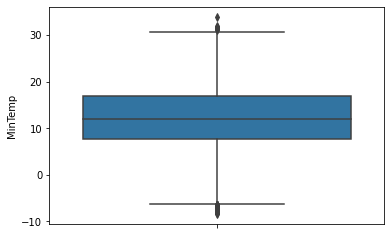

In [38]:
# Check for outliers with boxplot 
sns.boxplot(y = weather_df['MinTemp'])

In [39]:
# Define a function to identify outliers for numerical features
def isolate_outlier(df, feature):
    Q1 = feature.quantile(0.25)
    Q3 = feature.quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1 - 1.5 * IQR
    upper_whisker = Q3 + 1.5 * IQR
    print("lower_whisker: ", lower_whisker, "upper_whisker: ", upper_whisker)
    outliers = df[(feature < lower_whisker) | (feature > upper_whisker)]
    return outliers

In [40]:
# Identify outliers
isolate_outlier(weather_df, weather_df['MinTemp'])

lower_whisker:  -6.35 upper_whisker:  30.849999999999998


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season
46848,2011-05-15,Canberra,-6.9,14.0,0.0,4.0,8.5,NNW,30.0,NNW,NNW,6.0,15.0,84.0,41.0,1030.1,1027.7,0.0,NaN,1.7,13.1,No,No,5,2011,Autumn
46849,2011-05-16,Canberra,-6.5,11.1,0.0,2.0,4.1,N,15.0,NaN,SSW,0.0,7.0,NaN,66.0,1031.5,1028.1,8.0,0.0,0.8,9.5,No,No,5,2011,Autumn
46923,2011-07-29,Canberra,-8.0,15.1,0.2,2.6,7.9,NaN,NaN,NNW,NW,6.0,13.0,96.0,33.0,1029.6,1025.3,1.0,NaN,-1.2,14.5,No,No,7,2011,Winter
46924,2011-07-30,Canberra,-6.7,15.7,0.0,1.4,6.9,NW,37.0,N,NW,2.0,24.0,86.0,31.0,1026.3,1022.0,4.0,1.0,0.5,15.1,No,No,7,2011,Winter
47293,2012-08-02,Canberra,-6.6,12.5,0.0,2.0,6.2,NNW,31.0,NaN,N,0.0,17.0,NaN,49.0,1023.4,1018.8,1.0,NaN,1.1,10.3,No,No,8,2012,Winter
47323,2012-09-01,Canberra,-6.8,14.5,5.8,NaN,8.6,S,48.0,NNE,S,7.0,24.0,NaN,34.0,1023.5,1021.6,1.0,4.0,2.0,12.7,Yes,No,9,2012,Spring
47967,2014-08-05,Canberra,-7.6,13.8,0.2,NaN,NaN,NNW,22.0,SW,NNW,4.0,15.0,87.0,30.0,1034.2,1031.6,NaN,NaN,1.0,12.8,No,No,8,2014,Winter
47968,2014-08-06,Canberra,-6.8,13.8,0.0,NaN,NaN,N,39.0,NaN,N,0.0,26.0,89.0,62.0,1033.6,1028.2,NaN,NaN,1.2,12.2,No,No,8,2014,Winter
48268,2015-06-02,Canberra,-7.0,11.7,0.0,NaN,NaN,SSE,35.0,NE,W,4.0,13.0,82.0,44.0,1026.2,1023.8,NaN,NaN,0.7,11.1,No,No,6,2015,Winter
48270,2015-06-04,Canberra,-6.9,11.4,0.0,NaN,NaN,N,37.0,NaN,NNW,0.0,26.0,93.0,46.0,1022.8,1018.3,NaN,NaN,-0.6,10.2,No,No,6,2015,Winter


***

<span style="color:blue"> ***How to deal with outliers?*** </span>

In general, here is my simplified approach to deal with outliers. 
- Obviously bad/ erroneous data or wrong calculation: either delete or correct it (preferred, but would require some domain knowledge) 
- Unusual but might indicate some interesting observation: retain it 

There is also another approach that is worth to take note. Dealing with outliers depends on what the prediction model to do. This normally involves making a trade-off between model accuracy and model scope. Specifically, it is a choice between:
1. Eliminating outliers to obtain a very accurate model that covers a kind of wide range of weather scenarios, or
2. Retaining the outliers to obtain a kind of accurate model that covers a very wide range of weather scenarios.

Typically, the first option is more ideal if better predictions are what we want afterall. Therefore, the common approach to deal with outliers is to filter out by either clipping attributes at a computed percentile (e.g. 99%) or applying a fixed threshold based on the normal value range. </span>

***

In this case, after observing the outliers and validating it with real-life observations, the usually high or low MinTemp is perfectly normal and simply reflect different extremes across locations (e.g. Canberra can get really cold during winter while Uluru's MinTemp might still be relatively warm during summer). Additionally, I want to predict RainTomorrow across a very wide range of weather scenarios and locations. Thus, it makes sense to retain the outliers. 

As I have obtained a rough understanding about the data properties and data quality of this feature, the next step is to explore the predictive power of this feature towards the label (i.e. RainTomorrow). To do that, I will conduct bivariate analysis with graphical and statistical analysis. 

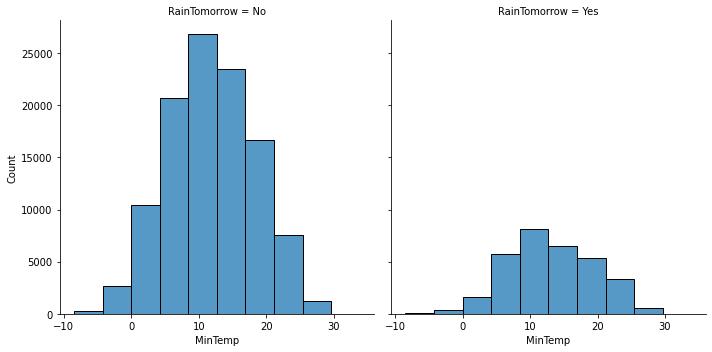

In [41]:
# Plot distribution with histogram
sns.displot(weather_df, x = 'MinTemp', col = 'RainTomorrow', bins = 10)

<AxesSubplot:xlabel='RainTomorrow', ylabel='MinTemp'>

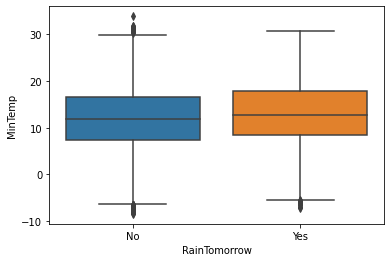

In [42]:
sns.boxplot(x = weather_df['RainTomorrow'], y = weather_df['MinTemp'])

To better understand the predictive power of MinTemp (a numerical value) on RainTomorrow (a categorical value), I plan to conduct the two-sample t-test. The aim is to check whether there is statistically difference between the mean MinTemp of 2 populations of RainTomorrow = Yes and RainTomorrow = No.

However, before conducting the two-sample t-test, I need to check whether the dataset fulfils the two-sample t-test assumptions.
1. Data values must be independent. Measurements for one observation do not affect measurements for any other observation. 
2. Data in each group must be obtained via a random sample from the population. 
3. Data in each group are normally distributed. 
4. Data values are continuous. 
5. The variances for the two independent groups are equal. 

Background information about daily weather observations indicates assumption 1, 2 and 4 are true. Below is how I conducted the check for assumption 3 and 5.

In [43]:
# Check whether the variances for the 2 groups are equal
weather_df.groupby('RainTomorrow').describe()

MinTemp                                                   \
                 count       mean       std  min  25%   50%   75%   max   
RainTomorrow                                                              
No            109854.0  11.897675  6.398699 -8.5  7.3  11.8  16.5  33.9   
Yes            31702.0  13.186890  6.317971 -7.2  8.5  12.7  17.9  30.7   

               MaxTemp                                                    \
                 count       mean       std  min   25%   50%   75%   max   
RainTomorrow                                                               
No            110049.0  23.836247  7.059825 -4.8  18.6  23.3  28.8  48.1   
Yes            31822.0  21.119100  6.911485 -4.1  16.1  20.2  25.8  46.8   

              Rainfall                                                  \
                 count      mean        std  min  25%  50%  75%    max   
RainTomorrow                                                             
No            109586.0  1.270290   5.332200  0.0  0.0  0.0  0.2  240.0   
Yes            31201.0  6.142104  14.318292  0.0  0.0  0.8  6.2  371.0   

             Evaporation                                                 \
                   count      mean       std  min  25%  50%  75%    max   
RainTomorrow                                                              
No               63491.0  5.734807  4.332891  0.0  2.8  5.0  7.6  145.0   
Yes              17859.0  4.527779  3.469052  0.0  2.2  3.8  6.2   74.8   

             Sunshine                                                 \
                count      mean       std  min  25%  50%   75%   max   
RainTomorrow                                                           
No            57556.0  8.546358  3.380298  0.0  6.6  9.4  11.0  14.5   
Yes           16821.0  4.471761  3.359329  0.0  1.4  4.3   7.1  13.9   

             WindGustSpeed                                               \
                     count       mean        std  min   25%   50%   75%   
RainTomorrow                                                              
No                103488.0  38.288391  12.406522  6.0  30.0  37.0  44.0   
Yes                29435.0  45.946764  15.717954  7.0  35.0  44.0  56.0   

                    WindSpeed9am                                             \
                max        count       mean       std  min  25%   50%   75%   
RainTomorrow                                                                  
No            126.0     109308.0  13.567314  8.627578  0.0  7.0  13.0  19.0   
Yes           135.0      31537.0  15.508577  9.607733  0.0  9.0  15.0  20.0   

                    WindSpeed3pm                                              \
                max        count       mean       std  min   25%   50%   75%   
RainTomorrow                                                                   
No            130.0     108369.0  18.222804  8.455466  0.0  13.0  17.0  24.0   
Yes            87.0      31194.0  20.078509  9.781914  0.0  13.0  19.0  26.0   

                   Humidity9am                                               \
               max       count       mean        std  min   25%   50%   75%   
RainTomorrow                                                                  
No            83.0    109076.0  66.217573  19.020703  0.0  55.0  67.0  80.0   
Yes           87.0     31343.0  77.983314  16.108377  5.0  68.0  80.0  91.0   

                    Humidity3pm                                               \
                max       count       mean        std  min   25%   50%   75%   
RainTomorrow                                                                   
No            100.0    107670.0  46.510625  18.489476  0.0  33.0  47.0  60.0   
Yes           100.0     30913.0  68.800019  19.037409  1.0  57.0  70.0  84.0   

                    Pressure9am                                                \
                max       count         mean       std    min     25%     50%   
RainTomorrow      

Since the standard deviations are similar (6.40 and 6.32), I conclude that the variances are equal. 

*On a side note, if the data does not fulfill the assumption of equal variances, we can use Welch's t-test instead of Student's t-test. Below are the Welch t-test assumptions that the data must meet in order for the test results to be valid.* 
1. The independent variable (IV) is categorical with at least two levels (groups)
2. The dependent variable (DV) is continuous which is measured on an interval or ratio scale
3. The distribution of the two groups should follow the normal distribution

Next, I will test for normality (i.e. normal distribution) with the Shapiro-Wilk test. The null hypothesis of this test is that the population is normally distributed. I choose the alpha level at 0.05. Therefore, I will reject the null hypothesis if the p value is less than 0.05. 

If both groups have p-value greater than 0.05, I will conclude that both groups are normally distributed and I can proceed with the two-sample t-test. 

There are other tests for normality, including Kolmogorov-Smirnov test and the Anderson-Darling test. However, I decided to go with Shapiro-Wilk because Monte Carlo simulation has found that Shapiro-Wilk has the best power for a given significance. 

In [44]:
# Define a function to check whether numerical data in each group are normally distributed with Shapiro-Wilk test

def normal_distribution_test(df, num_feature):
    
    # Step 1: Subset the num_feature into 2 groups (Yes or No for RainTomorrow)
    yes = df.query('RainTomorrow =="Yes"')[num_feature]
    no = df.query('RainTomorrow =="No"')[num_feature]
    
    # Step 2: Perform the Shapiro-Wilk test on both groups
    yes_shapiro_pvalue = stats.shapiro(yes)[1]
    no_shapiro_pvalue = stats.shapiro(no)[1]
    
    # Step 3: Compare p-value with the chosen significance value of 0.05. 
    if yes_shapiro_pvalue > 0.05 and no_shapiro_pvalue > 0.05:
        verdict = "Both groups are normally distributed"
    else: 
        verdict = "Both group are NOT normally distributed"
    
    # Step 4: Convert yes and no from a single-column dataframe to a series
    yes = yes.squeeze()
    no = no.squeeze()
    return yes, no, verdict

In [45]:
yes, no, verdict = normal_distribution_test(weather_df, ['MinTemp'])
verdict

'Both groups are normally distributed'

In [46]:
# Use two-sample t-test to check for dependence
res = stats.ttest_ind(yes, no, equal_var = True, nan_policy = 'omit')
display(res)

Ttest_indResult(statistic=31.691561759948286, pvalue=1.2001362586761526e-219)

At 95% level of confidence, since p-value is smaller than the threshold of 5%, I reject the null hypothesis of equal averages. Therefore, MinTemp and RainTomorrow are dependent. I will consider MinTemp as a relevant feature for the model. 

#### MaxTemp

In [47]:
# Check for missing values
null_maxtemp = weather_df[weather_df['MaxTemp'].isnull()]
null_maxtemp

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season
283,2009-09-10,Albury,2.6,NaN,0.0,NaN,NaN,NaN,NaN,E,WNW,6.0,13.0,71.0,55.0,1017.8,1017.6,NaN,6.0,9.7,14.3,No,NaN,9,2009,Spring
452,2010-02-26,Albury,17.2,NaN,0.0,NaN,NaN,NaN,NaN,NE,E,13.0,9.0,54.0,28.0,1024.6,1020.7,NaN,NaN,20.6,29.2,No,NaN,2,2010,Summer
455,2010-03-01,Albury,14.4,NaN,0.0,NaN,NaN,NaN,NaN,SE,SSE,19.0,20.0,50.0,35.0,1018.5,1016.2,6.0,NaN,17.1,25.5,No,NaN,3,2010,Autumn
458,2010-03-04,Albury,15.1,NaN,0.0,NaN,NaN,NaN,NaN,SE,S,7.0,11.0,70.0,35.0,1014.2,1009.8,NaN,NaN,20.1,28.6,No,No,3,2010,Autumn
464,2010-03-10,Albury,8.8,NaN,0.0,NaN,NaN,NaN,NaN,SSE,SSE,9.0,11.0,69.0,35.0,1023.7,1023.0,NaN,1.0,12.5,21.8,No,NaN,3,2010,Autumn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144260,2014-03-14,Uluru,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2014,Autumn
144306,2014-04-29,Uluru,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SSE,NaN,22.0,NaN,62.0,1016.3,1017.3,NaN,NaN,NaN,18.3,NaN,NaN,4,2014,Autumn
144307,2014-04-30,Uluru,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESE,NaN,17.0,NaN,40.0,NaN,1017.5,NaN,NaN,NaN,21.5,NaN,NaN,4,2014,Autumn
145335,2017-02-21,Uluru,13.5,NaN,0.0,NaN,NaN,NaN,NaN,ENE,SW,24.0,7.0,23.0,11.0,1013.7,1008.4,NaN,NaN,25.2,34.4,No,NaN,2,2017,Summer


In [48]:
# Check for distribution of missing MaxTemp
null_maxtemp_freq = pd.crosstab(null_maxtemp['Year'], null_maxtemp['Location'])
null_maxtemp_freq

Location,Adelaide,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MountGambier,MountGinini,Newcastle,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,Portland,Richmond,Sale,SalmonGums,Sydney,Townsville,Tuggeranong,Uluru,Walpole,Williamtown,Witchcliffe,Wollongong,Woomera
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,2,0
2009,0,0,1,0,0,0,0,0,1,0,2,63,0,1,0,0,1,0,0,23,21,0,8,0,6,5,1,0,1,0,0,3,2,0,0,0,15,0,2,2,0
2010,0,0,4,0,4,0,1,1,2,0,0,0,0,0,0,0,1,0,0,18,33,0,12,0,2,9,14,0,0,0,0,33,0,0,2,0,2,0,2,4,0
2011,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,19,0,1,0,0,1,5,0,0,0,1,0,0,0,0,0,11,1,0,0,1
2012,0,2,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,7,23,0,1,0,0,2,1,0,0,0,0,2,0,0,1,0,3,0,1,2,0
2013,0,2,1,0,1,0,0,2,0,0,0,0,0,0,0,8,1,0,0,2,25,0,2,0,0,2,0,0,0,4,0,1,0,0,0,0,1,0,0,0,1
2014,0,5,2,0,3,0,0,1,0,1,13,0,0,0,0,3,0,0,0,0,21,6,5,0,0,0,0,0,0,9,0,1,0,0,0,5,1,2,0,0,0
2015,1,7,0,1,3,0,0,4,0,0,0,0,0,0,0,8,0,360,0,0,25,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2016,0,24,0,0,18,1,0,1,0,0,3,0,0,4,0,10,0,121,1,0,41,0,0,0,0,1,3,0,0,1,0,0,0,0,0,0,5,0,0,1,0


In [49]:
null_maxtemp.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Month,Year
count,396.000000,0.0,470.000000,645.000000,614.000000,562.000000,886.000000,781.000000,379.000000,257.000000,247.000000,245.000000,282.000000,154.000000,387.000000,262.000000,1261.000000,1261.000000
mean,13.049242,NaN,3.366596,5.483411,7.015798,44.768683,15.589165,20.417414,72.949868,57.894942,1016.538057,1014.074694,4.485816,4.662338,17.730749,21.595420,5.896114,2013.544013
std,6.639023,NaN,13.005417,3.431126,3.989472,14.979602,11.086637,9.799262,16.893539,21.054446,7.418961,7.437875,2.899530,2.710958,6.729624,6.984261,3.562747,2.674810
min,-5.900000,NaN,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,17.000000,8.000000,991.400000,992.900000,0.000000,0.000000,-4.900000,-3.300000,1.000000,2008.000000
25%,8.475000,NaN,0.000000,2.800000,3.600000,33.000000,7.000000,13.000000,63.500000,45.000000,1012.150000,1008.400000,1.000000,2.000000,12.850000,17.100000,3.000000,2011.000000
50%,13.200000,NaN,0.000000,5.000000,7.550000,43.000000,13.000000,20.000000,74.000000,59.000000,1016.600000,1014.300000,5.000000,5.000000,18.000000,21.000000,5.000000,2015.000000
75%,18.000000,NaN,0.800000,7.200000,10.475000,54.000000,22.000000,28.000000,86.000000,72.000000,1021.300000,1019.800000,7.000000,7.000000,22.800000,25.675000,9.000000,2016.000000
max,28.000000,NaN,216.300000,20.800000,13.800000,122.000000,57.000000,65.000000,100.000000,100.000000,1038.600000,1035.400000,8.000000,8.000000,35.300000,41.100000,12.000000,2017.000000


After analysing the distribution across Location, Month and assessing for any potential correlation with other numerical features, I did not find any patterns for missing values. Therefore, I concluded that MaxTemp has missing values randomly. 

To deal with the 1,261 missing values, I will impute the missing values with forward fill method.

<AxesSubplot:ylabel='MaxTemp'>

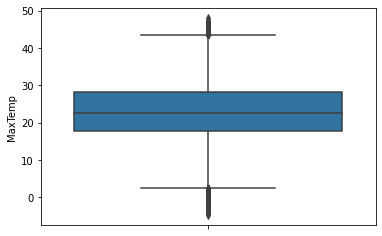

In [50]:
# Check for outliers with boxplot 
sns.boxplot(y = weather_df['MaxTemp'])

In [51]:
# Identify outliers
isolate_outlier(weather_df, weather_df['MaxTemp'])

lower_whisker:  2.4499999999999975 upper_whisker:  43.65


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season
68,2009-02-07,Albury,22.3,44.8,0.0,NaN,NaN,NNW,59.0,SE,NW,9.0,33.0,36.0,11.0,1008.2,1003.8,NaN,NaN,29.6,43.4,No,No,2,2009,Summer
2904,2017-02-10,Albury,23.0,43.7,0.0,NaN,NaN,WSW,44.0,SSE,W,7.0,30.0,67.0,17.0,1009.9,1006.1,NaN,NaN,28.2,42.4,No,No,2,2017,Summer
4457,2013-01-18,BadgerysCreek,19.3,45.8,0.0,NaN,NaN,WNW,80.0,N,W,6.0,20.0,65.0,15.0,1003.0,997.7,NaN,NaN,27.3,43.7,No,No,1,2013,Summer
5885,2017-01-13,BadgerysCreek,20.6,45.1,0.0,NaN,NaN,NW,56.0,NNE,NNE,15.0,13.0,69.0,27.0,1008.3,999.3,NaN,NaN,25.6,41.0,No,No,1,2017,Summer
5890,2017-01-18,BadgerysCreek,23.0,44.4,0.0,NaN,NaN,WNW,52.0,WNW,ESE,30.0,30.0,30.0,48.0,1005.6,1005.8,NaN,NaN,37.6,30.9,No,No,1,2017,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144530,2014-12-09,Uluru,26.0,43.8,0.0,NaN,NaN,SSW,69.0,NW,NW,19.0,24.0,31.0,14.0,1007.4,1004.1,NaN,NaN,33.1,42.2,No,No,12,2014,Summer
144535,2014-12-14,Uluru,21.4,44.0,0.0,NaN,NaN,NNW,41.0,N,W,17.0,20.0,13.0,7.0,1007.8,1003.0,1.0,1.0,33.8,42.6,No,No,12,2014,Summer
144572,2015-01-20,Uluru,28.6,43.7,0.0,NaN,NaN,WSW,48.0,WSW,SSW,31.0,26.0,27.0,8.0,1007.2,1005.3,NaN,NaN,36.4,42.2,No,No,1,2015,Summer
144858,2015-11-02,Uluru,26.4,43.7,0.0,NaN,NaN,WNW,69.0,NE,NW,30.0,35.0,20.0,7.0,1005.8,1000.3,NaN,NaN,32.7,41.4,No,No,11,2015,Spring


In this case, after observing the outliers and validating it with real-life observations, the usually high or low MaxTemp is perfectly normal and simply reflect different extremes across locations (e.g. Cobar and Badgerys Creek can get scorching hot during summers). Additionally, I want to predict RainTomorrow across a very wide range of weather scenarios and locations. Thus, it makes sense to retain the outliers. 

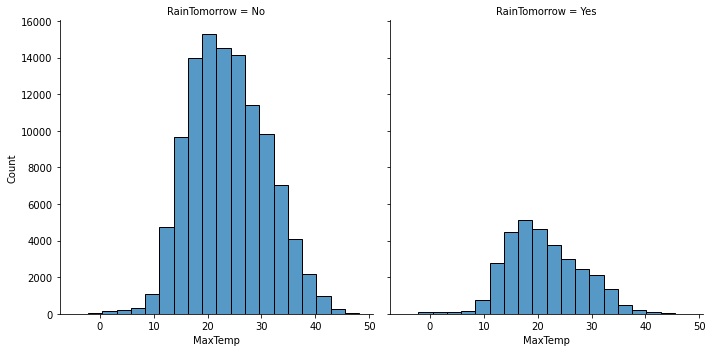

In [52]:
# Plot distribution with histogram
sns.displot(weather_df, x = 'MaxTemp', col = 'RainTomorrow', bins = 20)

<AxesSubplot:xlabel='RainTomorrow', ylabel='MaxTemp'>

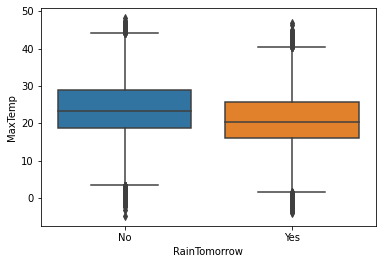

In [53]:
sns.boxplot(x = weather_df['RainTomorrow'], y = weather_df['MaxTemp'])

Similar to MinTemp, I would attempt to assess the predictive power of MaxTemp on RainTomorrow with two-sample t-test. Earlier calculation has shown both groups have approximately equal variances. Hence, I only checked for normal distribution assumption before conducting the t-test. 

In [54]:
yes, no, verdict = normal_distribution_test(weather_df, ['MaxTemp'])
verdict

'Both groups are normally distributed'

In [55]:
# Use two-sample t-test to check for dependence
res = stats.ttest_ind(yes, no, equal_var = True, nan_policy = 'omit')
display(res)

Ttest_indResult(statistic=-60.752462797949775, pvalue=0.0)

At 95% level of confidence, since p-value is smaller than the threshold of 5%, I reject the null hypothesis of equal averages. Therefore, MaxTemp and RainTomorrow are dependent. I will consider MaxTemp as a relevant feature for the model. 

#### Temp9am

In [56]:
# Check for missing values
null_temp9am = weather_df[weather_df['Temp9am'].isnull()]
null_temp9am

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season
984,2011-09-11,Albury,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,2011,Spring
985,2011-09-12,Albury,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,2011,Spring
986,2011-09-13,Albury,NaN,15.8,NaN,NaN,NaN,NaN,NaN,NaN,NNW,NaN,9.0,NaN,47.0,NaN,1023.9,NaN,5.0,NaN,15.1,NaN,NaN,9,2011,Spring
1566,2013-06-13,Albury,10.0,13.4,16.8,NaN,NaN,WNW,28.0,N,W,7.0,13.0,NaN,93.0,1007.1,1005.5,8.0,8.0,NaN,12.3,Yes,Yes,6,2013,Winter
1909,2014-05-22,Albury,8.5,18.9,0.2,NaN,NaN,SE,19.0,W,SE,2.0,13.0,NaN,72.0,1023.5,1019.0,8.0,4.0,NaN,18.5,No,No,5,2014,Autumn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144312,2014-05-05,Uluru,NaN,26.2,NaN,NaN,NaN,NNE,35.0,NE,E,9.0,13.0,NaN,29.0,1020.9,1016.9,NaN,NaN,NaN,25.0,NaN,NaN,5,2014,Autumn
144315,2014-05-08,Uluru,NaN,28.5,NaN,NaN,NaN,NNW,28.0,NE,N,13.0,19.0,NaN,28.0,1018.3,1014.1,NaN,NaN,NaN,27.6,NaN,NaN,5,2014,Autumn
144316,2014-05-09,Uluru,NaN,28.3,NaN,NaN,NaN,NNW,39.0,SW,WNW,4.0,17.0,NaN,26.0,1015.8,1012.5,1.0,NaN,NaN,27.7,NaN,NaN,5,2014,Autumn
144331,2014-05-24,Uluru,8.5,29.1,NaN,NaN,NaN,N,24.0,NaN,W,NaN,11.0,NaN,27.0,NaN,1015.4,NaN,NaN,NaN,28.6,NaN,No,5,2014,Autumn


In [57]:
# Check for distribution of missing MaxTemp
null_temp9am_freq = pd.crosstab(null_temp9am['Year'], null_temp9am['Location'])
null_temp9am_freq

Location,Adelaide,Albany,Albury,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,GoldCoast,Hobart,Katherine,Launceston,Melbourne,Mildura,MountGambier,MountGinini,Newcastle,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Portland,Richmond,Sale,SalmonGums,Sydney,SydneyAirport,Tuggeranong,Uluru,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0
2009,1,0,0,3,0,0,0,0,2,3,0,65,0,0,0,2,0,0,0,84,20,0,15,1,1,1,5,8,2,1,0,1,0,2,0,13,0,0,1,2,0
2010,0,0,0,16,0,1,1,0,3,0,0,0,0,1,0,0,1,0,0,61,34,0,15,0,1,7,26,21,8,0,35,2,0,9,0,0,0,1,1,23,0
2011,0,0,3,0,4,0,0,0,6,0,0,0,0,0,0,0,0,0,0,101,21,0,0,1,2,5,6,17,1,0,0,0,0,0,0,9,0,0,0,0,0
2012,1,1,0,0,2,1,1,0,3,0,0,0,0,0,0,0,0,0,0,124,30,0,0,0,0,1,0,2,9,0,1,1,0,1,0,0,0,0,0,1,0
2013,0,2,1,0,6,0,0,0,3,0,2,0,0,0,9,2,0,1,1,34,26,0,3,0,1,0,0,0,8,0,0,0,0,7,1,5,5,3,0,0,1
2014,0,6,5,2,0,0,1,0,0,3,12,0,0,0,6,0,0,0,0,3,21,5,6,0,0,2,0,0,11,1,0,1,0,1,13,0,8,1,2,0,0
2015,2,5,0,4,0,0,1,0,1,0,1,0,0,0,6,0,359,0,0,0,22,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2016,0,10,0,16,0,0,0,1,0,0,0,0,1,0,11,0,121,0,0,0,37,0,0,2,0,2,2,0,1,0,0,0,0,0,1,1,0,0,0,0,0


After analysing the distribution across Location, Month and assessing for any potential correlation with other numerical features, I did not find any patterns for missing values. Therefore, I concluded that Temp9am has missing values randomly. 

To deal with the 1,261 missing values, I will impute the missing values with forward fill method.

<AxesSubplot:ylabel='Temp9am'>

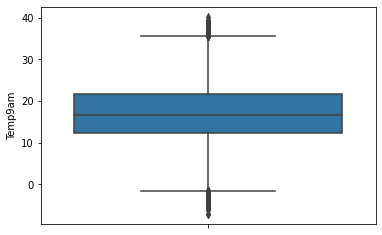

In [58]:
# Check for outliers with boxplot 
sns.boxplot(y = weather_df['Temp9am'])

In [59]:
# Identify outliers
isolate_outlier(weather_df, weather_df['Temp9am'])

lower_whisker:  -1.6500000000000004 upper_whisker:  35.550000000000004


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season
5890,2017-01-18,BadgerysCreek,23.0,44.4,0.0,NaN,NaN,WNW,52.0,WNW,ESE,30.0,30.0,30.0,48.0,1005.6,1005.8,NaN,NaN,37.6,30.9,No,No,1,2017,Summer
6085,2009-02-06,Cobar,29.1,43.5,0.0,13.0,12.1,WNW,28.0,NNW,NNW,9.0,13.0,25.0,16.0,1007.5,1005.2,1.0,2.0,35.6,41.4,No,No,2,2009,Summer
6372,2009-11-20,Cobar,28.8,45.4,0.0,17.0,8.8,N,56.0,N,N,15.0,15.0,13.0,6.0,1008.2,1004.4,1.0,6.0,37.3,43.3,No,No,11,2009,Spring
6804,2011-01-26,Cobar,25.7,44.3,0.0,12.0,NaN,WNW,39.0,N,W,17.0,22.0,21.0,14.0,1009.9,1008.9,1.0,5.0,35.7,43.2,No,No,1,2011,Summer
7466,2013-01-18,Cobar,29.4,43.8,0.0,13.6,NaN,WNW,52.0,NW,WNW,19.0,20.0,22.0,14.0,1004.4,1001.5,3.0,7.0,37.7,42.9,No,No,1,2013,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143417,2016-03-18,Katherine,25.5,37.5,0.0,5.8,NaN,S,33.0,W,ESE,11.0,7.0,61.0,NaN,1008.2,1003.5,5.0,NaN,36.5,NaN,No,No,3,2016,Autumn
144188,2014-01-01,Uluru,24.7,44.4,0.0,NaN,NaN,W,54.0,ENE,NW,4.0,24.0,26.0,15.0,1007.5,1003.8,NaN,NaN,36.0,42.0,No,No,1,2014,Summer
144504,2014-11-13,Uluru,23.4,43.0,0.0,NaN,NaN,NW,85.0,NNE,NW,19.0,33.0,6.0,9.0,1007.2,1002.4,NaN,1.0,35.6,41.5,No,Yes,11,2014,Spring
144572,2015-01-20,Uluru,28.6,43.7,0.0,NaN,NaN,WSW,48.0,WSW,SSW,31.0,26.0,27.0,8.0,1007.2,1005.3,NaN,NaN,36.4,42.2,No,No,1,2015,Summer


In this case, after observing the outliers and validating it with real-life observations, the outliers are perfectly normal and simply reflect different extremes across locations. Additionally, I want to predict RainTomorrow across a very wide range of weather scenarios and locations. Thus, it makes sense to retain the outliers. 

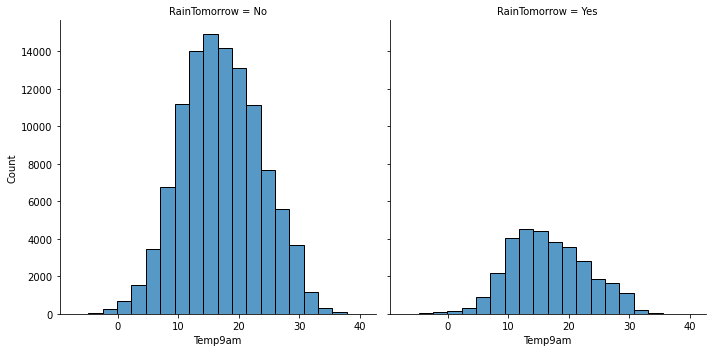

In [60]:
# Plot distribution with histogram
sns.displot(weather_df, x = 'Temp9am', col = 'RainTomorrow', bins = 20)

<AxesSubplot:xlabel='RainTomorrow', ylabel='Temp9am'>

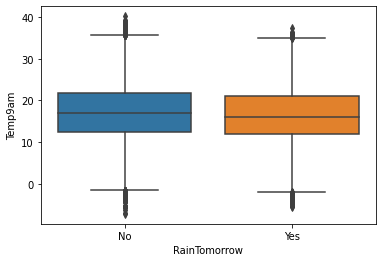

In [61]:
sns.boxplot(x = weather_df['RainTomorrow'], y = weather_df['Temp9am'])

Earlier calculation has shown both groups have approximately equal variances. Hence, I only checked for normal distribution assumption before conducting the t-test to assess the predictive power of Temp9am on RainTomorrow. 

In [62]:
yes, no, verdict = normal_distribution_test(weather_df, ['Temp9am'])
verdict

'Both groups are normally distributed'

In [63]:
# Use two-sample t-test to check for dependence
res = stats.ttest_ind(yes, no, equal_var = True, nan_policy = 'omit')
display(res)

Ttest_indResult(statistic=-9.659896665252676, pvalue=4.533895223656774e-22)

At 95% level of confidence, since p-value is smaller than the threshold of 5%, I reject the null hypothesis of equal averages. Therefore, Temp9am and RainTomorrow are dependent. I will consider Temp9am as a relevant feature for the model. 

#### Temp3pm

In [64]:
# Check for missing values
null_temp3pm = weather_df[weather_df['Temp3pm'].isnull()]
null_temp3pm

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season
984,2011-09-11,Albury,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,2011,Spring
985,2011-09-12,Albury,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,2011,Spring
1058,2011-11-24,Albury,10.8,26.0,0.0,NaN,NaN,NaN,NaN,SE,NaN,19.0,NaN,44.0,NaN,1024.5,NaN,NaN,NaN,17.2,NaN,No,Yes,11,2011,Spring
1059,2011-11-25,Albury,15.0,20.0,11.0,NaN,NaN,NaN,NaN,SSE,NaN,11.0,NaN,99.0,NaN,1020.1,NaN,8.0,NaN,15.0,NaN,Yes,Yes,11,2011,Spring
1060,2011-11-26,Albury,15.0,25.0,44.0,NaN,NaN,NaN,NaN,NE,NaN,13.0,NaN,83.0,NaN,1006.2,NaN,3.0,NaN,20.0,NaN,Yes,Yes,11,2011,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143881,2017-06-25,Katherine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,E,9.0,17.0,NaN,NaN,1014.9,1011.7,NaN,NaN,NaN,NaN,NaN,NaN,6,2017,Winter
144203,2014-01-16,Uluru,24.0,30.4,0.4,NaN,NaN,NE,50.0,ENE,NaN,20.0,NaN,74.0,NaN,1006.4,NaN,NaN,NaN,25.4,NaN,No,Yes,1,2014,Summer
144242,2014-02-24,Uluru,18.4,NaN,0.0,NaN,NaN,NaN,NaN,ESE,NaN,22.0,NaN,23.0,NaN,1014.1,NaN,NaN,NaN,24.9,NaN,No,NaN,2,2014,Summer
144260,2014-03-14,Uluru,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2014,Autumn


In [65]:
# Check for distribution of missing MaxTemp
null_temp3pm_freq = pd.crosstab(null_temp3pm['Year'], null_temp3pm['Location'])
null_temp3pm_freq

Location,Adelaide,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,Mildura,MountGambier,MountGinini,Newcastle,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,PerthAirport,Portland,Richmond,Sale,SalmonGums,Sydney,SydneyAirport,Tuggeranong,Uluru,Walpole,Williamtown,Witchcliffe,Wollongong,Woomera
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,7,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
2009,1,3,0,0,6,0,0,2,1,0,0,64,0,0,0,0,4,0,0,1,106,36,0,11,0,2,4,5,0,1,0,2,0,0,0,0,1,0,12,1,0,2,0
2010,1,1,0,1,15,1,0,3,1,1,1,0,0,0,0,0,1,0,0,0,48,48,0,12,0,0,6,8,0,0,6,5,0,34,4,0,11,0,0,0,0,22,2
2011,0,0,6,0,3,4,1,2,2,0,0,0,1,0,0,0,0,1,0,2,52,36,0,1,0,0,2,3,1,0,6,1,1,0,0,0,0,0,9,0,1,1,0
2012,0,3,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,73,44,0,0,0,3,5,0,0,0,0,18,0,2,0,0,1,0,1,0,1,2,0
2013,0,2,1,0,0,1,0,1,1,0,3,0,1,0,0,13,2,1,1,1,9,31,0,2,0,1,2,0,0,0,0,4,0,0,0,0,0,0,3,1,0,0,0
2014,0,4,1,0,2,0,0,2,2,4,10,0,0,0,0,11,0,1,0,0,0,26,5,5,0,0,4,0,0,0,0,10,0,0,0,0,0,4,1,0,0,0,0
2015,2,156,0,0,3,0,0,3,0,0,0,0,0,0,1,158,0,360,0,0,0,166,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2016,0,366,0,0,15,0,0,0,0,0,0,0,0,1,0,366,0,121,0,1,0,366,0,0,0,1,3,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


After analysing the distribution across Location, Month and assessing for any potential correlation with other numerical features, I did not find any patterns for missing values. Therefore, I concluded that Temp3pm has missing values randomly. 

To deal with the 3609 missing values, I will impute the missing values with forward fill method. 

<AxesSubplot:ylabel='Temp3pm'>

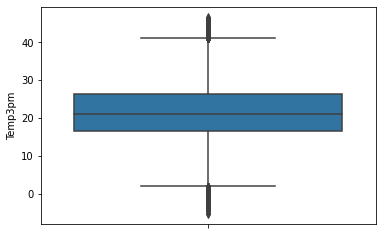

In [66]:
# Check for outliers with boxplot 
sns.boxplot(y = weather_df['Temp3pm'])

In [67]:
# Identify outliers
isolate_outlier(weather_df, weather_df['Temp3pm'])

lower_whisker:  1.9000000000000057 upper_whisker:  41.099999999999994


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season
44,2009-01-14,Albury,17.4,43.0,0.0,NaN,NaN,NW,39.0,SSE,SSW,7.0,17.0,40.0,8.0,1011.6,1006.9,NaN,NaN,25.6,41.5,No,No,1,2009,Summer
60,2009-01-30,Albury,22.3,42.9,0.0,NaN,NaN,NNE,28.0,ESE,SE,9.0,11.0,37.0,11.0,1014.6,1010.2,NaN,NaN,29.2,41.2,No,No,1,2009,Summer
61,2009-01-31,Albury,22.0,42.7,0.0,NaN,NaN,ESE,48.0,ESE,SW,4.0,4.0,33.0,11.0,1014.2,1010.5,NaN,NaN,29.9,42.0,No,No,1,2009,Summer
62,2009-02-01,Albury,28.0,43.1,0.0,NaN,NaN,SW,83.0,SE,E,15.0,9.0,27.0,9.0,1012.5,1008.7,NaN,NaN,32.4,41.9,No,No,2,2009,Summer
67,2009-02-06,Albury,23.5,42.2,0.0,NaN,NaN,W,37.0,SE,W,6.0,15.0,39.0,8.0,1008.0,1005.0,NaN,NaN,28.7,41.6,No,No,2,2009,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144858,2015-11-02,Uluru,26.4,43.7,0.0,NaN,NaN,WNW,69.0,NE,NW,30.0,35.0,20.0,7.0,1005.8,1000.3,NaN,NaN,32.7,41.4,No,No,11,2015,Spring
144875,2015-11-19,Uluru,20.5,42.9,0.0,NaN,NaN,WNW,50.0,N,N,17.0,19.0,7.0,4.0,1012.8,1008.4,NaN,NaN,34.9,41.1,No,No,11,2015,Spring
144891,2015-12-05,Uluru,20.0,44.1,0.0,NaN,NaN,NNW,57.0,NE,N,24.0,24.0,9.0,10.0,1010.5,1005.3,NaN,2.0,36.1,41.5,No,No,12,2015,Summer
145253,2016-12-01,Uluru,20.1,42.2,0.0,NaN,NaN,WNW,54.0,NE,WNW,9.0,24.0,19.0,8.0,1006.4,1002.1,NaN,3.0,33.2,41.1,No,No,12,2016,Summer


In this case, after observing the outliers and validating it with real-life observations, the outliers are perfectly normal and simply reflect different extremes across locations. Additionally, I want to predict RainTomorrow across a very wide range of weather scenarios and locations. Thus, it makes sense to retain the outliers. 

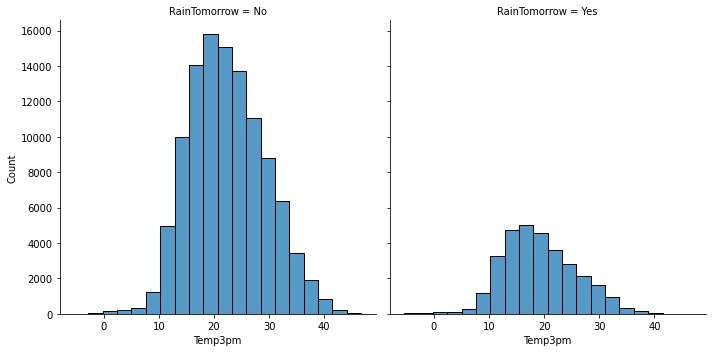

In [68]:
# Plot distribution with histogram
sns.displot(weather_df, x = 'Temp3pm', col = 'RainTomorrow', bins = 20)

<AxesSubplot:xlabel='RainTomorrow', ylabel='Temp3pm'>

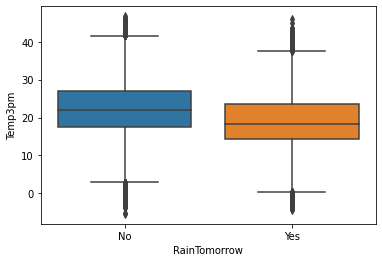

In [69]:
sns.boxplot(x = weather_df['RainTomorrow'], y = weather_df['Temp3pm'])

Earlier calculation has shown both groups have approximately equal variances. Hence, I only checked for normal distribution assumption before conducting the t-test to assess the predictive power of Temp3pm on RainTomorrow. 

In [70]:
yes, no, verdict = normal_distribution_test(weather_df, ['Temp3pm'])
verdict

'Both groups are normally distributed'

In [71]:
# Use two-sample t-test to check for dependence
res = stats.ttest_ind(yes, no, equal_var = True, nan_policy = 'omit')
display(res)

Ttest_indResult(statistic=-73.22931992056493, pvalue=0.0)

At 95% level of confidence, since p-value is smaller than the threshold of 5%, I reject the null hypothesis of equal averages. Therefore, Temp3pm and RainTomorrow are dependent. I will consider Temp9am as a relevant feature for the model. 

#### Rainfall

In [72]:
# Check for missing values
null_rainfall = weather_df[weather_df['Rainfall'].isnull()]
null_rainfall

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season
15,2008-12-16,Albury,9.8,27.7,NaN,NaN,NaN,WNW,50.0,NaN,WNW,NaN,22.0,50.0,28.0,1013.4,1010.3,0.0,NaN,17.3,26.2,NaN,No,12,2008,Summer
284,2009-09-11,Albury,NaN,18.8,NaN,NaN,NaN,N,31.0,SE,NNE,7.0,19.0,83.0,46.0,1022.2,1018.2,NaN,NaN,8.7,18.1,NaN,No,9,2009,Spring
436,2010-02-10,Albury,21.7,35.6,NaN,NaN,NaN,SSW,46.0,NaN,S,NaN,15.0,64.0,28.0,1018.8,1014.7,NaN,4.0,25.2,32.9,NaN,No,2,2010,Summer
438,2010-02-12,Albury,22.5,29.1,NaN,NaN,NaN,SW,24.0,NaN,NNW,NaN,11.0,81.0,67.0,1008.5,1007.8,NaN,7.0,23.4,26.4,NaN,No,2,2010,Summer
444,2010-02-18,Albury,NaN,31.2,NaN,NaN,NaN,ESE,31.0,SSE,SSW,7.0,7.0,33.0,24.0,1020.4,1019.1,NaN,NaN,21.0,30.0,NaN,No,2,2010,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144951,2016-02-03,Uluru,20.6,32.6,NaN,NaN,NaN,S,39.0,SE,NE,24.0,13.0,50.0,32.0,1011.5,1008.7,NaN,NaN,22.6,30.0,NaN,No,2,2016,Summer
144956,2016-02-08,Uluru,23.8,38.3,NaN,NaN,NaN,NaN,NaN,ESE,ESE,17.0,26.0,27.0,16.0,1015.2,1010.8,NaN,NaN,30.6,36.1,NaN,No,2,2016,Summer
145092,2016-06-23,Uluru,14.2,18.7,NaN,NaN,NaN,NaN,NaN,W,NaN,9.0,NaN,81.0,67.0,1015.2,1014.6,8.0,8.0,16.6,17.5,NaN,NaN,6,2016,Winter
145093,2016-06-24,Uluru,3.2,17.9,NaN,NaN,NaN,E,44.0,SE,E,11.0,20.0,83.0,39.0,1022.4,1019.0,NaN,NaN,8.8,17.2,NaN,No,6,2016,Winter


In [73]:
# Check for distribution of missing MaxTemp
null_rainfall_freq = pd.crosstab(null_rainfall['Year'], null_rainfall['Location'])
null_rainfall_freq

Location,Adelaide,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,GoldCoast,Hobart,Katherine,Launceston,Melbourne,Mildura,Moree,MountGambier,MountGinini,Newcastle,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Portland,Richmond,Sale,SalmonGums,Sydney,SydneyAirport,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008,18,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0
2009,3,0,1,0,6,0,0,3,0,0,1,1,64,2,0,0,0,0,0,0,0,21,0,0,17,0,1,38,7,0,2,0,1,0,0,0,2,0,0,15,0,1,7,2,0
2010,6,0,7,0,32,1,0,4,0,0,0,0,0,1,0,0,0,0,0,0,0,74,6,0,20,0,0,20,37,1,25,0,35,3,0,0,21,0,0,16,1,13,5,30,2
2011,9,0,5,0,3,6,0,4,0,9,3,0,0,0,1,0,0,54,0,2,0,9,10,0,3,1,0,39,9,3,0,0,0,0,0,1,0,0,0,21,0,72,13,0,5
2012,15,0,1,0,3,0,0,1,1,1,2,2,0,0,0,0,0,75,0,10,0,21,17,0,2,0,0,30,2,2,13,0,2,0,0,0,1,0,0,88,0,74,0,3,0
2013,29,3,4,0,3,1,0,1,0,0,0,1,0,0,0,2,4,72,1,6,0,4,12,0,6,0,2,48,1,1,10,0,0,0,0,0,3,1,0,10,0,82,7,0,2
2014,15,5,5,0,9,2,0,3,3,2,0,21,1,8,2,3,4,77,0,51,0,3,8,7,9,0,0,60,3,2,5,0,2,4,0,0,6,44,0,8,0,104,9,2,0
2015,5,1,0,0,7,0,0,7,0,4,0,31,0,15,2,3,0,359,1,69,0,0,10,1,17,0,1,3,1,1,0,4,2,0,1,0,1,3,0,10,1,79,6,8,0
2016,0,4,0,3,17,2,2,3,48,0,12,0,1,28,0,5,0,121,0,17,3,1,12,1,1,20,2,4,9,3,2,4,2,0,0,3,6,7,10,15,6,31,10,1,9


After analysing the distribution across Location, Month and assessing for any potential correlation with other numerical features, I did not find any patterns for missing values. Therefore, I concluded that Rainfall has missing values randomly. 

To deal with the 3,261 missing values, I will impute the missing values. Similar to temperature-related features, I have 2 options for imputing missing values. 
1. Simple & naive option (but potentially introducing bias): Impute all missing values related to temperature based on each feature's statistical measure (e.g. median)
2. Sophisticated option: Predict the missing values based on time-series 

I will start with the simple & naive option for the first iteration of the prediction model to speed up the process. To avoid overfitting, median rainfall will be calculated based on the training set for imputation on training set, then propagating to the test set. The more sophisticated option could be done during subsequent iterations if necessary. 

<AxesSubplot:ylabel='Rainfall'>

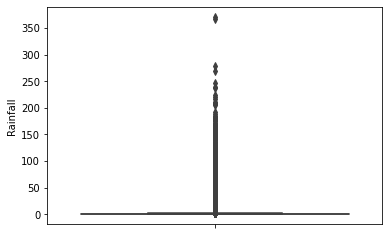

In [74]:
# Check for outliers with boxplot 
sns.boxplot(y = weather_df['Rainfall'])

In [75]:
# Identify outliers
isolate_outlier(weather_df, weather_df['Rainfall'])

lower_whisker:  -1.2000000000000002 upper_whisker:  2.0


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season
11,2008-12-12,Albury,15.9,21.7,2.2,NaN,NaN,NNE,31.0,NE,ENE,15.0,13.0,89.0,91.0,1010.5,1004.2,8.0,8.0,15.9,17.0,Yes,Yes,12,2008,Summer
12,2008-12-13,Albury,15.9,18.6,15.6,NaN,NaN,W,61.0,NNW,NNW,28.0,28.0,76.0,93.0,994.3,993.0,8.0,8.0,17.4,15.8,Yes,Yes,12,2008,Summer
13,2008-12-14,Albury,12.6,21.0,3.6,NaN,NaN,SW,44.0,W,SSW,24.0,20.0,65.0,43.0,1001.2,1001.8,NaN,7.0,15.8,19.8,Yes,No,12,2008,Summer
17,2008-12-18,Albury,13.5,22.9,16.8,NaN,NaN,W,63.0,N,WNW,6.0,20.0,80.0,65.0,1005.8,1002.2,8.0,1.0,18.0,21.5,Yes,Yes,12,2008,Summer
18,2008-12-19,Albury,11.2,22.5,10.6,NaN,NaN,SSE,43.0,WSW,SW,24.0,17.0,47.0,32.0,1009.4,1009.7,NaN,2.0,15.5,21.0,Yes,No,12,2008,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145325,2017-02-11,Uluru,22.2,39.4,6.2,NaN,NaN,S,30.0,S,W,19.0,9.0,56.0,25.0,1008.4,1004.9,NaN,4.0,28.6,38.7,Yes,No,2,2017,Summer
145391,2017-04-18,Uluru,15.2,21.5,6.8,NaN,NaN,ENE,30.0,NE,ENE,19.0,9.0,65.0,65.0,1016.9,1015.3,3.0,8.0,19.0,21.2,Yes,Yes,4,2017,Autumn
145392,2017-04-19,Uluru,17.7,26.9,12.6,NaN,NaN,S,35.0,E,SSW,15.0,20.0,93.0,59.0,1018.1,1014.7,7.0,8.0,19.0,26.0,Yes,Yes,4,2017,Autumn
145393,2017-04-20,Uluru,18.6,28.6,34.6,NaN,NaN,E,46.0,E,E,4.0,9.0,100.0,56.0,1020.0,1015.8,8.0,5.0,19.8,26.9,Yes,Yes,4,2017,Autumn


In this case, after observing the outliers and validating it with real-life observations, the outliers are perfectly normal and simply reflect different extremes across locations and years. Additionally, I want to predict RainTomorrow across a very wide range of weather scenarios and locations. Thus, it makes sense to retain the outliers. 

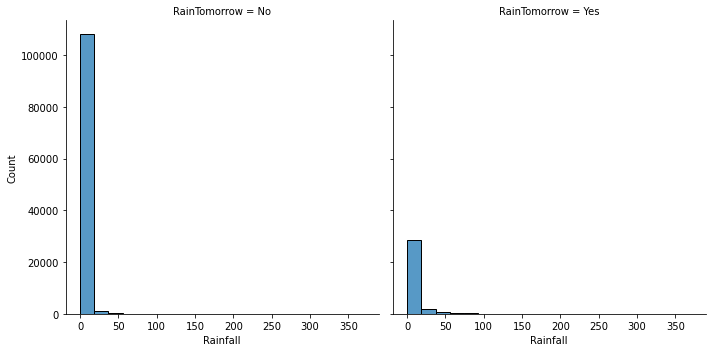

In [76]:
# Plot distribution with histogram
sns.displot(weather_df, x = 'Rainfall', col = 'RainTomorrow', bins = 20)

<AxesSubplot:xlabel='RainTomorrow', ylabel='Rainfall'>

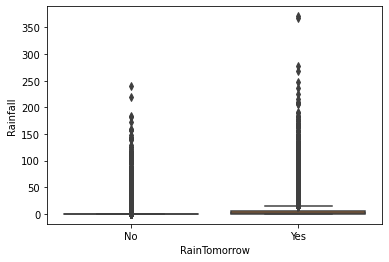

In [77]:
sns.boxplot(x = weather_df['RainTomorrow'], y = weather_df['Rainfall'])

Earlier calculation has shown both groups have very different variances. Additionally, Rainfall does not follow a normal distribution. Hence, neither two-sample t-test nor Welch t-test is suitable to assess correlation. Therefore, I will use the Kruskal-Wallis H-test to assess whether the mean of 2 groups are equal. 

Since it is a non-parametric method, the Kruskal-Wallis test does not assume a normal distribution. The null hypothesis is that the medians of all groups are equal. With a choosen significance level at 0.05, I will reject the null hypothesis if p-value is smaller or equal to 0.05. 

In [78]:
# Conduct Kruskal-Wallis H-test to check correlation 
yes = weather_df.query('RainTomorrow == "Yes"')['Rainfall']
no = weather_df.query('RainTomorrow == "No"')['Rainfall']

res = stats.kruskal(yes, no, nan_policy = 'omit')
display(res)

KruskalResult(statistic=15498.478309192722, pvalue=0.0)

Since p-value is smaller than 0.05, I will reject the null hypothesis. As the mean of Yes and No groups are significantly different, I conclude that Rainfall has predictive power and would be retained as a relevant feature. 

#### Evaporation

In [79]:
# Check for missing values
null_evaporation = weather_df[weather_df['Evaporation'].isnull()]
null_evaporation

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,12,2008,Summer
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,12,2008,Summer
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,12,2008,Summer
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,12,2008,Summer
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,12,2008,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No,6,2017,Winter
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No,6,2017,Winter
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No,6,2017,Winter
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No,6,2017,Winter


In [80]:
# Check for distribution of missing MaxTemp
null_evaporation_freq = pd.crosstab(null_evaporation['Year'], null_evaporation['Location'])
null_evaporation_freq

Location,Adelaide,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,MountGinini,Newcastle,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,PerthAirport,Portland,Richmond,Sale,SalmonGums,Sydney,SydneyAirport,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008,55,0,31,0,0,31,0,1,1,2,0,0,0,17,31,0,0,8,0,0,0,0,1,31,31,0,0,0,0,0,31,0,0,0,0,0,0,5,0,1,31,0,0,0,0,0,0,31,0
2009,109,0,365,4,365,365,0,2,2,0,4,12,0,2,365,1,0,247,0,0,0,0,0,365,365,0,365,2,56,365,364,0,0,0,132,6,365,2,2,10,365,0,2,365,0,7,365,365,3
2010,114,5,365,8,365,365,62,1,0,8,1,8,0,3,365,1,0,365,0,0,1,3,0,365,365,0,365,1,13,365,365,0,0,0,158,0,357,4,4,13,365,0,1,365,0,24,365,365,25
2011,101,0,335,2,335,335,247,1,6,38,16,12,7,2,335,1,0,335,0,0,1,20,7,335,335,0,335,8,1,335,335,0,0,7,122,0,335,7,7,11,335,0,1,332,0,111,335,335,39
2012,101,22,335,5,335,335,335,2,11,71,17,7,2,5,335,0,0,335,0,0,8,24,2,335,335,0,335,7,3,335,335,0,0,2,171,11,335,4,4,7,334,0,1,335,0,149,335,335,61
2013,103,9,337,3,337,337,31,0,1,213,16,23,2,2,337,0,14,337,0,0,2,10,2,337,337,306,332,7,3,337,337,1,1,2,105,4,337,4,4,5,337,306,0,337,0,144,337,337,55
2014,114,1,365,7,365,365,273,3,7,365,16,255,2,2,365,1,18,365,0,0,5,119,2,365,365,365,365,3,16,365,365,0,0,2,282,247,365,3,3,4,365,365,0,365,0,161,365,365,111
2015,250,8,365,5,365,365,365,2,35,365,12,365,2,5,365,3,18,365,2,2,16,146,2,365,365,365,365,5,14,365,365,0,0,2,238,365,365,10,10,2,365,365,2,365,2,139,365,365,94
2016,366,104,366,81,366,366,366,5,131,366,85,366,218,6,366,0,25,366,1,1,38,219,218,366,366,366,366,87,9,366,366,0,0,218,108,366,366,5,5,9,366,366,64,366,1,152,366,366,18


Evaporation is completely missing at certain locations (e.g. Albury, Ballarat, GoldCoast, etc.) Therefore, Evaporation is missing systemmatically. 

To deal with the 62,790 missing values, I will impute the missing values with forward fill method. 

<AxesSubplot:ylabel='Evaporation'>

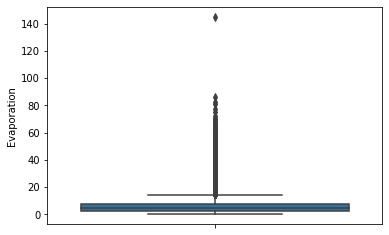

In [81]:
# Check for outliers with boxplot 
sns.boxplot(y = weather_df['Evaporation'])

In [82]:
# Identify outliers
isolate_outlier(weather_df, weather_df['Evaporation'])

lower_whisker:  -4.600000000000001 upper_whisker:  14.600000000000001


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season
6050,2009-01-02,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,SSE,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No,1,2009,Summer
6062,2009-01-14,Cobar,24.9,41.2,0.0,14.8,13.0,SSW,43.0,N,NNW,17.0,11.0,25.0,15.0,1012.9,1010.1,1.0,3.0,31.5,38.1,No,No,1,2009,Summer
6063,2009-01-15,Cobar,25.2,40.5,0.0,16.4,10.3,SW,44.0,W,SW,13.0,22.0,24.0,15.0,1012.4,1009.0,4.0,6.0,31.4,37.8,No,No,1,2009,Summer
6064,2009-01-16,Cobar,21.6,34.2,0.0,17.4,13.1,SW,44.0,S,S,17.0,19.0,19.0,8.0,1014.1,1012.3,0.0,0.0,25.0,32.2,No,No,1,2009,Summer
6065,2009-01-17,Cobar,18.4,31.8,0.0,16.0,12.9,S,33.0,S,SW,17.0,15.0,25.0,5.0,1016.3,1013.8,0.0,1.0,19.9,30.3,No,No,1,2009,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143775,2017-03-11,Katherine,24.8,35.4,31.8,16.8,NaN,SSE,57.0,WNW,WNW,7.0,17.0,81.0,NaN,1010.1,1005.9,3.0,NaN,27.6,NaN,Yes,Yes,3,2017,Autumn
143778,2017-03-14,Katherine,23.0,35.0,79.0,31.0,NaN,ESE,22.0,SSE,SE,11.0,13.0,84.0,NaN,1010.6,1007.1,3.0,NaN,27.5,NaN,Yes,No,3,2017,Autumn
143781,2017-03-17,Katherine,24.5,36.5,0.0,16.0,NaN,ESE,31.0,SSE,ESE,4.0,17.0,74.0,NaN,1008.9,1005.2,5.0,NaN,29.0,NaN,No,No,3,2017,Autumn
143784,2017-03-20,Katherine,24.0,34.0,49.0,17.0,NaN,NNE,31.0,W,NE,7.0,4.0,88.0,NaN,1009.8,1006.0,7.0,NaN,26.0,NaN,Yes,No,3,2017,Autumn


In this case, after observing the outliers and validating it with real-life observations, the outliers are perfectly normal and simply reflect different extremes across locations. Additionally, I want to predict RainTomorrow across a very wide range of weather scenarios and locations. Thus, it makes sense to retain the outliers. 

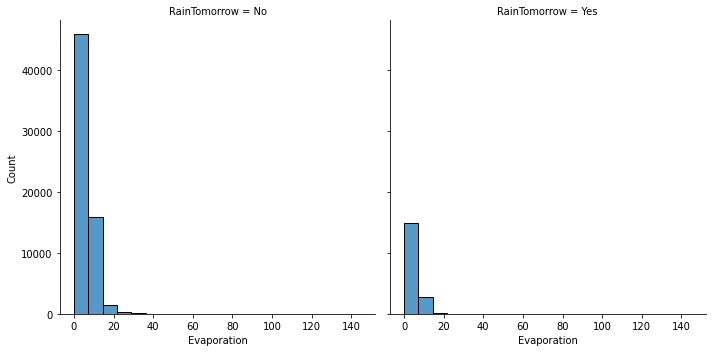

In [83]:
# Plot distribution with histogram
sns.displot(weather_df, x = 'Evaporation', col = 'RainTomorrow', bins = 20)

<AxesSubplot:xlabel='RainTomorrow', ylabel='Evaporation'>

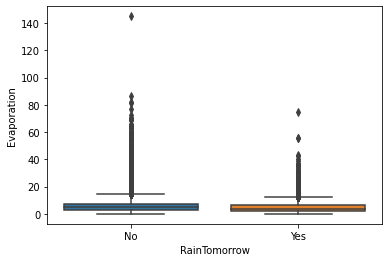

In [84]:
sns.boxplot(x = weather_df['RainTomorrow'], y = weather_df['Evaporation'])

Earlier calculation has shown both groups have very different variances. Additionally, Evaporation does not follow a normal distribution. Hence, neither two-sample t-test nor Welch t-test is suitable to assess correlation. Therefore, similar to Rainfall, I will use the Kruskal-Wallis H-test to assess whether the mean Evaporation of 2 groups are equal. 

In [85]:
# Conduct Kruskal-Wallis H-test to check correlation 
yes = weather_df.query('RainTomorrow == "Yes"')['Evaporation']
no = weather_df.query('RainTomorrow == "No"')['Evaporation']

res = stats.kruskal(yes, no, nan_policy = 'omit')
display(res)

KruskalResult(statistic=1540.897638714339, pvalue=0.0)

Since p-value is smaller than 0.05, I will reject the null hypothesis. As the mean of Yes and No groups are significantly different, I conclude that Evaporation has predictive power and would be retained as a relevant feature. 

#### Sunshine

In [86]:
# Check for missing values
null_sunshine = weather_df[weather_df['Sunshine'].isnull()]
null_sunshine

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,12,2008,Summer
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,12,2008,Summer
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,12,2008,Summer
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,12,2008,Summer
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,12,2008,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No,6,2017,Winter
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No,6,2017,Winter
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No,6,2017,Winter
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No,6,2017,Winter


In [87]:
# Check for distribution of missing MaxTemp
null_sunshine_freq = pd.crosstab(null_sunshine['Year'], null_sunshine['Location'])
null_sunshine_freq

Location,Adelaide,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,MountGinini,Newcastle,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,PerthAirport,Portland,Richmond,Sale,SalmonGums,Sydney,SydneyAirport,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008,4,0,31,0,0,31,31,2,0,3,0,0,0,0,31,4,0,31,0,0,0,0,0,31,31,0,0,0,0,0,31,0,0,0,0,0,0,0,0,0,31,0,0,0,0,0,0,31,0
2009,6,4,365,7,365,365,365,5,1,153,10,0,0,0,365,2,0,365,0,0,0,0,0,365,365,0,365,1,75,1,364,1,1,0,365,19,365,3,3,0,365,0,4,365,0,5,365,365,6
2010,16,2,365,24,365,365,365,13,1,63,170,1,0,1,365,1,0,365,1,1,2,0,0,365,365,0,365,2,10,0,365,0,0,0,365,1,357,1,1,0,365,0,1,365,1,41,365,365,34
2011,4,2,335,4,335,335,335,20,1,35,335,9,4,1,335,0,0,335,0,0,0,32,4,335,335,0,335,2,3,3,335,3,3,4,335,1,335,0,0,0,335,0,0,332,0,179,335,335,47
2012,230,25,335,13,335,335,335,5,1,52,335,88,4,0,335,0,0,335,0,0,10,40,4,335,335,0,335,2,4,0,335,0,0,4,335,12,335,4,4,0,334,0,0,335,0,240,335,335,103
2013,9,18,337,6,337,337,337,0,0,337,337,190,2,0,337,0,306,337,0,0,0,15,2,337,337,306,332,0,10,0,337,0,0,2,337,5,337,0,0,0,337,306,0,337,0,236,337,337,96
2014,248,0,365,13,365,365,365,2,5,365,365,320,4,0,365,1,365,365,0,0,9,169,4,365,365,365,365,0,14,1,365,1,1,4,365,246,365,1,1,0,365,365,0,365,0,270,365,365,178
2015,365,18,365,12,365,365,365,1,29,365,365,365,0,1,365,3,365,365,0,0,27,205,0,365,365,365,365,2,16,0,365,0,0,0,365,365,365,3,3,1,365,365,3,365,0,200,365,365,157
2016,366,275,366,265,366,366,366,1,262,366,366,366,253,0,366,1,366,366,0,0,29,317,253,366,366,366,366,254,23,0,366,0,0,253,366,366,366,4,4,246,366,366,250,366,0,307,366,366,213


Sunshine measurements is completely missing at certain locations (e.g. Albury, Ballarat, GoldCoast, etc.) Therefore, Sunshine is missing systemmatically. 

To deal with the 69,835 missing values, I will impute the missing values

<AxesSubplot:ylabel='Sunshine'>

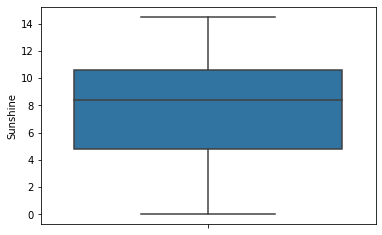

In [88]:
# Check for outliers with boxplot 
sns.boxplot(y = weather_df['Sunshine'])

Based on the boxplot, Sunshine does not have outliers and does not follow a normal distribution. 

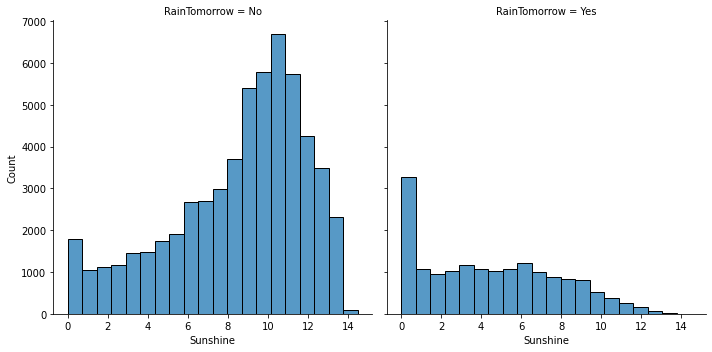

In [89]:
# Plot distribution with histogram
sns.displot(weather_df, x = 'Sunshine', col = 'RainTomorrow', bins = 20)

<AxesSubplot:xlabel='RainTomorrow', ylabel='Sunshine'>

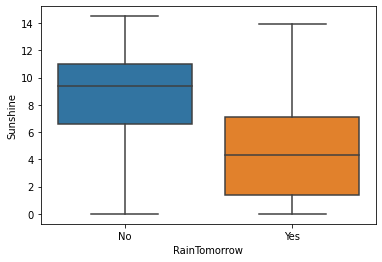

In [90]:
sns.boxplot(x = weather_df['RainTomorrow'], y = weather_df['Sunshine'])

Earlier calculation has shown both groups have very different variances. Additionally, Sunshine does not follow a normal distribution. Hence, neither two-sample t-test nor Welch t-test is suitable to assess correlation. Therefore, I will use the Kruskal-Wallis H-test to assess whether the mean of 2 groups are equal. 

Since it is a non-parametric method, the Kruskal-Wallis test does not assume a normal distribution. The null hypothesis is that the medians of all groups are equal. With a choosen significance level at 0.05, I will reject the null hypothesis if p-value is smaller or equal to 0.05. 

In [91]:
# Conduct Kruskal-Wallis H-test to check correlation 
yes = weather_df.query('RainTomorrow == "Yes"')['Sunshine']
no = weather_df.query('RainTomorrow == "No"')['Sunshine']

res = stats.kruskal(yes, no, nan_policy = 'omit')
display(res)

KruskalResult(statistic=14299.163214726199, pvalue=0.0)

Since p-value is smaller than 0.05, I will reject the null hypothesis. As the mean of Yes and No groups are significantly different, I conclude that Sunshine has predictive power and would be retained as a relevant feature. 

#### WindGustSpeed

In [92]:
# Check for missing values
null_windgustspeed = weather_df[weather_df['WindGustSpeed'].isnull()]
null_windgustspeed

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season
14,2008-12-15,Albury,8.4,24.6,0.0,NaN,NaN,NaN,NaN,S,WNW,4.0,30.0,57.0,32.0,1009.7,1008.7,NaN,NaN,15.9,23.5,No,NaN,12,2008,Summer
64,2009-02-03,Albury,21.5,37.7,0.0,NaN,NaN,NaN,NaN,N,NaN,13.0,9.0,51.0,21.0,1009.2,1005.7,NaN,NaN,27.2,36.2,No,No,2,2009,Summer
65,2009-02-04,Albury,21.7,36.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,11.0,11.0,53.0,26.0,1008.8,1004.7,NaN,NaN,25.5,35.2,No,No,2,2009,Summer
283,2009-09-10,Albury,2.6,NaN,0.0,NaN,NaN,NaN,NaN,E,WNW,6.0,13.0,71.0,55.0,1017.8,1017.6,NaN,6.0,9.7,14.3,No,NaN,9,2009,Spring
435,2010-02-09,Albury,22.1,35.1,0.0,NaN,NaN,NaN,NaN,ENE,SW,6.0,11.0,58.0,37.0,1020.9,1017.8,NaN,1.0,26.9,33.5,No,NaN,2,2010,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145091,2016-06-22,Uluru,12.3,19.1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.0,62.0,1016.8,1014.1,8.0,8.0,15.6,18.9,No,NaN,6,2016,Winter
145092,2016-06-23,Uluru,14.2,18.7,NaN,NaN,NaN,NaN,NaN,W,NaN,9.0,NaN,81.0,67.0,1015.2,1014.6,8.0,8.0,16.6,17.5,NaN,NaN,6,2016,Winter
145316,2017-02-02,Uluru,27.5,36.5,0.0,NaN,NaN,NaN,NaN,ESE,E,13.0,24.0,50.0,34.0,1011.9,1007.8,NaN,4.0,29.0,35.4,No,Yes,2,2017,Summer
145335,2017-02-21,Uluru,13.5,NaN,0.0,NaN,NaN,NaN,NaN,ENE,SW,24.0,7.0,23.0,11.0,1013.7,1008.4,NaN,NaN,25.2,34.4,No,NaN,2,2017,Summer


In [93]:
# Check for distribution of missing WindGustSpeed
null_windgustspeed_freq = pd.crosstab(null_windgustspeed['Year'], null_windgustspeed['Location'])
null_windgustspeed_freq

Location,Adelaide,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,MountGinini,Newcastle,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,PerthAirport,Portland,Richmond,Sale,SalmonGums,Sydney,SydneyAirport,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008,4,31,1,0,0,0,1,1,1,2,0,0,0,4,1,6,0,0,0,0,0,0,0,31,31,0,0,0,0,0,1,0,0,0,0,0,0,335,0,0,0,0,0,0,0,0,0,2,0
2009,4,365,3,4,2,5,9,3,1,153,4,25,63,2,2,2,0,7,3,3,0,1,2,163,365,0,18,2,6,21,7,0,4,11,2,3,3,365,19,0,2,0,8,15,2,23,6,2,6
2010,3,365,8,13,31,1,6,3,2,64,3,4,0,1,1,1,0,0,1,1,1,12,1,87,365,0,16,0,6,19,39,0,9,5,20,9,67,279,10,3,19,0,1,2,4,20,4,34,3
2011,3,335,9,20,5,16,8,4,1,56,10,2,1,3,2,3,0,3,5,5,1,4,2,9,335,0,3,4,13,37,9,2,9,8,0,5,0,8,11,3,0,0,7,13,1,24,2,0,25
2012,2,335,3,5,2,3,6,3,0,7,3,3,2,0,0,0,0,2,1,1,1,12,5,19,335,0,1,8,4,28,2,1,9,2,16,2,4,7,10,1,1,0,8,2,0,11,2,3,0
2013,0,337,3,1,0,0,0,2,0,22,1,3,1,10,0,0,2,9,0,0,0,10,2,3,337,0,5,10,3,17,0,0,3,2,6,4,1,11,0,0,1,1,0,6,0,11,0,0,1
2014,0,365,5,0,5,2,0,4,1,8,14,246,1,13,27,1,7,3,3,3,0,3,18,5,365,8,7,0,0,7,2,0,2,2,5,2,2,4,0,2,5,17,3,9,2,5,3,2,1
2015,5,365,0,0,10,1,3,8,6,12,1,57,0,7,48,4,8,3,0,0,1,6,0,0,365,1,3,7,0,4,0,0,7,1,1,22,2,11,0,2,4,3,0,11,4,2,6,2,1
2016,0,366,0,4,19,2,1,9,4,10,0,17,0,1,33,4,8,2,0,0,0,29,10,1,366,1,1,10,1,6,5,1,3,3,4,29,2,17,1,9,8,30,1,24,11,30,10,2,1


WindGustSpeed is completely missing at certain locations (e.g. Albany, Newcastle) Therefore, WindGustSpeed is missing systemmatically. 

To deal with the 10,263 missing values, I will impute the missing values with forward fill method. 

In [94]:
weather_df['WindGustSpeed'].skew()

0.8748788780303394

<AxesSubplot:ylabel='WindGustSpeed'>

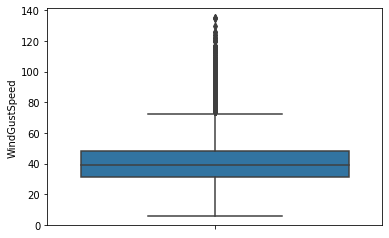

In [95]:
# Check for outliers with boxplot 
sns.boxplot(y = weather_df['WindGustSpeed'])

In [96]:
# Identify outliers
isolate_outlier(weather_df, weather_df['WindGustSpeed'])

lower_whisker:  5.5 upper_whisker:  73.5


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season
8,2008-12-09,Albury,9.7,31.9,0.0,NaN,NaN,NNW,80.0,SE,NW,7.0,28.0,42.0,9.0,1008.9,1003.6,NaN,NaN,18.3,30.2,No,Yes,12,2008,Summer
52,2009-01-22,Albury,24.4,34.0,0.6,NaN,NaN,NW,98.0,N,NNW,26.0,48.0,60.0,39.0,1005.3,997.8,4.0,1.0,26.1,33.1,No,Yes,1,2009,Summer
62,2009-02-01,Albury,28.0,43.1,0.0,NaN,NaN,SW,83.0,SE,E,15.0,9.0,27.0,9.0,1012.5,1008.7,NaN,NaN,32.4,41.9,No,No,2,2009,Summer
123,2009-04-03,Albury,18.4,28.1,8.6,NaN,NaN,W,98.0,E,NNE,7.0,17.0,92.0,49.0,1018.8,1012.9,8.0,6.0,19.0,27.4,Yes,Yes,4,2009,Autumn
267,2009-08-25,Albury,7.1,12.8,2.0,NaN,NaN,W,85.0,W,NW,15.0,20.0,75.0,53.0,1009.6,1008.2,3.0,NaN,7.7,11.7,Yes,Yes,8,2009,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144910,2015-12-24,Uluru,28.2,39.5,0.0,NaN,NaN,SW,83.0,ENE,N,28.0,7.0,35.0,21.0,1005.9,1001.0,7.0,7.0,30.6,38.1,No,Yes,12,2015,Summer
145189,2016-09-28,Uluru,19.8,30.5,0.0,NaN,NaN,W,76.0,NW,W,31.0,48.0,41.0,13.0,1007.7,1005.3,5.0,NaN,24.9,29.8,No,No,9,2016,Spring
145192,2016-10-01,Uluru,5.1,33.7,0.0,NaN,NaN,WNW,76.0,NNE,NW,9.0,33.0,22.0,8.0,1009.9,1003.7,NaN,7.0,20.8,32.7,No,Yes,10,2016,Spring
145240,2016-11-18,Uluru,24.5,33.9,0.0,NaN,NaN,SW,76.0,SSE,WNW,17.0,6.0,36.0,21.0,1013.3,1009.4,7.0,8.0,27.2,32.5,No,No,11,2016,Spring


In this case, after observing the outliers and validating it with real-life observations, the outliers are perfectly normal and simply reflect different extremes across locations. Additionally, I want to predict RainTomorrow across a very wide range of weather scenarios and locations. Thus, it makes sense to retain the outliers. 

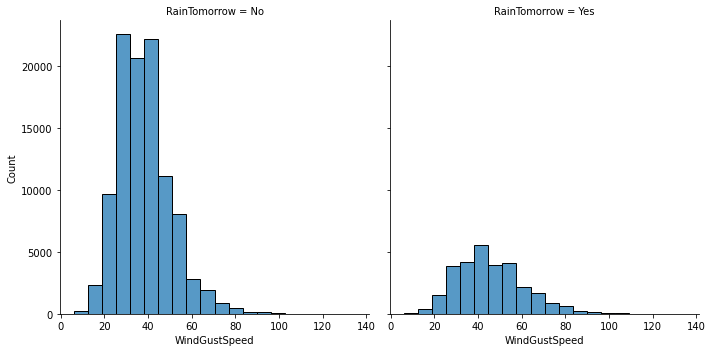

In [97]:
# Plot distribution with histogram
sns.displot(weather_df, x = 'WindGustSpeed', col = 'RainTomorrow', bins = 20)

<AxesSubplot:xlabel='RainTomorrow', ylabel='WindGustSpeed'>

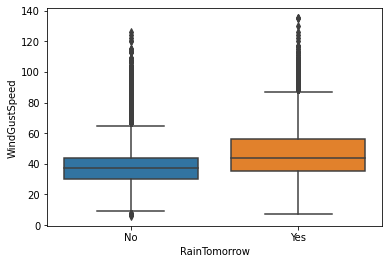

In [98]:
sns.boxplot(x = weather_df['RainTomorrow'], y = weather_df['WindGustSpeed'])

Earlier calculation has shown both groups have very different variances. Additionally, WindGustSpeed does not follow a normal distribution. Hence, neither two-sample t-test nor Welch t-test is suitable to assess correlation. Therefore, I will use the Kruskal-Wallis H-test to assess whether the mean of 2 groups are equal. 

Since it is a non-parametric method, the Kruskal-Wallis test does not assume a normal distribution. The null hypothesis is that the medians of all groups are equal. With a choosen significance level at 0.05, I will reject the null hypothesis if p-value is smaller or equal to 0.05. 

In [99]:
# Conduct Kruskal-Wallis H-test to check correlation 
yes = weather_df.query('RainTomorrow == "Yes"')['WindGustSpeed']
no = weather_df.query('RainTomorrow == "No"')['WindGustSpeed']

res = stats.kruskal(yes, no, nan_policy = 'omit')
display(res)

KruskalResult(statistic=5993.832052993844, pvalue=0.0)

Since p-value is smaller than 0.05, I will reject the null hypothesis. As the mean of Yes and No groups are significantly different, I conclude that WindGustSpeed has predictive power and would be retained as a relevant feature. 

#### WindSpeed9am

In [100]:
# Check for missing values
null_windspeed9am = weather_df[weather_df['WindSpeed9am'].isnull()]
null_windspeed9am

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season
15,2008-12-16,Albury,9.8,27.7,NaN,NaN,NaN,WNW,50.0,NaN,WNW,NaN,22.0,50.0,28.0,1013.4,1010.3,0.0,NaN,17.3,26.2,NaN,No,12,2008,Summer
436,2010-02-10,Albury,21.7,35.6,NaN,NaN,NaN,SSW,46.0,NaN,S,NaN,15.0,64.0,28.0,1018.8,1014.7,NaN,4.0,25.2,32.9,NaN,No,2,2010,Summer
438,2010-02-12,Albury,22.5,29.1,NaN,NaN,NaN,SW,24.0,NaN,NNW,NaN,11.0,81.0,67.0,1008.5,1007.8,NaN,7.0,23.4,26.4,NaN,No,2,2010,Summer
984,2011-09-11,Albury,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,2011,Spring
985,2011-09-12,Albury,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,2011,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145087,2016-06-18,Uluru,8.7,18.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,46.0,1019.7,1016.8,1.0,3.0,12.3,17.9,No,No,6,2016,Winter
145088,2016-06-19,Uluru,3.4,18.3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.0,40.0,1020.3,1017.3,NaN,NaN,8.2,16.9,No,No,6,2016,Winter
145089,2016-06-20,Uluru,2.2,21.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,23.0,1017.4,1014.1,NaN,NaN,8.5,20.5,No,No,6,2016,Winter
145090,2016-06-21,Uluru,7.8,25.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0,25.0,1013.9,1011.5,5.0,8.0,12.3,24.9,No,No,6,2016,Winter


In [101]:
# Check for distribution of missing WindSpeed9am
null_windspeed9am_freq = pd.crosstab(null_windspeed9am['Year'], null_windspeed9am['Location'])
null_windspeed9am_freq

Location,Adelaide,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,MountGinini,Newcastle,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,PerthAirport,Portland,Richmond,Sale,SalmonGums,Sydney,SydneyAirport,Townsville,Tuggeranong,Uluru,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008,3,0,1,0,0,0,0,0,0,7,0,0,0,0,0,0,0,1,0,0,0,0,12,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0
2009,0,0,0,0,3,4,1,0,0,154,4,2,65,0,0,0,1,1,1,0,2,1,84,23,0,15,3,1,1,5,1,1,2,1,0,9,1,2,2,0,13,0,0,5,2,0
2010,0,0,2,0,24,0,0,1,0,60,0,0,1,0,1,0,0,0,0,0,3,0,85,38,0,15,0,0,7,33,1,0,18,0,69,14,1,0,17,0,0,0,1,1,26,1
2011,0,19,3,0,0,3,0,0,0,1,0,0,0,1,3,0,0,0,0,0,0,0,9,26,0,0,1,1,6,4,0,1,1,0,0,0,0,0,0,0,9,0,2,0,0,2
2012,0,2,0,0,0,1,0,0,0,2,1,0,0,0,0,0,0,0,0,0,2,0,21,41,0,0,1,1,2,0,0,0,10,0,1,1,0,0,0,0,0,0,0,0,1,0
2013,0,2,1,2,0,0,0,0,0,3,0,3,0,0,0,0,2,0,0,1,5,1,3,26,0,3,0,2,0,0,0,0,8,1,0,1,0,0,3,1,10,0,3,0,0,1
2014,0,5,2,0,2,0,0,0,0,0,10,245,0,0,9,0,0,0,0,0,1,5,6,21,5,6,0,0,2,0,0,0,3,0,0,0,0,0,1,10,0,0,1,0,0,0
2015,2,8,0,0,4,0,2,0,0,1,0,45,0,0,22,1,0,0,0,1,2,0,0,22,0,1,1,15,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0
2016,0,9,0,0,16,0,0,0,1,1,0,1,0,1,5,0,0,0,0,0,26,0,0,35,0,0,2,0,2,2,0,0,1,0,0,0,1,0,0,25,1,0,5,0,0,0


After analysing the distribution across Location, Month and assessing for any potential correlation with other numerical features, I did not find any patterns for missing values. Therefore, I concluded that WindSpeed9am has missing values randomly. 

To deal with the 1,767 missing values, I will impute the missing values with forward fill method. 

In [102]:
weather_df['WindSpeed9am'].skew()

0.7776295122810298

<AxesSubplot:ylabel='WindSpeed9am'>

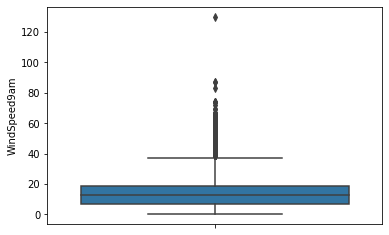

In [103]:
# Check for outliers with boxplot 
sns.boxplot(y = weather_df['WindSpeed9am'])

In [104]:
# Identify outliers
isolate_outlier(weather_df, weather_df['WindSpeed9am'])

lower_whisker:  -11.0 upper_whisker:  37.0


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season
3308,2009-09-26,BadgerysCreek,14.1,18.8,0.0,NaN,NaN,NW,80.0,WNW,WNW,48.0,37.0,32.0,25.0,1004.9,1004.9,NaN,NaN,16.1,17.1,No,No,9,2009,Spring
3693,2010-10-16,BadgerysCreek,9.9,15.4,NaN,NaN,NaN,W,78.0,W,W,39.0,41.0,43.0,40.0,1000.8,1004.4,NaN,NaN,11.0,14.4,NaN,No,10,2010,Spring
5050,2014-10-01,BadgerysCreek,13.7,20.9,0.0,NaN,NaN,WSW,61.0,SW,SSW,44.0,19.0,26.0,21.0,1017.7,1017.7,NaN,NaN,16.2,20.0,No,No,10,2014,Spring
9104,2009-02-16,CoffsHarbour,19.0,23.4,63.6,NaN,0.0,S,57.0,S,S,39.0,33.0,98.0,95.0,1011.3,1011.2,8.0,8.0,20.6,21.0,Yes,Yes,2,2009,Summer
9147,2009-03-31,CoffsHarbour,19.0,23.3,62.6,NaN,0.0,SSE,70.0,SSE,S,43.0,19.0,88.0,97.0,1009.9,1008.3,8.0,8.0,22.7,19.4,Yes,NaN,3,2009,Autumn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141189,2014-06-07,Darwin,24.8,32.6,0.0,8.8,10.8,ESE,57.0,ESE,SE,39.0,35.0,50.0,36.0,1011.3,1008.3,3.0,1.0,27.3,32.2,No,No,6,2014,Winter
141403,2015-01-07,Darwin,26.1,31.3,9.2,6.2,4.5,WNW,59.0,WNW,NW,39.0,28.0,84.0,73.0,1005.0,1002.3,8.0,7.0,26.3,30.4,Yes,Yes,1,2015,Summer
141419,2015-01-23,Darwin,25.2,29.3,4.0,8.0,0.0,W,56.0,W,WSW,39.0,17.0,88.0,90.0,1007.1,1004.0,7.0,8.0,25.2,27.4,Yes,Yes,1,2015,Summer
141755,2015-12-25,Darwin,24.4,28.8,70.8,6.8,0.2,W,78.0,W,W,39.0,43.0,93.0,77.0,1002.3,1001.0,8.0,8.0,25.7,27.6,Yes,Yes,12,2015,Summer


In this case, after observing the outliers and validating it with real-life observations, the outliers are perfectly normal and simply reflect different extremes across locations. Additionally, I want to predict RainTomorrow across a very wide range of weather scenarios and locations. Thus, it makes sense to retain the outliers. 

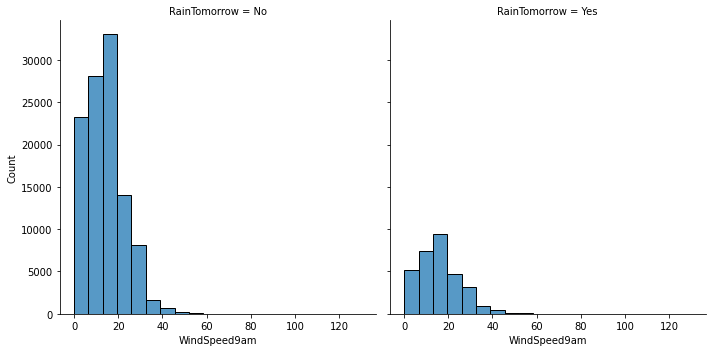

In [105]:
# Plot distribution with histogram
sns.displot(weather_df, x = 'WindSpeed9am', col = 'RainTomorrow', bins = 20)

<AxesSubplot:xlabel='RainTomorrow', ylabel='WindSpeed9am'>

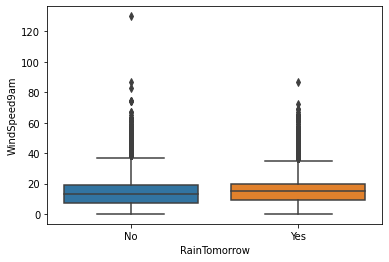

In [106]:
sns.boxplot(x = weather_df['RainTomorrow'], y = weather_df['WindSpeed9am'])

Earlier calculation has shown both groups have very different variances. Additionally, WindSpeed9am does not follow a normal distribution. Hence, neither two-sample t-test nor Welch t-test is suitable to assess correlation. Therefore, I will use the Kruskal-Wallis H-test to assess whether the mean of 2 groups are equal. 

Since it is a non-parametric method, the Kruskal-Wallis test does not assume a normal distribution. The null hypothesis is that the medians of all groups are equal. With a choosen significance level at 0.05, I will reject the null hypothesis if p-value is smaller or equal to 0.05. 

In [107]:
# Conduct Kruskal-Wallis H-test to check correlation 
yes = weather_df.query('RainTomorrow == "Yes"')['WindSpeed9am']
no = weather_df.query('RainTomorrow == "No"')['WindSpeed9am']

res = stats.kruskal(yes, no, nan_policy = 'omit')
display(res)

KruskalResult(statistic=933.6338214911385, pvalue=4.790484627763458e-205)

Since p-value is smaller than 0.05, I will reject the null hypothesis. As the mean of Yes and No groups are significantly different, I conclude that WindSpeed9am has predictive power and would be retained as a relevant feature. 

#### WindSpeed3pm

In [108]:
# Check for missing values
null_windspeed3pm = weather_df[weather_df['WindSpeed3pm'].isnull()]
null_windspeed3pm

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season
89,2009-02-28,Albury,16.0,34.5,0.0,NaN,NaN,WSW,44.0,E,NaN,6.0,NaN,44.0,14.0,1007.5,1004.6,NaN,NaN,22.2,33.6,No,No,2,2009,Summer
402,2010-01-07,Albury,15.0,33.0,0.0,NaN,NaN,SSE,28.0,NE,NaN,9.0,NaN,45.0,17.0,1014.9,1012.7,NaN,1.0,22.8,31.8,No,No,1,2010,Summer
430,2010-02-04,Albury,23.5,32.0,0.0,NaN,NaN,NNW,44.0,ENE,NaN,19.0,NaN,51.0,44.0,1010.8,1006.2,4.0,NaN,26.3,31.1,No,Yes,2,2010,Summer
984,2011-09-11,Albury,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,2011,Spring
985,2011-09-12,Albury,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,2011,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145088,2016-06-19,Uluru,3.4,18.3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.0,40.0,1020.3,1017.3,NaN,NaN,8.2,16.9,No,No,6,2016,Winter
145089,2016-06-20,Uluru,2.2,21.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,23.0,1017.4,1014.1,NaN,NaN,8.5,20.5,No,No,6,2016,Winter
145090,2016-06-21,Uluru,7.8,25.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.0,25.0,1013.9,1011.5,5.0,8.0,12.3,24.9,No,No,6,2016,Winter
145091,2016-06-22,Uluru,12.3,19.1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.0,62.0,1016.8,1014.1,8.0,8.0,15.6,18.9,No,NaN,6,2016,Winter


In [109]:
# Check for distribution of missing WindSpeed9am
null_windspeed3pm_freq = pd.crosstab(null_windspeed3pm['Year'], null_windspeed3pm['Location'])
null_windspeed3pm_freq

Location,Adelaide,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Mildura,Moree,MountGambier,MountGinini,Newcastle,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,PerthAirport,Portland,Richmond,Sale,SalmonGums,Sydney,SydneyAirport,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,7,4,0,0,0,0,0,1,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,2,0
2009,1,3,1,0,6,0,1,2,0,153,0,1,64,0,1,0,0,4,0,2,0,107,37,0,12,0,1,4,5,0,1,0,2,0,0,9,0,0,1,0,0,12,0,2,0,2,0
2010,2,0,2,1,19,1,0,3,0,59,1,1,0,0,1,0,0,1,0,3,0,69,51,0,13,0,0,6,9,0,0,1,8,0,68,12,0,0,18,0,0,0,0,0,0,22,2
2011,0,16,6,0,3,3,1,2,0,5,0,0,0,1,4,0,0,1,0,0,2,11,37,0,1,0,0,2,3,1,0,1,1,0,0,0,0,0,0,0,0,9,0,1,1,1,3
2012,0,6,0,1,0,0,0,0,0,2,1,0,0,0,0,1,0,0,0,2,0,17,55,0,0,0,3,5,0,0,0,0,18,2,2,0,0,0,1,0,0,1,0,0,1,2,0
2013,0,2,1,0,0,0,0,0,0,1,0,3,0,1,0,0,0,2,1,4,1,1,31,0,2,0,5,2,0,0,0,0,4,0,0,0,0,0,0,0,0,6,0,1,0,0,0
2014,0,5,1,0,2,0,0,0,0,2,9,245,0,0,6,0,0,0,0,0,6,5,27,5,5,0,0,4,0,0,0,0,2,1,0,0,0,0,0,4,1,1,1,0,0,0,0
2015,2,158,0,0,3,0,1,0,1,0,0,41,0,0,15,1,3,0,0,3,0,0,166,0,0,2,15,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2016,0,366,0,0,15,0,0,0,0,1,0,4,0,0,4,0,3,0,0,27,0,0,366,0,0,0,1,3,3,0,0,0,1,1,0,0,1,1,0,26,0,0,0,2,0,0,0


After analysing the distribution across Location, Month and assessing for any potential correlation with other numerical features, I did not find any patterns for missing values. Therefore, I concluded that WindSpeed3pm has missing values randomly. 

To deal with the 3,062 missing values, I will impute the missing values with forward fill method. 

In [110]:
weather_df['WindSpeed3pm'].skew()

0.6282154194116664

<AxesSubplot:ylabel='WindSpeed3pm'>

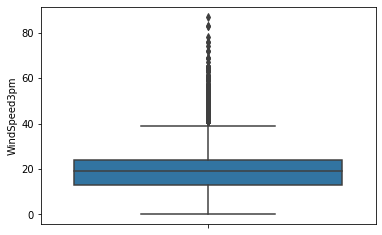

In [111]:
# Check for outliers with boxplot 
sns.boxplot(y = weather_df['WindSpeed3pm'])

In [112]:
# Identify outliers
isolate_outlier(weather_df, weather_df['WindSpeed3pm'])

lower_whisker:  -3.5 upper_whisker:  40.5


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season
52,2009-01-22,Albury,24.4,34.0,0.6,NaN,NaN,NW,98.0,N,NNW,26.0,48.0,60.0,39.0,1005.3,997.8,4.0,1.0,26.1,33.1,No,Yes,1,2009,Summer
356,2009-11-22,Albury,18.3,28.3,25.8,NaN,NaN,NNW,61.0,NaN,W,0.0,46.0,98.0,67.0,1003.7,1003.5,8.0,8.0,19.2,25.6,Yes,No,11,2009,Spring
381,2009-12-17,Albury,14.5,40.3,0.0,NaN,NaN,NW,107.0,S,WNW,9.0,50.0,40.0,28.0,1008.9,1005.7,NaN,2.0,24.2,31.4,No,Yes,12,2009,Summer
1626,2013-08-12,Albury,5.8,14.9,17.2,NaN,NaN,W,69.0,NW,W,31.0,44.0,94.0,54.0,1004.3,1006.0,8.0,NaN,12.7,13.0,Yes,Yes,8,2013,Winter
1692,2013-10-17,Albury,11.2,17.7,0.0,NaN,NaN,WNW,69.0,WNW,WNW,26.0,46.0,62.0,43.0,1006.3,1012.0,8.0,1.0,13.9,14.8,No,No,10,2013,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144253,2014-03-07,Uluru,25.9,36.1,NaN,NaN,NaN,NaN,NaN,SE,S,28.0,44.0,28.0,36.0,1015.8,1012.7,NaN,NaN,29.7,28.7,NaN,NaN,3,2014,Autumn
145108,2016-07-09,Uluru,8.6,27.8,0.0,NaN,NaN,NNW,65.0,N,NNW,9.0,41.0,57.0,25.0,1015.4,1010.1,NaN,NaN,16.3,27.6,No,Yes,7,2016,Winter
145189,2016-09-28,Uluru,19.8,30.5,0.0,NaN,NaN,W,76.0,NW,W,31.0,48.0,41.0,13.0,1007.7,1005.3,5.0,NaN,24.9,29.8,No,No,9,2016,Spring
145193,2016-10-02,Uluru,18.2,27.3,2.0,NaN,NaN,W,65.0,W,W,31.0,41.0,66.0,11.0,1006.3,1005.6,1.0,NaN,21.4,26.1,Yes,No,10,2016,Spring


In this case, after observing the outliers and validating it with real-life observations, the outliers are perfectly normal and simply reflect different extremes across locations. Additionally, I want to predict RainTomorrow across a very wide range of weather scenarios and locations. Thus, it makes sense to retain the outliers. 

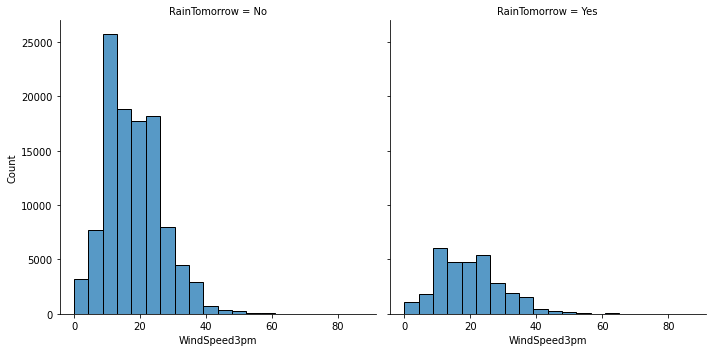

In [113]:
# Plot distribution with histogram
sns.displot(weather_df, x = 'WindSpeed3pm', col = 'RainTomorrow', bins = 20)

<AxesSubplot:xlabel='RainTomorrow', ylabel='WindSpeed3pm'>

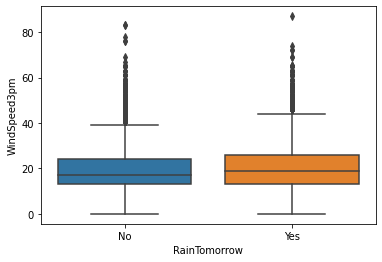

In [114]:
sns.boxplot(x = weather_df['RainTomorrow'], y = weather_df['WindSpeed3pm'])

Earlier calculation has shown both groups have very different variances. Additionally, WindSpeed3pm does not follow a normal distribution. Hence, neither two-sample t-test nor Welch t-test is suitable to assess correlation. Therefore, I will use the Kruskal-Wallis H-test to assess whether the mean of 2 groups are equal. 

Since it is a non-parametric method, the Kruskal-Wallis test does not assume a normal distribution. The null hypothesis is that the medians of all groups are equal. With a choosen significance level at 0.05, I will reject the null hypothesis if p-value is smaller or equal to 0.05. 

In [115]:
# Conduct Kruskal-Wallis H-test to check correlation 
yes = weather_df.query('RainTomorrow == "Yes"')['WindSpeed3pm']
no = weather_df.query('RainTomorrow == "No"')['WindSpeed3pm']

res = stats.kruskal(yes, no, nan_policy = 'omit')
display(res)

KruskalResult(statistic=812.9352184861893, pvalue=8.312654463555855e-179)

Since p-value is smaller than 0.05, I will reject the null hypothesis. As the mean of Yes and No groups are significantly different, I conclude that WindSpeed3pm has predictive power and would be retained as a relevant feature. 

#### Humidity9am

In [116]:
# Check for missing values
null_humidity9am = weather_df[weather_df['Humidity9am'].isnull()]
null_humidity9am

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season
984,2011-09-11,Albury,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,2011,Spring
985,2011-09-12,Albury,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,2011,Spring
986,2011-09-13,Albury,NaN,15.8,NaN,NaN,NaN,NaN,NaN,NaN,NNW,NaN,9.0,NaN,47.0,NaN,1023.9,NaN,5.0,NaN,15.1,NaN,NaN,9,2011,Spring
1566,2013-06-13,Albury,10.0,13.4,16.8,NaN,NaN,WNW,28.0,N,W,7.0,13.0,NaN,93.0,1007.1,1005.5,8.0,8.0,NaN,12.3,Yes,Yes,6,2013,Winter
1909,2014-05-22,Albury,8.5,18.9,0.2,NaN,NaN,SE,19.0,W,SE,2.0,13.0,NaN,72.0,1023.5,1019.0,8.0,4.0,NaN,18.5,No,No,5,2014,Autumn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144312,2014-05-05,Uluru,NaN,26.2,NaN,NaN,NaN,NNE,35.0,NE,E,9.0,13.0,NaN,29.0,1020.9,1016.9,NaN,NaN,NaN,25.0,NaN,NaN,5,2014,Autumn
144315,2014-05-08,Uluru,NaN,28.5,NaN,NaN,NaN,NNW,28.0,NE,N,13.0,19.0,NaN,28.0,1018.3,1014.1,NaN,NaN,NaN,27.6,NaN,NaN,5,2014,Autumn
144316,2014-05-09,Uluru,NaN,28.3,NaN,NaN,NaN,NNW,39.0,SW,WNW,4.0,17.0,NaN,26.0,1015.8,1012.5,1.0,NaN,NaN,27.7,NaN,NaN,5,2014,Autumn
144331,2014-05-24,Uluru,8.5,29.1,NaN,NaN,NaN,N,24.0,NaN,W,NaN,11.0,NaN,27.0,NaN,1015.4,NaN,NaN,NaN,28.6,NaN,No,5,2014,Autumn


In [117]:
# Check for distribution of missing WindSpeed9am
null_humidity9am_freq = pd.crosstab(null_humidity9am['Year'], null_humidity9am['Location'])
null_humidity9am_freq

Location,Adelaide,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,MountGinini,Newcastle,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,Portland,Richmond,Sale,SalmonGums,Sydney,SydneyAirport,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,12,3,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0
2009,1,0,0,0,3,1,2,0,0,4,3,0,66,0,0,0,0,2,1,0,0,1,0,98,20,0,15,1,2,1,5,2,9,21,1,0,1,0,2,0,0,13,0,0,1,2,0
2010,0,0,0,0,16,0,2,1,0,12,0,0,0,0,0,2,0,0,1,8,0,0,0,61,35,0,15,0,1,7,33,0,21,8,1,35,2,0,9,0,0,0,0,1,1,23,0
2011,0,0,3,0,0,4,0,0,0,14,0,0,0,0,0,1,0,0,0,0,0,1,0,102,21,0,0,1,2,5,6,2,17,1,0,0,2,0,0,0,0,9,0,1,0,0,9
2012,1,3,0,0,0,2,1,1,0,25,1,0,0,0,0,4,0,0,0,0,0,0,0,124,30,0,0,0,0,1,5,0,2,9,2,1,9,0,1,0,0,7,0,0,236,1,0
2013,0,2,1,1,0,6,0,0,0,6,0,6,0,0,0,0,23,2,0,0,3,0,1,34,27,0,3,0,1,0,0,0,0,8,1,0,0,0,7,1,0,33,5,5,0,0,2
2014,0,6,5,0,2,0,0,1,0,0,8,12,0,0,0,2,30,0,0,0,0,2,0,3,21,5,6,0,1,4,0,0,0,11,1,0,1,1,1,13,0,0,8,1,2,0,0
2015,2,5,0,1,4,0,0,1,0,1,2,1,162,0,7,1,6,0,359,0,0,0,0,0,24,0,1,1,1,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,2
2016,0,14,0,0,16,3,0,0,1,1,100,0,0,0,6,0,11,0,121,0,0,0,6,2,38,0,0,2,2,2,12,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0


After analysing the distribution across Location, Month and assessing for any potential correlation with other numerical features, I did not find any patterns for missing values. Therefore, I concluded that Humidity9am has missing values randomly. 

To deal with the 2,654 missing values, I will impute the missing values with forward fill method. 

<AxesSubplot:ylabel='Humidity9am'>

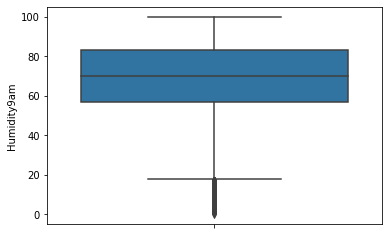

In [118]:
# Check for outliers with boxplot 
sns.boxplot(y = weather_df['Humidity9am'])

In [119]:
# Identify outliers
isolate_outlier(weather_df, weather_df['Humidity9am'])

lower_whisker:  18.0 upper_whisker:  122.0


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season
6304,2009-09-13,Cobar,14.5,32.7,0.0,10.8,11.0,NW,46.0,N,NW,19.0,20.0,17.0,7.0,1018.8,1015.8,0.0,0.0,22.9,32.2,No,No,9,2009,Spring
6306,2009-09-15,Cobar,8.1,24.2,0.0,6.4,10.6,SW,24.0,SSE,WSW,13.0,9.0,17.0,14.0,1020.9,1016.9,5.0,3.0,17.8,24.1,No,No,9,2009,Spring
6321,2009-09-30,Cobar,7.4,27.6,0.0,5.8,11.9,N,35.0,NNE,NNW,17.0,20.0,15.0,6.0,1018.0,1013.1,1.0,0.0,20.6,26.7,No,No,9,2009,Spring
6322,2009-10-01,Cobar,14.7,34.9,0.0,10.0,11.4,NNW,43.0,NNE,NW,17.0,22.0,9.0,1.0,1013.3,1007.9,0.0,0.0,25.0,33.8,No,No,10,2009,Spring
6341,2009-10-20,Cobar,13.9,32.6,0.0,7.6,12.7,NW,39.0,NNE,SW,13.0,13.0,15.0,11.0,1022.6,1018.8,0.0,0.0,23.5,31.6,No,No,10,2009,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145263,2016-12-11,Uluru,16.3,34.4,0.0,NaN,NaN,E,48.0,E,ESE,28.0,22.0,16.0,9.0,1015.5,1011.2,NaN,NaN,27.9,33.1,No,No,12,2016,Summer
145264,2016-12-12,Uluru,14.7,37.6,0.0,NaN,NaN,ENE,43.0,ENE,NNW,28.0,9.0,13.0,6.0,1012.1,1007.5,NaN,NaN,29.1,36.3,No,No,12,2016,Summer
145265,2016-12-13,Uluru,16.7,41.7,0.0,NaN,NaN,SW,61.0,NNE,WSW,26.0,15.0,17.0,7.0,1006.1,1002.6,NaN,NaN,33.2,41.1,No,No,12,2016,Summer
145342,2017-02-28,Uluru,15.9,38.2,0.0,NaN,NaN,SSE,37.0,E,SSE,15.0,19.0,15.0,8.0,1012.5,1008.8,NaN,NaN,28.3,37.8,No,No,2,2017,Summer


In this case, after observing the outliers and validating it with real-life observations, the outliers are perfectly normal and simply reflect different extremes across locations. Additionally, I want to predict RainTomorrow across a very wide range of weather scenarios and locations. Thus, it makes sense to retain the outliers. 

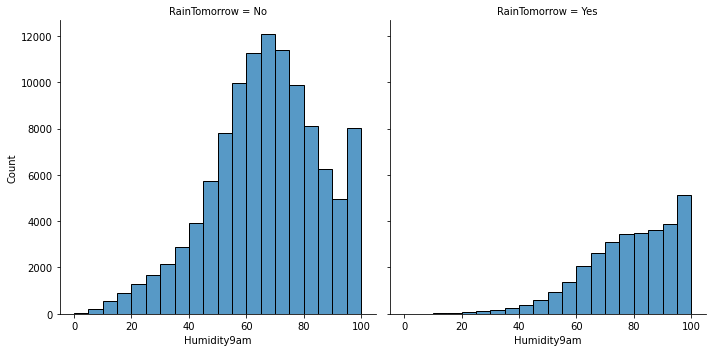

In [120]:
# Plot distribution with histogram
sns.displot(weather_df, x = 'Humidity9am', col = 'RainTomorrow', bins = 20)

<AxesSubplot:xlabel='RainTomorrow', ylabel='Humidity9am'>

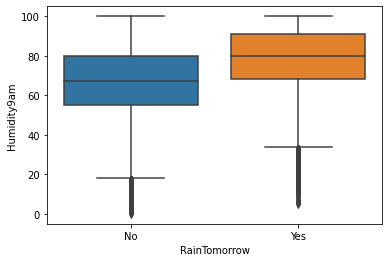

In [121]:
sns.boxplot(x = weather_df['RainTomorrow'], y = weather_df['Humidity9am'])

Earlier calculation has shown both groups have very different variances. Additionally, Humidity9am does not follow a normal distribution. Hence, neither two-sample t-test nor Welch t-test is suitable to assess correlation. Therefore, I will use the Kruskal-Wallis H-test to assess whether the mean of 2 groups are equal. 

Since it is a non-parametric method, the Kruskal-Wallis test does not assume a normal distribution. The null hypothesis is that the medians of all groups are equal. With a choosen significance level at 0.05, I will reject the null hypothesis if p-value is smaller or equal to 0.05. 

In [122]:
# Conduct Kruskal-Wallis H-test to check correlation 
yes = weather_df.query('RainTomorrow == "Yes"')['Humidity9am']
no = weather_df.query('RainTomorrow == "No"')['Humidity9am']

res = stats.kruskal(yes, no, nan_policy = 'omit')
display(res)

KruskalResult(statistic=10023.144104611973, pvalue=0.0)

Since p-value is smaller than 0.05, I will reject the null hypothesis. As the mean of Yes and No groups are significantly different, I conclude that Humidity9am has predictive power and would be retained as a relevant feature. 

#### Humidity3pm

In [123]:
# Check for missing values
null_humidity3pm = weather_df[weather_df['Humidity3pm'].isnull()]
null_humidity3pm

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season
984,2011-09-11,Albury,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,2011,Spring
985,2011-09-12,Albury,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,2011,Spring
1058,2011-11-24,Albury,10.8,26.0,0.0,NaN,NaN,NaN,NaN,SE,NaN,19.0,NaN,44.0,NaN,1024.5,NaN,NaN,NaN,17.2,NaN,No,Yes,11,2011,Spring
1059,2011-11-25,Albury,15.0,20.0,11.0,NaN,NaN,NaN,NaN,SSE,NaN,11.0,NaN,99.0,NaN,1020.1,NaN,8.0,NaN,15.0,NaN,Yes,Yes,11,2011,Spring
1060,2011-11-26,Albury,15.0,25.0,44.0,NaN,NaN,NaN,NaN,NE,NaN,13.0,NaN,83.0,NaN,1006.2,NaN,3.0,NaN,20.0,NaN,Yes,Yes,11,2011,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143881,2017-06-25,Katherine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,E,9.0,17.0,NaN,NaN,1014.9,1011.7,NaN,NaN,NaN,NaN,NaN,NaN,6,2017,Winter
144203,2014-01-16,Uluru,24.0,30.4,0.4,NaN,NaN,NE,50.0,ENE,NaN,20.0,NaN,74.0,NaN,1006.4,NaN,NaN,NaN,25.4,NaN,No,Yes,1,2014,Summer
144242,2014-02-24,Uluru,18.4,NaN,0.0,NaN,NaN,NaN,NaN,ESE,NaN,22.0,NaN,23.0,NaN,1014.1,NaN,NaN,NaN,24.9,NaN,No,NaN,2,2014,Summer
144260,2014-03-14,Uluru,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2014,Autumn


In [124]:
# Check for distribution of missing WindSpeed9am
null_humidity3pm_freq = pd.crosstab(null_humidity3pm['Year'], null_humidity3pm['Location'])
null_humidity3pm_freq

Location,Adelaide,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,MountGinini,Newcastle,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,PerthAirport,Portland,Richmond,Sale,SalmonGums,Sydney,SydneyAirport,Tuggeranong,Uluru,Walpole,Williamtown,Witchcliffe,Wollongong,Woomera
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,4,0,0,0,0,0,2,4,0,0,0,0,0,1,0,0,0,0,0,0,2,0
2009,2,3,0,0,6,0,0,2,1,0,0,64,0,0,0,0,4,2,0,0,0,1,118,37,0,12,0,2,4,5,1,1,0,20,0,0,0,0,1,0,12,1,0,2,2
2010,1,1,0,2,15,1,0,3,1,1,1,0,0,0,0,0,1,0,8,0,0,0,48,49,0,12,0,0,6,8,0,0,7,5,0,34,4,0,11,0,0,0,0,23,4
2011,0,0,6,0,3,4,1,2,4,0,0,0,1,0,2,0,0,1,0,0,1,2,54,36,0,1,0,0,2,3,3,0,6,1,1,0,1,0,0,0,9,1,1,1,10
2012,0,5,0,1,0,0,0,0,3,1,1,0,0,0,5,0,0,0,0,0,2,0,73,45,0,0,0,3,5,5,0,0,0,18,0,2,7,0,1,0,7,0,233,2,1
2013,0,3,1,1,0,1,0,1,1,0,10,0,1,0,0,70,2,1,1,4,0,1,9,32,0,2,0,2,2,0,0,0,0,4,3,0,0,1,0,0,31,3,0,0,2
2014,0,5,1,0,2,0,0,2,2,9,10,0,0,0,3,64,0,2,0,0,2,0,0,27,5,5,0,2,5,0,0,0,0,10,0,0,0,0,0,4,1,0,0,0,5
2015,2,156,0,0,3,0,0,3,0,3,0,161,0,7,2,160,0,360,0,0,0,0,0,167,0,0,2,1,0,0,0,0,0,1,11,0,0,1,0,0,0,1,0,0,3
2016,0,366,0,0,15,0,0,0,0,101,0,0,0,4,1,366,0,121,0,0,0,4,1,366,0,0,0,2,3,12,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0


After analysing the distribution across Location, Month and assessing for any potential correlation with other numerical features, I did not find any patterns for missing values. Therefore, I concluded that Humidity3pm has missing values randomly. 

To deal with the 4,507 missing values, I will impute the missing values with forward fill method. 

In [125]:
weather_df['Humidity3pm'].skew()

0.03361436764166918

<AxesSubplot:ylabel='Humidity3pm'>

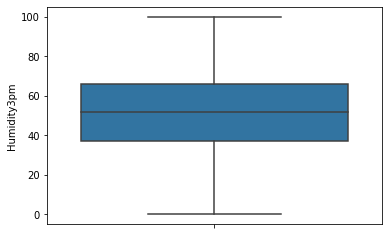

In [126]:
# Check for outliers with boxplot 
sns.boxplot(y = weather_df['Humidity3pm'])

Based on the overall distribution and the boxplot, Humidity9am follows a normal distribution. This feature also does not have outliers. 

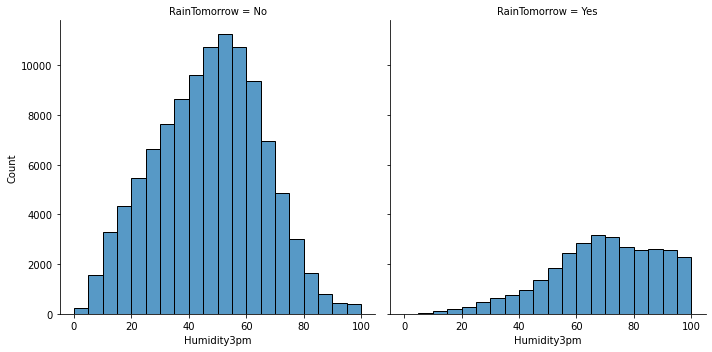

In [127]:
# Plot distribution with histogram
sns.displot(weather_df, x = 'Humidity3pm', col = 'RainTomorrow', bins = 20)

<AxesSubplot:xlabel='RainTomorrow', ylabel='Humidity3pm'>

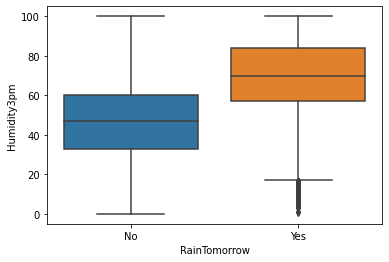

In [128]:
sns.boxplot(x = weather_df['RainTomorrow'], y = weather_df['Humidity3pm'])

Similar to MinTemp, I would attempt to assess the predictive power of Humidity3pm on RainTomorrow with two-sample t-test. Earlier calculation has shown both groups have approximately equal variances. Hence, I only checked for normal distribution assumption before conducting the t-test. 

In [129]:
yes, no, verdict = normal_distribution_test(weather_df, ['Humidity3pm'])
verdict

'Both groups are normally distributed'

In [130]:
# Use two-sample t-test to check for dependence
res = stats.ttest_ind(yes, no, equal_var = True, nan_policy = 'omit')
display(res)

Ttest_indResult(statistic=185.5848864315162, pvalue=0.0)

At 95% level of confidence, since p-value is smaller than the threshold of 5%, I reject the null hypothesis of equal averages. Therefore, Humidity3pm and RainTomorrow are dependent. I will consider Humidity3pm as a relevant feature for the model. 

#### Pressure9am

In [131]:
# Check for missing values
null_pressure9am = weather_df[weather_df['Pressure9am'].isnull()]
null_pressure9am

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season
984,2011-09-11,Albury,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,2011,Spring
985,2011-09-12,Albury,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,2011,Spring
986,2011-09-13,Albury,NaN,15.8,NaN,NaN,NaN,NaN,NaN,NaN,NNW,NaN,9.0,NaN,47.0,NaN,1023.9,NaN,5.0,NaN,15.1,NaN,NaN,9,2011,Spring
2032,2014-09-22,Albury,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,2014,Spring
2033,2014-09-23,Albury,NaN,24.1,NaN,NaN,NaN,NaN,NaN,NaN,SE,NaN,11.0,NaN,32.0,NaN,1024.0,NaN,NaN,NaN,22.3,NaN,NaN,9,2014,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144270,2014-03-24,Uluru,NaN,31.0,NaN,NaN,NaN,NaN,NaN,ESE,ESE,28.0,15.0,28.0,22.0,NaN,1013.8,NaN,NaN,22.5,29.3,NaN,NaN,3,2014,Autumn
144307,2014-04-30,Uluru,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ESE,NaN,17.0,NaN,40.0,NaN,1017.5,NaN,NaN,NaN,21.5,NaN,NaN,4,2014,Autumn
144310,2014-05-03,Uluru,NaN,21.4,NaN,NaN,NaN,S,39.0,NaN,SSW,NaN,13.0,NaN,35.0,NaN,1015.9,NaN,NaN,NaN,20.6,NaN,NaN,5,2014,Autumn
144331,2014-05-24,Uluru,8.5,29.1,NaN,NaN,NaN,N,24.0,NaN,W,NaN,11.0,NaN,27.0,NaN,1015.4,NaN,NaN,NaN,28.6,NaN,No,5,2014,Autumn


In [132]:
# Check for distribution of missing Pressure9am
null_pressure9am_freq = pd.crosstab(null_pressure9am['Year'], null_pressure9am['Location'])
null_pressure9am_freq

Location,Adelaide,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,Mildura,MountGambier,MountGinini,Newcastle,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,PerthAirport,Portland,Richmond,Sale,SalmonGums,Sydney,SydneyAirport,Tuggeranong,Uluru,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,31,0,0,0,0,0,31,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2009,1,2,0,0,1,8,0,0,0,153,3,1,64,0,0,0,0,0,0,0,0,365,365,0,15,1,0,3,364,0,0,8,2,2,365,2,0,2,0,13,0,0,2,3,0
2010,0,5,0,0,15,3,9,1,0,62,1,2,0,0,0,1,0,0,0,2,0,365,365,0,9,1,2,8,365,0,0,3,8,2,357,16,0,9,0,0,1,5,1,6,0
2011,0,1,3,0,0,4,1,0,0,4,3,1,0,1,0,0,0,0,0,0,0,335,335,0,0,1,3,5,335,0,1,1,0,5,335,0,5,0,0,9,0,1,131,31,8
2012,1,13,0,0,0,1,4,0,0,2,1,0,0,0,0,0,0,0,0,0,0,335,335,0,0,0,0,1,335,1,0,0,9,3,335,0,2,0,0,0,0,1,0,0,0
2013,0,0,0,0,0,0,0,0,0,4,0,4,0,0,0,0,0,0,0,1,1,337,337,0,3,0,2,0,337,0,0,0,5,1,337,0,0,3,1,5,0,4,0,1,1
2014,0,0,2,1,2,0,0,0,0,0,20,245,0,0,0,0,0,246,0,0,0,365,365,5,6,1,0,2,365,0,0,0,4,0,365,1,0,1,8,0,0,1,0,8,1
2015,5,1,0,0,134,8,0,0,0,1,0,57,0,0,0,0,1,365,359,0,0,365,365,0,1,2,0,0,365,0,1,0,0,0,365,0,0,0,0,0,0,0,0,1,0
2016,0,0,0,0,16,0,0,0,1,0,0,1,0,0,1,0,0,366,121,1,0,366,366,0,0,2,0,2,366,0,0,0,1,0,366,0,1,0,1,1,0,0,0,0,1


After analysing the distribution across Location, Month and assessing for any potential correlation with other numerical features, I did not find any patterns for missing values. Therefore, I concluded that Pressure9am has missing values randomly. 

To deal with the 15,065 missing values, I will impute the missing values with forward fill method.

In [133]:
weather_df['Pressure9am'].skew()

-0.09552363669451734

<AxesSubplot:ylabel='Pressure9am'>

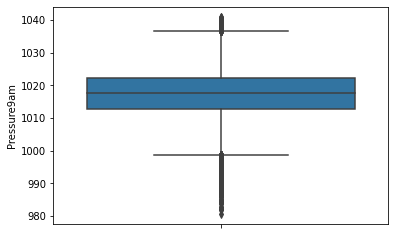

In [134]:
# Check for outliers with boxplot 
sns.boxplot(y = weather_df['Pressure9am'])

In [135]:
# Identify outliers
isolate_outlier(weather_df, weather_df['Pressure9am'])

lower_whisker:  998.65 upper_whisker:  1036.65


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season
12,2008-12-13,Albury,15.9,18.6,15.6,NaN,NaN,W,61.0,NNW,NNW,28.0,28.0,76.0,93.0,994.3,993.0,8.0,8.0,17.4,15.8,Yes,Yes,12,2008,Summer
296,2009-09-23,Albury,9.3,16.8,28.8,NaN,NaN,W,56.0,W,WSW,26.0,30.0,82.0,54.0,997.8,1003.8,5.0,8.0,13.1,15.9,Yes,Yes,9,2009,Spring
568,2010-06-22,Albury,3.0,14.8,0.0,NaN,NaN,SE,15.0,NaN,SE,0.0,7.0,94.0,61.0,1037.3,1035.2,NaN,NaN,6.1,14.7,No,No,6,2010,Winter
569,2010-06-23,Albury,3.5,16.5,0.0,NaN,NaN,E,20.0,NaN,E,0.0,7.0,89.0,52.0,1036.9,1032.9,NaN,8.0,7.2,15.5,No,No,6,2010,Winter
683,2010-10-15,Albury,13.8,18.6,22.2,NaN,NaN,WNW,63.0,NNW,NE,28.0,4.0,93.0,90.0,989.8,982.9,8.0,8.0,18.5,17.1,Yes,Yes,10,2010,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136867,2011-02-05,AliceSprings,22.4,27.8,7.4,7.4,1.1,N,59.0,SW,SW,20.0,30.0,96.0,91.0,997.7,995.0,7.0,7.0,23.3,24.9,Yes,Yes,2,2011,Summer
137195,2012-01-29,AliceSprings,20.4,41.0,0.0,12.4,10.3,W,41.0,NNE,NNE,13.0,11.0,23.0,10.0,998.3,995.3,3.0,7.0,33.4,38.7,No,No,1,2012,Summer
140071,2011-02-16,Darwin,22.1,25.6,367.6,NaN,0.0,WSW,83.0,SSE,WSW,20.0,46.0,98.0,98.0,996.3,996.0,8.0,8.0,24.3,23.5,Yes,Yes,2,2011,Summer
145278,2016-12-26,Uluru,22.1,27.4,83.8,NaN,NaN,ENE,72.0,N,NNW,31.0,43.0,100.0,100.0,994.6,989.2,8.0,8.0,22.2,24.2,Yes,Yes,12,2016,Summer


In this case, after observing the outliers and validating it with real-life observations, the outliers are perfectly normal and simply reflect different extremes across locations. Additionally, I want to predict RainTomorrow across a very wide range of weather scenarios and locations. Thus, it makes sense to retain the outliers. 

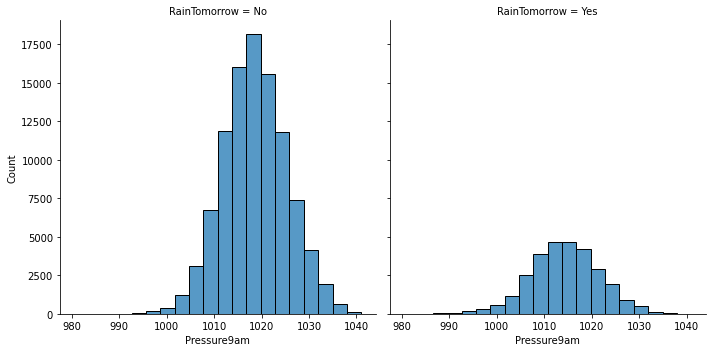

In [136]:
# Plot distribution with histogram
sns.displot(weather_df, x = 'Pressure9am', col = 'RainTomorrow', bins = 20)

<AxesSubplot:xlabel='RainTomorrow', ylabel='Pressure9am'>

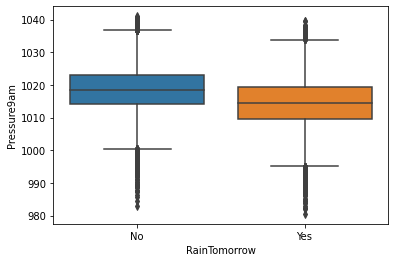

In [137]:
sns.boxplot(x = weather_df['RainTomorrow'], y = weather_df['Pressure9am'])

Similar to MinTemp, I would attempt to assess the predictive power of Pressure9am on RainTomorrow with two-sample t-test. Earlier calculation has shown both groups have approximately equal variances. Hence, I only checked for normal distribution assumption before conducting the t-test. 

In [138]:
yes, no, verdict = normal_distribution_test(weather_df, ['Pressure9am'])
verdict

'Both groups are normally distributed'

In [139]:
# Use two-sample t-test to check for dependence
res = stats.ttest_ind(yes, no, equal_var = True, nan_policy = 'omit')
display(res)

Ttest_indResult(statistic=-91.01069762151796, pvalue=0.0)

At 95% level of confidence, since p-value is smaller than the threshold of 5%, I reject the null hypothesis of equal averages. Therefore, Pressure9am and RainTomorrow are dependent. I will consider Pressure9am as a relevant feature for the model. 

#### Pressure3pm

In [140]:
# Check for missing values
null_pressure3pm = weather_df[weather_df['Pressure3pm'].isnull()]
null_pressure3pm

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season
984,2011-09-11,Albury,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,2011,Spring
985,2011-09-12,Albury,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,2011,Spring
1058,2011-11-24,Albury,10.8,26.0,0.0,NaN,NaN,NaN,NaN,SE,NaN,19.0,NaN,44.0,NaN,1024.5,NaN,NaN,NaN,17.2,NaN,No,Yes,11,2011,Spring
1059,2011-11-25,Albury,15.0,20.0,11.0,NaN,NaN,NaN,NaN,SSE,NaN,11.0,NaN,99.0,NaN,1020.1,NaN,8.0,NaN,15.0,NaN,Yes,Yes,11,2011,Spring
1060,2011-11-26,Albury,15.0,25.0,44.0,NaN,NaN,NaN,NaN,NE,NaN,13.0,NaN,83.0,NaN,1006.2,NaN,3.0,NaN,20.0,NaN,Yes,Yes,11,2011,Spring
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143539,2016-07-18,Katherine,8.0,28.7,0.0,6.8,NaN,E,35.0,SE,NaN,7.0,NaN,53.0,NaN,1015.5,NaN,0.0,NaN,17.5,NaN,No,No,7,2016,Winter
144203,2014-01-16,Uluru,24.0,30.4,0.4,NaN,NaN,NE,50.0,ENE,NaN,20.0,NaN,74.0,NaN,1006.4,NaN,NaN,NaN,25.4,NaN,No,Yes,1,2014,Summer
144242,2014-02-24,Uluru,18.4,NaN,0.0,NaN,NaN,NaN,NaN,ESE,NaN,22.0,NaN,23.0,NaN,1014.1,NaN,NaN,NaN,24.9,NaN,No,NaN,2,2014,Summer
144260,2014-03-14,Uluru,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2014,Autumn


In [141]:
# Check for distribution of missing Pressure9am
null_pressure3pm_freq = pd.crosstab(null_pressure3pm['Year'], null_pressure3pm['Location'])
null_pressure3pm_freq

Location,Adelaide,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,Mildura,Moree,MountGambier,MountGinini,Newcastle,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,PerthAirport,Portland,Richmond,Sale,SalmonGums,Sydney,SydneyAirport,Tuggeranong,Uluru,Walpole,Williamtown,Witchcliffe,Wollongong,Woomera
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,31,31,0,0,0,0,0,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2009,1,1,0,0,6,7,1,2,153,0,3,64,0,0,0,0,1,0,0,0,0,365,365,0,11,0,2,6,364,0,1,5,2,3,365,1,0,1,0,12,2,1,1,0
2010,2,3,0,1,15,7,6,3,62,1,1,1,0,0,0,0,0,0,0,0,0,365,365,0,7,0,0,6,365,0,0,4,6,2,357,17,1,10,0,0,5,0,4,2
2011,0,0,6,0,3,5,1,2,3,3,0,0,1,0,0,0,0,1,0,0,2,335,335,0,1,0,1,2,335,1,0,1,1,4,335,0,1,0,0,9,1,132,12,9
2012,0,14,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,335,335,0,0,0,3,5,335,0,0,0,18,2,335,0,0,0,0,1,1,1,0,0
2013,0,1,1,0,0,0,0,0,1,0,3,0,1,0,0,0,0,1,1,0,1,337,337,0,2,0,1,2,337,0,0,0,3,1,337,0,0,0,0,3,1,0,0,1
2014,0,0,1,1,2,0,0,0,2,20,245,0,0,0,0,0,245,0,0,0,1,365,365,5,5,0,0,4,365,0,0,0,3,1,365,0,0,0,4,1,1,0,2,0
2015,4,2,0,0,132,7,0,0,0,0,55,0,0,0,0,2,365,360,0,0,0,365,365,0,0,2,0,0,365,0,0,0,1,0,365,0,0,0,0,0,0,0,0,2
2016,0,0,0,0,15,0,0,0,0,0,4,0,0,1,0,3,366,121,1,0,1,366,366,0,0,0,1,3,366,0,0,0,1,0,366,1,1,0,0,0,0,0,0,0


After analysing the distribution across Location, Month and assessing for any potential correlation with other numerical features, I did not find any patterns for missing values. Therefore, I concluded that Pressure3pm has missing values randomly. 

To deal with the 15,028 missing values, I will impute the missing values with forward fill method. 

In [142]:
weather_df['Pressure3pm'].skew()

-0.04562140480119886

<AxesSubplot:ylabel='Pressure3pm'>

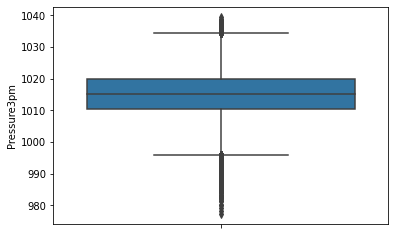

In [143]:
# Check for outliers with boxplot 
sns.boxplot(y = weather_df['Pressure3pm'])

In [144]:
# Identify outliers
isolate_outlier(weather_df, weather_df['Pressure3pm'])

lower_whisker:  996.0 upper_whisker:  1034.4


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season
12,2008-12-13,Albury,15.9,18.6,15.6,NaN,NaN,W,61.0,NNW,NNW,28.0,28.0,76.0,93.0,994.3,993.0,8.0,8.0,17.4,15.8,Yes,Yes,12,2008,Summer
568,2010-06-22,Albury,3.0,14.8,0.0,NaN,NaN,SE,15.0,NaN,SE,0.0,7.0,94.0,61.0,1037.3,1035.2,NaN,NaN,6.1,14.7,No,No,6,2010,Winter
683,2010-10-15,Albury,13.8,18.6,22.2,NaN,NaN,WNW,63.0,NNW,NE,28.0,4.0,93.0,90.0,989.8,982.9,8.0,8.0,18.5,17.1,Yes,Yes,10,2010,Spring
748,2010-12-19,Albury,10.4,18.0,3.0,NaN,NaN,W,61.0,ENE,NNW,9.0,13.0,71.0,55.0,998.8,994.3,8.0,8.0,15.0,17.4,Yes,Yes,12,2010,Summer
910,2011-06-29,Albury,0.9,16.6,0.0,NaN,NaN,ENE,17.0,NaN,ESE,0.0,6.0,81.0,50.0,1037.4,1035.1,NaN,NaN,5.6,16.1,No,No,6,2011,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136867,2011-02-05,AliceSprings,22.4,27.8,7.4,7.4,1.1,N,59.0,SW,SW,20.0,30.0,96.0,91.0,997.7,995.0,7.0,7.0,23.3,24.9,Yes,Yes,2,2011,Summer
137195,2012-01-29,AliceSprings,20.4,41.0,0.0,12.4,10.3,W,41.0,NNE,NNE,13.0,11.0,23.0,10.0,998.3,995.3,3.0,7.0,33.4,38.7,No,No,1,2012,Summer
138212,2015-01-09,AliceSprings,22.9,29.2,61.6,3.0,1.1,N,41.0,NW,SW,28.0,15.0,81.0,72.0,998.9,995.5,8.0,7.0,24.7,27.7,Yes,Yes,1,2015,Summer
145278,2016-12-26,Uluru,22.1,27.4,83.8,NaN,NaN,ENE,72.0,N,NNW,31.0,43.0,100.0,100.0,994.6,989.2,8.0,8.0,22.2,24.2,Yes,Yes,12,2016,Summer


In this case, after observing the outliers and validating it with real-life observations, the outliers are perfectly normal and simply reflect different extremes across locations. Additionally, I want to predict RainTomorrow across a very wide range of weather scenarios and locations. Thus, it makes sense to retain the outliers. 

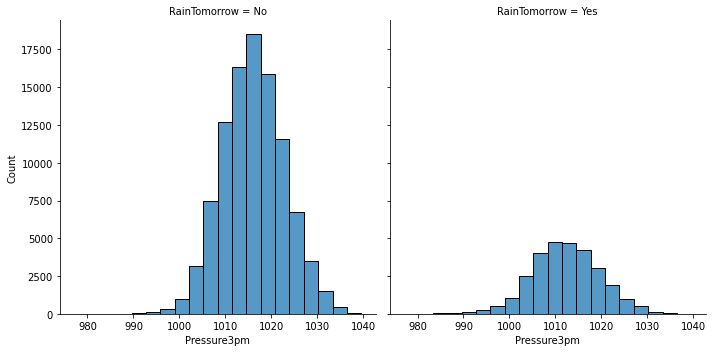

In [145]:
# Plot distribution with histogram
sns.displot(weather_df, x = 'Pressure3pm', col = 'RainTomorrow', bins = 20)

<AxesSubplot:xlabel='RainTomorrow', ylabel='Pressure3pm'>

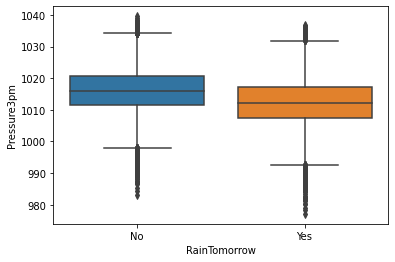

In [146]:
sns.boxplot(x = weather_df['RainTomorrow'], y = weather_df['Pressure3pm'])

Similar to MinTemp, I would attempt to assess the predictive power of Pressure3pm on RainTomorrow with two-sample t-test. Earlier calculation has shown both groups have approximately equal variances. Hence, I only checked for normal distribution assumption before conducting the t-test. 

In [147]:
yes, no, verdict = normal_distribution_test(weather_df, ['Pressure3pm'])
verdict

'Both groups are normally distributed'

In [148]:
# Use two-sample t-test to check for dependence
res = stats.ttest_ind(yes, no, equal_var = True, nan_policy = 'omit')
display(res)

Ttest_indResult(statistic=-83.08387476568964, pvalue=0.0)

At 95% level of confidence, since p-value is smaller than the threshold of 5%, I reject the null hypothesis of equal averages. Therefore, Pressure3pm and RainTomorrow are dependent. I will consider Pressure3pm as a relevant feature for the model. 

#### Cloud9am

In [149]:
# Check for missing values
null_cloud9am = weather_df[weather_df['Cloud9am'].isnull()]
null_cloud9am

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,12,2008,Summer
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,12,2008,Summer
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,12,2008,Summer
5,2008-12-06,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,W,19.0,24.0,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,No,12,2008,Summer
7,2008-12-08,Albury,7.7,26.7,0.0,NaN,NaN,W,35.0,SSE,W,6.0,17.0,48.0,19.0,1013.4,1010.1,NaN,NaN,16.3,25.5,No,No,12,2008,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145453,2017-06-19,Uluru,7.4,20.6,0.0,NaN,NaN,E,35.0,ESE,E,15.0,17.0,63.0,33.0,1027.2,1023.3,NaN,NaN,11.0,20.3,No,No,6,2017,Winter
145454,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,E,15.0,13.0,59.0,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No,No,6,2017,Winter
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No,6,2017,Winter
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No,6,2017,Winter


In [150]:
# Check for distribution of missing Pressure9am
null_cloud9am_freq = pd.crosstab(null_cloud9am['Year'], null_cloud9am['Location'])
null_cloud9am_freq

Location,Adelaide,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,Mildura,Moree,MountGambier,MountGinini,Newcastle,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,PerthAirport,Portland,Richmond,Sale,SalmonGums,Sydney,SydneyAirport,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Williamtown,Witchcliffe,Wollongong,Woomera
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008,184,0,20,0,0,0,0,0,0,0,0,0,0,0,31,0,0,31,0,0,0,0,31,3,0,0,0,0,0,31,0,0,0,0,0,0,0,0,0,31,0,0,0,0,0,17,0
2009,365,1,242,3,365,5,3,0,0,153,4,0,365,0,365,2,0,365,1,1,0,0,365,22,0,365,1,53,94,364,1,1,6,365,3,365,1,0,0,365,0,2,365,2,365,220,2
2010,365,0,197,7,365,3,2,0,0,60,3,0,365,0,365,32,0,365,41,1,0,0,365,36,0,365,0,10,109,365,0,0,7,365,1,357,46,0,0,365,0,1,365,13,365,203,23
2011,335,0,224,6,335,2,0,0,2,28,14,2,335,0,335,335,0,335,130,0,13,2,335,25,0,335,1,1,99,335,0,0,6,335,0,335,335,0,0,335,0,1,332,56,335,183,23
2012,335,1,184,4,335,39,57,0,1,28,15,3,335,0,335,335,0,335,113,11,20,1,335,31,0,335,1,4,96,335,0,0,34,335,10,335,182,0,0,334,0,1,335,90,335,209,45
2013,337,2,206,5,337,132,202,0,0,135,17,10,337,0,337,337,9,337,126,7,6,2,337,27,306,332,0,7,96,337,0,0,101,337,5,337,0,0,0,337,306,2,337,83,337,223,41
2014,365,5,188,6,365,127,225,1,1,204,14,248,365,0,365,120,5,210,139,2,87,0,365,21,365,365,1,12,96,365,0,0,105,242,1,365,0,0,0,365,314,1,365,82,365,219,93
2015,365,5,192,5,365,99,211,0,13,195,23,242,365,0,365,1,6,147,363,9,102,2,365,22,365,365,1,12,148,365,1,1,58,165,132,365,1,1,0,365,261,4,365,55,365,171,77
2016,366,9,192,161,366,77,163,0,110,175,155,228,366,1,366,1,11,120,121,20,185,54,366,34,366,366,38,23,194,366,0,0,59,197,117,366,1,1,96,366,221,100,366,156,366,181,52


After analysing the distribution across Location, Month and assessing for any potential correlation with other numerical features, I observed that certain locations (e.g. Badgerys Creek, Dartmoor, etc.) do not have any cloud cover readings. Therefore, I concluded that Cloud9am has missing values systematically. 

To deal with the 55,888 missing values, I will impute the missing values with forward fill method. 

In [151]:
weather_df['Cloud9am'].skew()

-0.229081832248417

<AxesSubplot:ylabel='Cloud9am'>

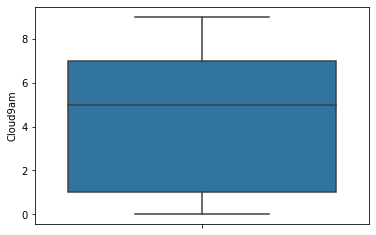

In [152]:
# Check for outliers with boxplot 
sns.boxplot(y = weather_df['Cloud9am'])

Fortunately there is no outlier because all values conform to the expected range between 0 to 9. 

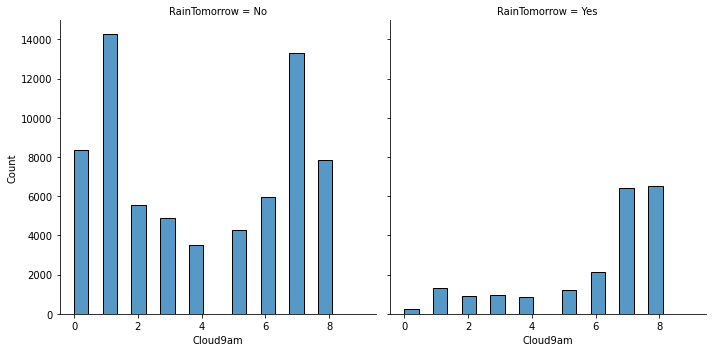

In [153]:
# Plot distribution with histogram
sns.displot(weather_df, x = 'Cloud9am', col = 'RainTomorrow', bins = 20)

<AxesSubplot:xlabel='RainTomorrow', ylabel='Cloud9am'>

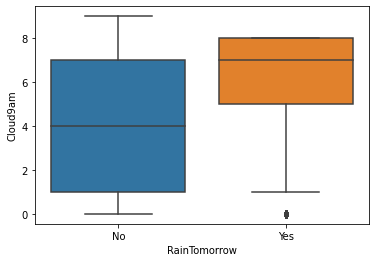

In [154]:
sns.boxplot(x = weather_df['RainTomorrow'], y = weather_df['Cloud9am'])

Similar to MinTemp, I would attempt to assess the predictive power of Cloud9am on RainTomorrow with two-sample t-test. Earlier calculation has shown both groups have approximately equal variances. Hence, I only checked for normal distribution assumption before conducting the t-test. 

In [155]:
yes, no, verdict = normal_distribution_test(weather_df, ['Cloud9am'])
verdict

'Both groups are normally distributed'

In [156]:
# Use two-sample t-test to check for dependence
res = stats.ttest_ind(yes, no, equal_var = True, nan_policy = 'omit')
display(res)

Ttest_indResult(statistic=99.58393946626623, pvalue=0.0)

At 95% level of confidence, since p-value is smaller than the threshold of 5%, I reject the null hypothesis of equal averages. Therefore, Cloud9am and RainTomorrow are dependent. I will consider Pressure3pm as a relevant feature for the model. 

#### Cloud3pm

In [157]:
# Check for missing values
null_cloud3pm = weather_df[weather_df['Cloud3pm'].isnull()]
null_cloud3pm

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,12,2008,Summer
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,12,2008,Summer
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,12,2008,Summer
5,2008-12-06,Albury,14.6,29.7,0.2,NaN,NaN,WNW,56.0,W,W,19.0,24.0,55.0,23.0,1009.2,1005.4,NaN,NaN,20.6,28.9,No,No,12,2008,Summer
6,2008-12-07,Albury,14.3,25.0,0.0,NaN,NaN,W,50.0,SW,W,20.0,24.0,49.0,19.0,1009.6,1008.2,1.0,NaN,18.1,24.6,No,No,12,2008,Summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145453,2017-06-19,Uluru,7.4,20.6,0.0,NaN,NaN,E,35.0,ESE,E,15.0,17.0,63.0,33.0,1027.2,1023.3,NaN,NaN,11.0,20.3,No,No,6,2017,Winter
145454,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,E,15.0,13.0,59.0,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No,No,6,2017,Winter
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No,6,2017,Winter
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No,6,2017,Winter


In [158]:
# Check for distribution of missing Pressure9am
null_cloud3pm_freq = pd.crosstab(null_cloud3pm['Year'], null_cloud3pm['Location'])
null_cloud3pm_freq

Location,Adelaide,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,MountGinini,Newcastle,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,PerthAirport,Portland,Richmond,Sale,SalmonGums,Sydney,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2008,184,1,19,0,0,10,0,0,0,0,0,0,0,0,31,2,0,31,0,0,0,0,0,31,4,0,0,0,0,0,31,0,0,0,0,0,0,0,0,31,0,0,0,0,0,0,14,0
2009,365,3,236,11,365,170,3,0,1,153,4,1,365,1,365,3,0,365,0,0,3,1,1,365,35,0,365,0,62,103,364,2,2,19,365,3,365,0,0,365,0,1,365,0,32,365,207,1
2010,365,0,189,20,365,107,2,0,0,60,2,1,365,0,365,35,0,364,42,0,5,3,1,365,50,0,365,0,8,120,365,1,1,16,365,3,357,46,1,365,0,0,365,0,23,365,185,26
2011,335,0,237,17,335,131,2,0,1,67,11,4,335,1,335,335,0,335,145,0,3,13,4,335,36,0,335,0,1,91,335,0,0,22,335,0,335,335,1,335,0,1,332,0,61,335,175,32
2012,335,3,154,16,335,124,53,2,5,170,12,7,335,0,335,335,0,335,122,0,8,16,4,335,44,0,335,0,6,113,335,0,0,46,335,13,335,182,7,334,0,1,335,0,78,335,207,57
2013,337,2,180,17,337,123,152,0,1,179,24,10,337,1,337,337,13,337,139,0,10,10,4,337,31,306,332,2,8,114,337,0,0,94,337,4,337,0,5,337,306,0,337,0,90,337,219,61
2014,365,4,174,12,365,125,173,0,2,199,16,250,365,0,365,120,11,209,174,0,1,66,1,365,26,365,365,1,33,132,365,0,0,132,248,2,365,0,16,365,307,0,365,0,83,365,220,104
2015,365,156,164,10,365,107,151,0,18,174,12,216,365,0,365,0,158,135,363,1,17,75,6,365,166,365,365,8,169,156,365,1,1,71,158,140,365,0,1,365,214,5,365,1,58,365,151,85
2016,366,366,146,138,366,94,145,0,130,158,127,212,366,0,366,1,366,112,121,0,52,135,39,366,366,366,366,31,306,185,366,0,0,76,207,126,366,0,161,366,217,76,366,0,152,366,172,176


Similar to Cloud9am, Cloud3pm also has missing values systematically at specific locations (e.g. Badgerys Creek, Dartmoor and so on). 

To deal with the 59,358 missing values, I will impute the missing values with forward fill method. 

In [159]:
weather_df['Cloud3pm'].skew()

-0.22638434607149094

<AxesSubplot:ylabel='Cloud3pm'>

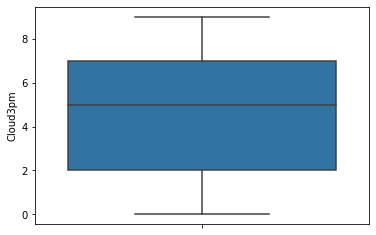

In [160]:
# Check for outliers with boxplot 
sns.boxplot(y = weather_df['Cloud3pm'])

In this case, there is no outlier because all values conform to the expected range between 0 to 9. 

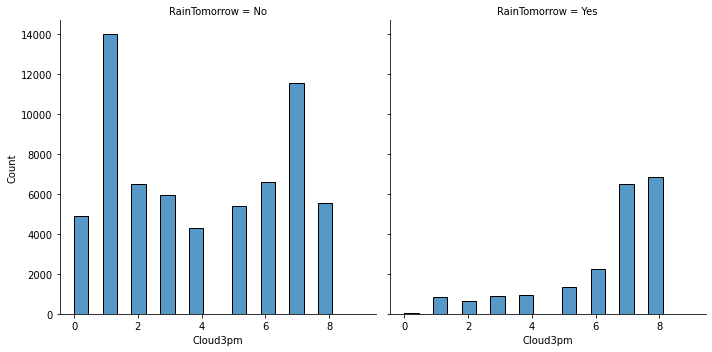

In [161]:
# Plot distribution with histogram
sns.displot(weather_df, x = 'Cloud3pm', col = 'RainTomorrow', bins = 20)

<AxesSubplot:xlabel='RainTomorrow', ylabel='Cloud3pm'>

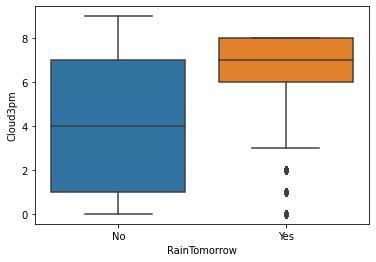

In [162]:
sns.boxplot(x = weather_df['RainTomorrow'], y = weather_df['Cloud3pm'])

Similar to MinTemp, I would attempt to assess the predictive power of Pressure3pm on RainTomorrow with two-sample t-test. Earlier calculation has shown both groups have approximately equal variances. Hence, I only checked for normal distribution assumption before conducting the t-test. 

In [163]:
yes, no, verdict = normal_distribution_test(weather_df, ['Cloud3pm'])
verdict

'Both groups are normally distributed'

In [164]:
# Use two-sample t-test to check for dependence
res = stats.ttest_ind(yes, no, equal_var = True, nan_policy = 'omit')
display(res)

Ttest_indResult(statistic=120.53126321396545, pvalue=0.0)

At 95% level of confidence, since p-value is smaller than the threshold of 5%, I reject the null hypothesis of equal averages. Therefore,Cloud3pm and RainTomorrow are dependent. I will consider Pressure3pm as a relevant feature for the model. 

### RECAPS

**Decisions**
1. Retain all outliers since they reflect normal weather observations across different climates in Australia
2. Impute missing values with forward fill method to retain the seasonality and location-specific weather patterns. 

**Action Items**
1. Split data into training and testing set
2. Impute missing values for all numerical features

## Data Preparation

### Dealing with missing values

#### Numerical features: impute with forward fill method

Weather observations greatly vary according to specific locations and seasons. Therefore, it would be flawed to impute missing numerical values with the mean value of the entire population. I decided to impute missing values for all numerical features with forward fill method since it would best reflect the locations and seasonality. 

In [165]:
weather_df[['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'Rainfall', 
            'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 
           'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm']] = weather_df[['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 
           'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm']].fillna(method='ffill')
weather_df.isnull().sum()

Date                 0
Location             0
MinTemp              0
MaxTemp              0
Rainfall             0
Evaporation       6049
Sunshine          6049
WindGustDir      10326
WindGustSpeed        0
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am         0
WindSpeed3pm         0
Humidity9am          0
Humidity3pm          0
Pressure9am          0
Pressure3pm          0
Cloud9am             0
Cloud3pm             2
Temp9am              0
Temp3pm              0
RainToday         3261
RainTomorrow      3267
Month                0
Year                 0
Season               0
dtype: int64

In [166]:
null_evaporation_sunshine = weather_df[weather_df['Evaporation'].isnull()]

In [167]:
null_evaporation_sunshine_freq = pd.crosstab(null_evaporation_sunshine['Year'], null_evaporation_sunshine['Location'])
null_evaporation_sunshine_freq

Location,Albury,BadgerysCreek
Year,,
2008,31,0
2009,365,365
2010,365,365
2011,335,335
2012,335,335
2013,337,337
2014,365,365
2015,365,365
2016,366,366


There are 2 records with missing values for Cloud3pm. Since this is insignificant, I will remove these 2 records. Additionally, there are 3,267 records with missing labels (i.e. RainTomorrow is null). I will also remove these records because having missing labels mean these records will not give any information for the model to learn. 

Evaporation and sunshine are still completely missing after applying forward fill method. Assuming weather observations would be similar for nearly locations, I will impute the remaining missing values for numerical features with observations at neighbouring places. Specifically, Albury's incomplete observations will be impute with Canberra's readings. Badgerys Creek's null values will be replaced with Sydney's observations. 

In [168]:
# Extract observations at Wagga Wagga
canberra_observations = weather_df.query('Location == "Canberra"')[['Date','Evaporation', 'Sunshine']]

# Extract Albury's records
albury_observations = weather_df.query('Location == "Albury"')

# Merge 2 dataframes and impute missing values
albury_merge = pd.merge(albury_observations, canberra_observations, on = ['Date', 'Date'])
albury_merge['Evaporation'] = albury_merge['Evaporation_y']
albury_merge['Sunshine'] = albury_merge['Sunshine_y']
albury_merge = albury_merge.drop(columns = ['Evaporation_x', 'Sunshine_x', 'Evaporation_y', 'Sunshine_y'])
albury_merge

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season,Evaporation,Sunshine
0,2008-12-01,Albury,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,12,2008,Summer,9.6,13.0
1,2008-12-02,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,8.0,NaN,17.2,24.3,No,No,12,2008,Summer,13.0,13.2
2,2008-12-03,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,No,No,12,2008,Summer,10.2,13.2
3,2008-12-04,Albury,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,8.0,2.0,18.1,26.5,No,No,12,2008,Summer,11.0,10.8
4,2008-12-05,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,12,2008,Summer,6.6,8.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3035,2017-06-21,Albury,1.2,15.2,0.4,ENE,15.0,NaN,NNE,0.0,2.0,100.0,62.0,1029.4,1026.7,8.0,7.0,2.9,14.3,No,No,6,2017,Winter,1.6,2.8
3036,2017-06-22,Albury,0.8,13.4,0.0,W,17.0,S,NaN,6.0,0.0,100.0,66.0,1029.4,1025.9,8.0,1.0,3.6,13.3,No,No,6,2017,Winter,1.6,2.8
3037,2017-06-23,Albury,1.1,11.9,0.0,SE,44.0,SSE,SSE,9.0,2.0,100.0,81.0,1022.3,1017.7,8.0,1.0,2.7,10.2,No,No,6,2017,Winter,1.6,2.8
3038,2017-06-24,Albury,1.1,14.1,0.2,WSW,28.0,SW,W,4.0,15.0,100.0,49.0,1018.8,1017.2,7.0,6.0,3.9,13.1,No,No,6,2017,Winter,1.6,2.8


In [169]:
# Extract observations at Sydney
sydney_observations = weather_df.query('Location == "Sydney"')[['Date','Evaporation', 'Sunshine']]

# Extract Albury's records
badgery_observations = weather_df.query('Location == "BadgerysCreek"')
badgery_observations

# Merge 2 dataframes and impute missing values
badgery_merge = pd.merge(badgery_observations, sydney_observations, on = ['Date', 'Date'])
badgery_merge['Evaporation'] = badgery_merge['Evaporation_y']
badgery_merge['Sunshine'] = badgery_merge['Sunshine_y']
badgery_merge = badgery_merge.drop(columns = ['Evaporation_x', 'Sunshine_x', 'Evaporation_y', 'Sunshine_y'])
badgery_merge

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month,Year,Season,Evaporation,Sunshine
0,2009-01-01,BadgerysCreek,13.3,34.2,0.0,W,61.0,NNE,NaN,11.0,0.0,67.0,82.0,1005.6,1018.8,7.0,8.0,21.0,8.8,No,No,1,2009,Summer,9.8,12.9
1,2009-01-02,BadgerysCreek,14.7,26.1,0.0,SE,46.0,SE,SE,7.0,24.0,59.0,54.0,1012.9,1013.5,7.0,8.0,20.7,22.2,No,No,1,2009,Summer,11.0,5.9
2,2009-01-03,BadgerysCreek,13.6,22.3,0.0,NNE,30.0,ESE,NE,6.0,15.0,57.0,51.0,1021.9,1019.2,7.0,8.0,17.9,21.7,No,No,1,2009,Summer,9.0,0.5
3,2009-01-04,BadgerysCreek,17.7,31.2,0.0,NE,39.0,NNE,N,9.0,15.0,62.0,43.0,1018.7,1013.6,7.0,8.0,22.0,30.6,No,No,1,2009,Summer,5.4,11.3
4,2009-01-05,BadgerysCreek,15.5,38.8,0.0,SW,50.0,NNE,W,7.0,17.0,67.0,19.0,1013.2,1007.6,7.0,8.0,22.7,37.6,No,No,1,2009,Summer,10.0,12.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3004,2017-06-21,BadgerysCreek,4.1,19.0,0.2,SSE,26.0,SW,SE,6.0,11.0,99.0,61.0,1026.5,1025.7,7.0,8.0,8.5,16.4,No,No,6,2017,Winter,2.0,7.8
3005,2017-06-22,BadgerysCreek,6.8,18.3,0.0,SW,17.0,SW,NNW,11.0,6.0,92.0,55.0,1028.8,1024.6,7.0,8.0,10.7,17.9,No,No,6,2017,Winter,2.0,9.2
3006,2017-06-23,BadgerysCreek,3.8,16.8,0.2,SW,17.0,NaN,N,0.0,7.0,100.0,64.0,1021.0,1015.1,7.0,8.0,6.8,16.0,No,No,6,2017,Winter,2.4,2.7
3007,2017-06-24,BadgerysCreek,2.7,18.8,0.0,SSW,24.0,NW,WSW,4.0,7.0,96.0,40.0,1017.7,1015.4,7.0,8.0,8.6,18.5,No,No,6,2017,Winter,1.4,9.3


In [170]:
# Delete all Albury and Badgerys Creek's records (currently having missing values)
weather_df = weather_df[weather_df['Sunshine'].notnull()]
weather_df.shape

# Append Albury and Badgerys Creek's records (with missing values imputed)
weather_df = weather_df.append(albury_merge, ignore_index = True, verify_integrity = True)
weather_df = weather_df.append(badgery_merge, ignore_index = True, verify_integrity = True)

weather_df.shape

(145460, 26)

In [171]:
# Remove records with null RainTomorrow and Cloud3pm
weather_df = weather_df[weather_df['RainTomorrow'].notnull()]
weather_df = weather_df[weather_df['Cloud3pm'].notnull()]

### Splitting data into training set and test set

In [172]:
# Separate label (y) and predicting features (X)
X = weather_df.drop(columns = ['RainTomorrow', 'Date'])
y = weather_df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Handling missing values and encoding categorical features

As mentioned earlier, missing values for categorical features appear systematically. Therefore, I will treat missing values as another value and encode it accordingly. 

Machine learning and deep learning models, like those in Keras, require all input and output variables to be numeric. This means that if our data contains categorical data, we must encode it to numbers before we can fit and evaluate a model. Considering different encoding methods, here is how I plan to encode categorical features.
1. Ordinal encoding: applicable for Cloud9am, Cloud3pm because the data itself follows an order
2. One-hot encoding: applicable for RainToday, Season because the cardinality is low enough to avoid having too many new features
3. Binary encoding: applicable for Location, WindGustDir, WindDir9am, WindDir3pm because of high cardinality

#### One-hot Encoding

In [173]:
# One-hot encoding with category_encoders library

encoder = ce.OneHotEncoder(cols = ['RainToday', 'Season'], return_df = True)
X_train_transformed = encoder.fit_transform(X_train, y_train)
X_test_transformer = encoder.transform(X_test)
X_train_transformed

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday_1,RainToday_2,RainToday_3,Month,Year,Season_1,Season_2,Season_3,Season_4
86234,GoldCoast,14.2,24.2,0.0,13.6,8.1,NNE,41.0,NW,NNE,19.0,31.0,55.0,66.0,1020.0,1017.3,4.0,2.0,21.7,22.3,1,0,0,10,2014,1,0,0,0
55250,Sale,7.9,13.7,2.6,2.0,7.2,W,48.0,WNW,WSW,22.0,19.0,81.0,58.0,1017.9,1019.3,4.0,6.0,9.3,11.6,0,1,0,4,2009,0,1,0,0
83471,Cairns,16.2,26.6,0.6,4.4,10.8,SSE,33.0,W,ESE,9.0,19.0,75.0,40.0,1017.7,1014.4,1.0,1.0,21.3,26.0,1,0,0,7,2015,0,0,1,0
38863,Wollongong,13.1,21.0,0.0,47.0,7.4,NE,35.0,NW,NNE,22.0,22.0,53.0,76.0,1025.0,1020.1,1.0,7.0,17.2,18.2,1,0,0,8,2015,0,0,1,0
58796,MelbourneAirport,7.1,16.2,0.4,4.0,5.6,W,43.0,W,W,20.0,28.0,74.0,55.0,1015.5,1015.7,7.0,7.0,11.2,15.2,1,0,0,10,2010,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113089,PerthAirport,9.5,20.5,0.2,3.6,4.4,ENE,20.0,S,WSW,9.0,13.0,87.0,48.0,1018.9,1014.9,7.0,5.0,13.9,19.6,1,0,0,5,2013,0,1,0,0
122905,Walpole,14.4,22.2,0.0,1.6,7.9,S,41.0,SSW,S,20.0,20.0,63.0,62.0,1017.9,1017.9,1.0,3.0,18.9,19.8,1,0,0,1,2015,0,0,0,1
106220,Witchcliffe,8.5,17.0,10.6,8.4,1.5,SSE,28.0,SSE,SSW,15.0,19.0,62.0,65.0,1020.3,1019.7,3.0,8.0,14.5,16.2,0,1,0,10,2010,1,0,0,0
135012,Darwin,24.1,28.4,42.0,4.2,0.0,WNW,63.0,WNW,NW,28.0,31.0,91.0,94.0,1005.3,1002.5,7.0,8.0,25.7,26.2,0,1,0,1,2014,0,0,0,1


#### Binary Encoding

In [174]:
# Binary encoding with category_encoders library
encoder = ce.BinaryEncoder(cols = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], return_df = True)
X_train_transformed = encoder.fit_transform(X_train_transformed, y_train)
X_test_transformer = encoder.transform(X_test_transformer)
X_train_transformed

,Location_0,Location_1,Location_2,Location_3,Location_4,Location_5,Location_6,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir_0,WindGustDir_1,WindGustDir_2,WindGustDir_3,WindGustDir_4,WindGustDir_5,WindGustSpeed,WindDir9am_0,WindDir9am_1,WindDir9am_2,WindDir9am_3,WindDir9am_4,WindDir9am_5,WindDir3pm_0,WindDir3pm_1,WindDir3pm_2,WindDir3pm_3,WindDir3pm_4,WindDir3pm_5,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday_1,RainToday_2,RainToday_3,Month,Year,Season_1,Season_2,Season_3,Season_4
86234,0,0,0,0,0,0,1,14.2,24.2,0.0,13.6,8.1,0,0,0,0,0,1,41.0,0,0,0,0,0,1,0,0,0,0,0,1,19.0,31.0,55.0,66.0,1020.0,1017.3,4.0,2.0,21.7,22.3,1,0,0,10,2014,1,0,0,0
55250,0,0,0,0,0,1,0,7.9,13.7,2.6,2.0,7.2,0,0,0,0,1,0,48.0,0,0,0,0,1,0,0,0,0,0,1,0,22.0,19.0,81.0,58.0,1017.9,1019.3,4.0,6.0,9.3,11.6,0,1,0,4,2009,0,1,0,0
83471,0,0,0,0,0,1,1,16.2,26.6,0.6,4.4,10.8,0,0,0,0,1,1,33.0,0,0,0,0,1,1,0,0,0,0,1,1,9.0,19.0,75.0,40.0,1017.7,1014.4,1.0,1.0,21.3,26.0,1,0,0,7,2015,0,0,1,0
38863,0,0,0,0,1,0,0,13.1,21.0,0.0,47.0,7.4,0,0,0,1,0,0,35.0,0,0,0,0,0,1,0,0,0,0,0,1,22.0,22.0,53.0,76.0,1025.0,1020.1,1.0,7.0,17.2,18.2,1,0,0,8,2015,0,0,1,0
58796,0,0,0,0,1,0,1,7.1,16.2,0.4,4.0,5.6,0,0,0,0,1,0,43.0,0,0,0,0,1,1,0,0,0,1,0,0,20.0,28.0,74.0,55.0,1015.5,1015.7,7.0,7.0,11.2,15.2,1,0,0,10,2010,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113089,0,1,0,0,1,0,1,9.5,20.5,0.2,3.6,4.4,0,0,1,1,1,0,20.0,0,0,1,0,0,1,0,0,0,0,1,0,9.0,13.0,87.0,48.0,1018.9,1014.9,7.0,5.0,13.9,19.6,1,0,0,5,2013,0,1,0,0
122905,0,0,1,1,0,1,1,14.4,22.2,0.0,1.6,7.9,0,1,0,0,0,0,41.0,0,0,1,0,1,1,0,0,1,1,1,1,20.0,20.0,63.0,62.0,1017.9,1017.9,1.0,3.0,18.9,19.8,1,0,0,1,2015,0,0,0,1
106220,0,1,1,0,0,0,0,8.5,17.0,10.6,8.4,1.5,0,0,0,0,1,1,28.0,0,0,0,1,1,1,0,0,1,0,0,1,15.0,19.0,62.0,65.0,1020.3,1019.7,3.0,8.0,14.5,16.2,0,1,0,10,2010,1,0,0,0
135012,0,1,0,1,0,0,1,24.1,28.4,42.0,4.2,0.0,0,0,0,1,0,1,63.0,0,0,0,0,1,0,0,0,1,0,0,0,28.0,31.0,91.0,94.0,1005.3,1002.5,7.0,8.0,25.7,26.2,0,1,0,1,2014,0,0,0,1


### Feature Scaling

Since several ML models (to classify whether it will rain tomorrow) works best when the data have zero mean and unit variance, feature scaling is recommended. I would try StandardScaler first. 

In [175]:
scaler = StandardScaler()
X_train_transformed = scaler.fit_transform(X_train_transformed, y_train)
X_test_transformer = scaler.transform(X_test_transformer)
X_train_transformed

array([[ 0.        , -0.76346498, -0.77214355, ..., -0.59589753,
        -0.58279134, -0.56294707],
       [ 0.        , -0.76346498, -0.77214355, ...,  1.67814086,
        -0.58279134, -0.56294707],
       [ 0.        , -0.76346498, -0.77214355, ..., -0.59589753,
         1.71587998, -0.56294707],
       ...,
       [ 0.        ,  1.30981778,  1.29509597, ..., -0.59589753,
        -0.58279134, -0.56294707],
       [ 0.        ,  1.30981778, -0.77214355, ..., -0.59589753,
        -0.58279134,  1.77636595],
       [ 0.        ,  1.30981778, -0.77214355, ..., -0.59589753,
        -0.58279134,  1.77636595]])

## ML Models 

There are many ML models that are suitable for a binary classification task. I decided to experiment with both basic models and emsemble models to verify both training speed and performance. 

**Basic models**
- SGD Classifier
- Logistic Regression
**Ensemble models**
- Random Forest Classifier
- AdaBoost Classifier
- Gradient Tree Boosting Classifier

Note: Earlier experiment has also be performed with Support Vector Machine (SVM). However, the model takes too long to train while does not yield superior prediction over other model. Therefore, I did not include the SVM in this notebook. 

### Baseline model: SGD Classifier

This estimator implements regularized linear models with stochastic gradient descent (SGD) learning: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate). SGD allows minibatch (online/out-of-core) learning via the partial_fit method. For best results using the default learning rate schedule, the data should have zero mean and unit variance.

In [176]:
start_time = datetime.now()
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train_transformed, y_train)
end_time = datetime.now()
print('Total running time:', (end_time - start_time).total_seconds())


Total running time: 1.199017


In [177]:
y_train_pred = cross_val_predict(sgd_clf, X_train_transformed, y_train, cv = 3)

In [178]:
# Calculate confusion matrix
sgd_clf_cf_matrix = confusion_matrix(y_train, y_train_pred)

I find it a bit difficult to interpret the confusion matrix result as it is. So here is how to visualise the confusion matrix for ease of understanding. The code snippet is adapted from this [blog post by Dennis T](https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea).

<AxesSubplot:>

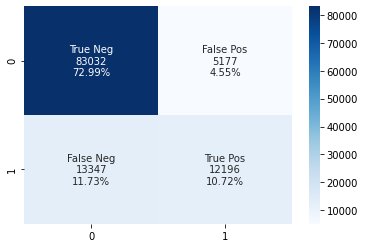

In [179]:
# Visualise confusion matrix 
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                sgd_clf_cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     sgd_clf_cf_matrix.flatten()/np.sum(sgd_clf_cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(sgd_clf_cf_matrix, annot = labels, fmt='', cmap='Blues')

In [180]:
f1_score(y_train, y_train_pred, pos_label = 'Yes')

0.568366110541523

In [181]:
precision_score(y_train, y_train_pred, pos_label = 'Yes')

0.702008864329707

In [182]:
recall_score(y_train, y_train_pred, pos_label = 'Yes')

0.47746936538386253

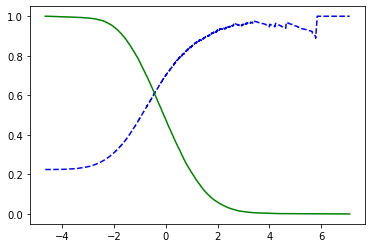

In [183]:
y_scores = cross_val_predict(sgd_clf, X_train_transformed, y_train, cv = 3, method = 'decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores, pos_label = 'Yes')

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    [...] # highlight the threshold and add the legend, axis label, and grid

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [184]:
y_scores

array([-1.28201499, -0.68325776, -2.059367  , ..., -1.11578945,
        2.76203746, -1.73443684])

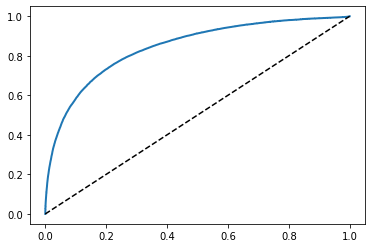

In [185]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores, pos_label = 'Yes')

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    [...] # Add axis labels and grid

plot_roc_curve(fpr, tpr)
plt.show()

In [186]:
roc_auc_score(y_train, y_scores)

0.8428469834449795

### Logistic Regression

In [187]:
start_time = datetime.now()
logreg_clf = LogisticRegression()
logreg_clf.fit(X_train_transformed, y_train)
y_train_pred = cross_val_predict(logreg_clf, X_train_transformed, y_train, cv = 3)
end_time = datetime.now()
print('Total running time:', (end_time - start_time).total_seconds())

Total running time: 4.958802


<AxesSubplot:>

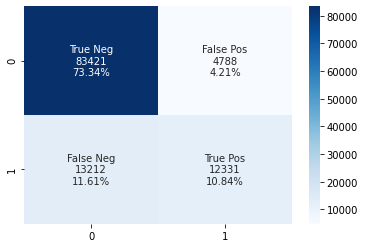

In [188]:
logreg_clf_cf_matrix = confusion_matrix(y_train, y_train_pred)
# Visualise confusion matrix 
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                logreg_clf_cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     logreg_clf_cf_matrix.flatten()/np.sum(logreg_clf_cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(logreg_clf_cf_matrix, annot = labels, fmt='', cmap='Blues')

In [189]:
f1_score(y_train, y_train_pred, pos_label = 'Yes')

0.5780788523744785

### Random Forest

In [190]:
start_time = datetime.now()
forest_clf = RandomForestClassifier(random_state = 42)
forest_clf.fit(X_train_transformed, y_train)
y_train_pred = cross_val_predict(forest_clf, X_train_transformed, y_train, cv = 3)
end_time = datetime.now()
print('Total running time:', (end_time - start_time).total_seconds())

Total running time: 107.732623


<AxesSubplot:>

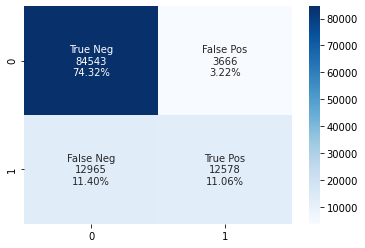

In [191]:
forest_clf_cf_matrix = confusion_matrix(y_train, y_train_pred)
# Visualise confusion matrix 
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                forest_clf_cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     forest_clf_cf_matrix.flatten()/np.sum(forest_clf_cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(forest_clf_cf_matrix, annot = labels, fmt='', cmap='Blues')

In [192]:
f1_score(y_train, y_train_pred, pos_label = 'Yes')

0.6020054083805969

In [193]:
# Check for feature importance
importances = forest_clf.feature_importances_
stad = np.std([tree.feature_importances_ for tree in forest_clf.estimators_], axis = 0)

indices = np.argsort(importances)[::-1]
print('Feature Ranking:')

for f in range(X.shape[1]):
    print('%d. features %d (%f)'% (f+1, indices[f], importances[indices[f]]))

Feature Ranking:
1. features 34 (0.158828)
2. features 36 (0.056763)
3. features 11 (0.052268)
4. features 33 (0.051501)
5. features 18 (0.050782)
6. features 35 (0.050059)
7. features 9 (0.047030)
8. features 40 (0.044487)
9. features 7 (0.043702)
10. features 8 (0.040905)
11. features 39 (0.040098)
12. features 32 (0.031097)
13. features 10 (0.030171)
14. features 31 (0.028557)
15. features 41 (0.026230)
16. features 38 (0.024640)
17. features 45 (0.023130)
18. features 44 (0.020766)
19. features 37 (0.020208)
20. features 42 (0.019255)
21. features 21 (0.006416)
22. features 30 (0.006337)
23. features 24 (0.006275)
24. features 29 (0.006249)


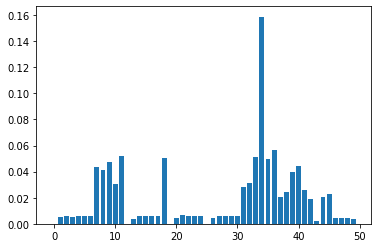

In [194]:
# plot feature importance
plt.bar([x for x in range(len(importances))], importances)
plt.show()

As evident from the feature importance, many features that I initially retain are not so useful at predicting RainTomorrow. They include Location WindGustDir, WindDir9am, WindDir3pm and Season.

Since seasonality is already reflected based on month, I will remove the Season feature. For 4 other features, I will perform feature engineering and try other methods of encoding since binary encoding might have caused information loss (e.g. Unique locations are not reflected clearly when being encoded to binary values across 6 features). 

### K-Nearest Neighbors

In [195]:
start_time = datetime.now()
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_transformed, y_train)
y_train_pred = cross_val_predict(knn_clf, X_train_transformed, y_train, cv = 3)
end_time = datetime.now()
print('Total running time:', (end_time - start_time).total_seconds())

Total running time: 241.817153


<AxesSubplot:>

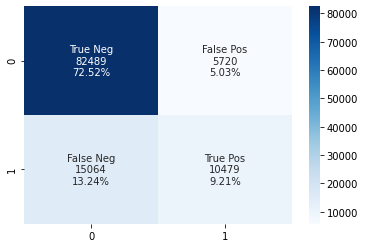

In [196]:
knn_clf_cf_matrix = confusion_matrix(y_train, y_train_pred)
# Visualise confusion matrix 
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                knn_clf_cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     knn_clf_cf_matrix.flatten()/np.sum(knn_clf_cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(knn_clf_cf_matrix, annot = labels, fmt='', cmap='Blues')

In [197]:
f1_score(y_train, y_train_pred, pos_label = 'Yes')

0.50208423170907

### AdaBoost

In [198]:
start_time = datetime.now()
ada_clf = AdaBoostClassifier()
ada_clf.fit(X_train_transformed, y_train)
y_train_pred = cross_val_predict(ada_clf, X_train_transformed, y_train, cv = 3)
end_time = datetime.now()
print('Total running time:', (end_time - start_time).total_seconds())

Total running time: 74.995233


<AxesSubplot:>

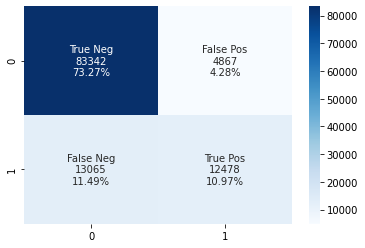

In [199]:
ada_clf_cf_matrix = confusion_matrix(y_train, y_train_pred)
# Visualise confusion matrix 
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                ada_clf_cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     ada_clf_cf_matrix.flatten()/np.sum(ada_clf_cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(ada_clf_cf_matrix, annot = labels, fmt='', cmap='Blues')

In [200]:
f1_score(y_train, y_train_pred, pos_label = 'Yes')

0.5818877075172544

### Gradient Tree Boosting

In [201]:
start_time = datetime.now()
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train_transformed, y_train)
y_train_pred = cross_val_predict(gb_clf, X_train_transformed, y_train, cv = 3)
end_time = datetime.now()
print('Total running time:', (end_time - start_time).total_seconds())

Total running time: 203.63732


<AxesSubplot:>

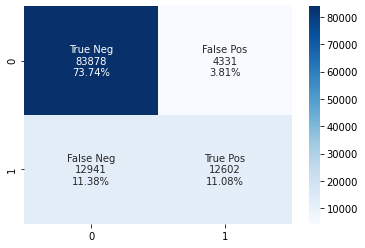

In [202]:
gb_clf_cf_matrix = confusion_matrix(y_train, y_train_pred)
# Visualise confusion matrix 
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                gb_clf_cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     gb_clf_cf_matrix.flatten()/np.sum(gb_clf_cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(gb_clf_cf_matrix, annot = labels, fmt='', cmap='Blues')

In [203]:
f1_score(y_train, y_train_pred, pos_label = 'Yes')

0.5933703738581788

The most common metric used to evaluate the performance of a classification predictive model is classification accuracy. Typically, the accuracy of a predictive model is good (above 90% accuracy), therefore it is also very common to summarize the performance of a model in terms of the error rate of the model.

Accuracy = Correct Predictions / Total Predictions

Error Rate = Incorrect Predictions / Total Predictions

In [204]:
seed = 7
models = []
models.append(('SGD', SGDClassifier()))
models.append(('LOG', LogisticRegression()))
models.append(('RDF', RandomForestClassifier()))
models.append(('ADA', AdaBoostClassifier()))
models.append(('GDT', GradientBoostingClassifier()))

results = []
names = []
scoring = 'accuracy'
for name, model in models: 
    kfold = KFold(n_splits = 10, random_state = seed, shuffle = True)
    cv_results = cross_val_score(model, X_train_transformed, y_train, cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    


SGD: 0.837453 (0.003425)
LOG: 0.841972 (0.003422)
RDF: 0.854244 (0.002678)
ADA: 0.842042 (0.002726)
GDT: 0.848583 (0.002609)


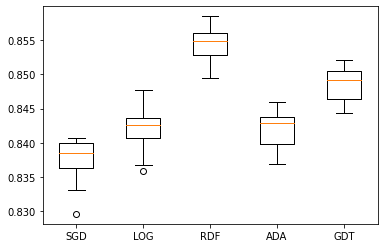

In [205]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Although the first round of training results in the highest accuracy of 85% (slightly lower than my target 90%), the results reveal that Random Forest and Gradient Tree Boost resulted in better accuracy than other 3 models. AdaBoost does not perform as well as the other 2 emsemble methods because it is sensitive to outliers (which are present in the existing dataset). 

**Note:** After trial and error, I decided to eliminate the Support Vector Machine algorithm because it takes too long to execute, yet resulting in lower accuracy than those 3 abovementioned models. 

Since I aim to achieve a minimum accuracy of 90%, I will attempt to evaluate and improve the performance of these models by doing the following steps. 
1. Correcting the imbalanced dataset
2. Performing K-fold Cross Validation on the corrected dataset

### Improve model performance

#### Correcting imbalanced dataset

It is observed that the number of days with RainTomorrow = Yes is much lower than that of RainTomorrow = No. Such an imbalanced dataset could potentially explain the poor prediction performance for RainTomorrow = Yes indicated in the confusion matrix across all ML models. 

One approach to address imbalanced datasets is to oversample the minority class. There are 2 methods to oversample the minority class. 
1. Duplicate examples in the minority class: simple to implement but does not add any new information to the model 
2. Synthesis new examples from the existing samples with Synthetic Minority Oversampling Technique (SMOTE)

I decided to go with SMOTE because it adds new information to the model, which hopefully translates to better performance. To avoid data leakage (when information that would not be available at prediction time is used when building the model), I will only be resample the training dataset instead of the entire dataset. 

In [206]:
X_resampled, y_resampled = SMOTE().fit_resample(X_train_transformed, y_train)

#### Performing K-fold Cross Validation 

To generate results in a less biased or less optimistic estimate of the model skill than other methods, such as a simple train/test split, I will attempt to perform K-fold Cross Validation. In this procedure, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:
- A model is trained using  of the folds as training data;
- the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).

The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set), which is a major advantage in problems such as inverse inference where the number of samples is very small.

In [207]:
seed = 7
models = []
models.append(('SGD', SGDClassifier()))
models.append(('LOG', LogisticRegression()))
models.append(('RDF', RandomForestClassifier()))
models.append(('ADA', AdaBoostClassifier()))
models.append(('GDT', GradientBoostingClassifier()))

results = []
names = []
scoring = 'accuracy'
for name, model in models: 
    kfold = KFold(n_splits = 10, random_state = seed, shuffle = True)
    cv_results = cross_val_score(model, X_resampled, y_resampled, cv = kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

SGD: 0.778719 (0.002395)
LOG: 0.782862 (0.002061)
RDF: 0.910400 (0.002795)
ADA: 0.825919 (0.001930)
GDT: 0.873783 (0.002968)


After resampling, the performance of Random Forest and Gradient Tree Boosting improves significantly while that of other 3 models deteriorates. So correcting imbalanced dataset help here. Hence I will use the resampled dataset for further hyperparameter optimisation. 

It is also noted that Random Forest performs much better than other model based on accuracy. But before deciding to focus on Random Forest, I would check other performance metrics such as recall, precision and f1 score to obtain a more holistic view on how Random Forest performs beyond accuracy. 

### Check other performance metrics of Random Forest with the resampled dataset and k-fold = 10

In [208]:
start_time = datetime.now()
forest_clf = RandomForestClassifier(random_state = 42)
forest_clf.fit(X_resampled, y_resampled)
y_train_pred = cross_val_predict(forest_clf, X_resampled, y_resampled, cv = 10)
end_time = datetime.now()
print('Total running time:', (end_time - start_time).total_seconds())

Total running time: 862.181283


<AxesSubplot:>

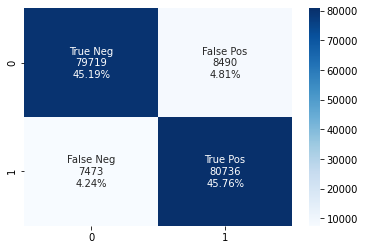

In [209]:
forest_clf_cf_matrix = confusion_matrix(y_resampled, y_train_pred)
# Visualise confusion matrix 
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                forest_clf_cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     forest_clf_cf_matrix.flatten()/np.sum(forest_clf_cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(forest_clf_cf_matrix, annot = labels, fmt='', cmap='Blues')

In [210]:
f1_score(y_resampled, y_train_pred, pos_label = 'Yes')

0.9100346605799307

In [211]:
precision_score(y_resampled, y_train_pred, pos_label = 'Yes')

0.9048483625848968

In [212]:
recall_score(y_resampled, y_train_pred, pos_label = 'Yes')

0.915280753664592

Since Random Forest performs well across accuracy, precision, recall and F1 Score (which is essentially the harmonic mean between precision and recall), I will be focusing on fine-tuning Random Forest in the next step. 

### RECAPS

**Decisions**
1. Drop the Season feature due to low importance 
2. Oversample training dataset to correct the imbalanced dataset 
3. Switch to GCP to fine-tune the ML algorithms because it takes too long to perform fine-tuning and testing on my machine. 

Although additional Feature Engineering might be helpful in boosting Random Forest performance, I decided not to proceed further. Given the time constraints, the current performance metrics are acceptable and pursuing further feature engineering is not worth the effort. 

### NEXT STEPS

**Step 1. Set up Jupyter Lab on GCP AI Platform**

**Step 2. Perform data preprocessing** 
1. Convert Date column from string to datetime & create Year & Month features
2. Handle missing values for numerical features: forward fill method
3. Remove records with missing labels (i.e. RainTomorrow is null)
4. Split data into a training set and a test set: remove Date feature due to high cardinality
5. Handle missing values and encoding categorical features
6. Feature scaling: standard scaler for simplicity
7. Correct imbalanced dataset with SMOTE (Synthetic Minority Oversampling Technique)

**Step 3. Fine-tune Random Forest Classifier using RandomizedSearchCV and GridSearchCV**

Note: Based on earlier experiment with GCP AI Platform, RandomizedSearchCV might take too long to fit if I use the full dataset. To speed up the process, I would perform fine-tuning with 25% of the randomly sampled records.  